# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Modeling COVID-19 Growth with Neural Networks
## AC209B: Advanced Topics in Data Science



**Harvard University**<br/>
**Spring 2020**<br/>
**Team members**: William Seaton, Johannes Kolberg, Hardik Gupta


<hr style="height:2pt">

**Summary**: Accurate understanding of the severity and spread of the novel coronavirus COVID-19 is critical to implementing an effective public health response. As with any novel virus, COVID-19 has unique characteristics and data challenges that make accurate modeling difficult and there has been much public debate about the correct methodology and resulting output that we should use to guide our decisions. We propose various methods based on the architecture of Recurrent Neural Networks and discuss their accuracy and usability for predicting COVID-19 case growth at various time lengths.

----

There has been consistent speculation about the accuracy of coronavirus case counts around the world. Different countries have varying testing capacity and requirements, resulting in a patchwork of testing rates and coverage. In the United States, academics and news organizations have reported that the actual coronavirus case count is being underreported.

Some countries benefited from advanced notice as they were impacted by the spread of COVID-19 later than others. These countries in particular can use the growth rates of countries ahead of them to learn from and model their own expected growth rates.

Public health goals demand pandemic forecasting provide three things:

1) Accurate number of case growth

2) Predicted as far into the future as confidence will allow

3) Delivered as early as sufficient data is available

For the methods we use, we explore their capacity along each of these dimensions.

COVID-19 has a few significant modeling challenges. First, the spread of coronavirus is dependent on innate national qualities such as population size and geographic density as well as situational factors such as public health infrastructure and policy choices. This can lead to very different growth curves across countries. Second, because COVID-19 has unique characteristics, like infection rate and severity, it must be modeled separately from other viruses. This means we must try to produce models and predictions as early as possible with extremely limited data. As the pandemic spreads, we will gain additional data that can be used to refine our predictions but our goal should be to produce useable numbers that guide policy decisions early. Finally, case counts are adjusted retroactively on several occasions as the policy for counting cases changes, resulting in jagged growth curves that would likely look a lot more smoother if consistent measuring schemes had been used from the beginning. This presents additional challenges for the models, as they need to anticipate when cases are underreported and will subsequently "catch up".

We propose applying neural networks to modeling COVID-19 because of unique advantages in the underlying architecture in overcoming these challenges. In particular, we rely heavily on Recurrent Neural Networks (RNNs), as these are designed specificially for sequential data, which includes time series such as ours. RNNs allow stateful predictions so we can update our model as new data comes in and prioritize the latest numbers, especially important when dealing with exponential growth. RNNs can learn the shapes of multiple input time series when modeling expected number of cases, allowing data scientists to use related time series that may be easier and more accurate to collect. RNNs provide flexibility in architecture definition to deal with very different but related time series, like cumulative cases or new cases per day.

We apply RNNs and associated models to three hypotheses:

1) Are there general infection curve development patterns for COVID-19 across countries?

2) Can alternate time series assist with forecasting COVID-19 cases?

3) Can COVID-19 growth in other countries assist with forecasting cases in a target nation?

---------------


#### Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout, Bidirectional, TimeDistributed, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import class for reservoir computing
from pyESN import ESN # Written by user cknd: https://github.com/cknd/pyESN

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

We incorporate multiple time series to aid in forecasting various response variables related to COVID-19 spread, such as cumulative case count and new cases per day. Our time series include case and death count from the ECDC, test counts for several countries as collected by the website OurWorldInData and population mobility data provided separately by Apple and Google. Our experiments assess which of these time series is most useful for modeling COVID-19.

## COVID-19 Cases and Deaths - ECDC

We integrate data directly from the European Centre for Disease Prevention and Control (ECDC), a Stockholm-based organization with the aim of strengthening Europe's infectious disease preparedness. We do this because it is considered the most trustworthy international sources of accurate numbers, according to OurWorldInData.org. While traditionally a global pandemic would be tracked and coordinated via the World Health Organzation (WHO), the WHO has struggled both tactically and strategically to contribute meaningfully to the fight against COVID-19. Tactically, OurWorldInData found and reported to the organization that their data files contain many errors and are contradicted by the WHO's own Situation Reports. Additionally, a reporting cut-off time change between Reports 57 and 58 means there is data overlap/duplication that is impossible to eliminate. Strategically, the accuracy of the numbers that WHO is reporting have been challenged.

Source: https://www.ecdc.europa.eu/en/covid-19-pandemic

In [2]:
# Download the latest CSV directly from ECDC website
ecdc_country = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", na_values = "", encoding="utf-8-sig")
ecdc_country['dateRep'] = pd.to_datetime(ecdc_country['dateRep'], format='%d/%m/%Y')
ecdc_country = ecdc_country.sort_values(by=['countriesAndTerritories', 'year', 'month', 'day'], ascending=True)\
                           .rename(columns={
                                    'dateRep':'date',
                                    'countriesAndTerritories': 'country',
                                    'geoId': 'geoID',
                                    'countryterritoryCode': 'country_code',
                                    'popData2018': 'population_2018',
                                    'continentExp': 'continent',
                                    'cases': 'new_cases',
                                    'deaths': 'new_deaths'})
display(ecdc_country.shape)
ecdc_country

(16114, 11)

date  day  month  year  new_cases  new_deaths      country geoID  \
121   2019-12-31   31     12  2019          0           0  Afghanistan    AF   
120   2020-01-01    1      1  2020          0           0  Afghanistan    AF   
119   2020-01-02    2      1  2020          0           0  Afghanistan    AF   
118   2020-01-03    3      1  2020          0           0  Afghanistan    AF   
117   2020-01-04    4      1  2020          0           0  Afghanistan    AF   
...          ...  ...    ...   ...        ...         ...          ...   ...   
16067 2020-05-06    6      5  2020          0           0     Zimbabwe    ZW   
16066 2020-05-07    7      5  2020          0           0     Zimbabwe    ZW   
16065 2020-05-08    8      5  2020          0           0     Zimbabwe    ZW   
16064 2020-05-09    9      5  2020          1           0     Zimbabwe    ZW   
16063 2020-05-10   10      5  2020          1           0     Zimbabwe    ZW   

      country_code  population_2018 continent  
121            AFG       37172386.0      Asia  
120            AFG       37172386.0      Asia  
119            AFG       37172386.0      Asia  
118            AFG       37172386.0      Asia  
117            AFG       37172386.0      Asia  
...            ...              ...       ...  
16067          ZWE       14439018.0    Africa  
16066          ZWE       14439018.0    Africa  
16065          ZWE       14439018.0    Africa  
16064          ZWE       14439018.0    Africa  
16063          ZWE       14439018.0    Africa  

[16114 rows x 11 columns]

In [3]:
# Define function to standardize target country names
def standardize_country_names(dataframe, axis=1):
    country_names_dict = {
        'United States': 'United_States',
        'United_States_of_America': 'United_States',
        'South Korea': 'South_Korea',
        'Republic of Korea': 'South_Korea',
        'United Kingdom': 'United_Kingdom',
        'UK': 'United_Kingdom'
    }
    
    # Rename columns
    if axis==1:
        dataframe = dataframe.rename(columns=country_names_dict)
    # Rename row values
    elif axis==0:
        dict_iter = iter(country_names_dict.items())
        for i in range(len(country_names_dict)):
            pair = next(dict_iter)
            dataframe['country'] = dataframe['country'].replace(pair[0], pair[1])
    
    return dataframe

In [4]:
# Rename select countries for legibility
ecdc_country = standardize_country_names(ecdc_country, axis=0)

In [5]:
# Add columns to translate from new daily cases to cumulative cases
ecdc_country['cases'] = ecdc_country.groupby('country')['new_cases'].transform(pd.Series.cumsum)
ecdc_country['deaths'] = ecdc_country.groupby('country')['new_deaths'].transform(pd.Series.cumsum)
# ecdc_country

## Enrich ECDC Data

#### Standardize cases per 100,000 citizens

In [6]:
# Cumulative cases per 100k inhabitants
ecdc_country['cases_per100k'] = ecdc_country['cases']*1e5/ecdc_country['population_2018']
ecdc_country['deaths_per100k'] = ecdc_country['deaths']*1e5/ecdc_country['population_2018']

ecdc_country['new_cases_per100k'] = ecdc_country['new_cases']*1e5/ecdc_country['population_2018']
ecdc_country['new_deaths_per100k'] = ecdc_country['new_deaths']*1e5/ecdc_country['population_2018']

#### Smooth data with rolling mean of daily new cases
Daily new case counts are highly erratic and we surmise that these developments follow a smoother true trend. To help the model learn the underlying problem rather than trying to memorize jagged lines, we smooth the response variable.

This was inspired by a precedent in Prof. Mauricio Santillana's published work.

In [7]:
# Window == number of days in rolling window over which to calculate mean
window = 5
ecdc_country['new_cases_smooth'] = ecdc_country.groupby('country')['new_cases'].transform(lambda x: x.rolling(window).mean()).fillna(0)
ecdc_country['new_cases_per100k_smooth'] = ecdc_country.groupby('country')['new_cases_per100k'].transform(lambda x: x.rolling(window).mean()).fillna(0)

#### Calculate Day Zero

To standardize time series for various countries, we calculate Day Zero of COVID-19 infection for each day since a country's first case.

In [8]:
# Calculate Day Zero for each country
day_zero = ecdc_country[ecdc_country.cases > 0].groupby('country')[['date']].first()
day_zero.columns = ['day_zero']
day_zero.head(3)

day_zero
country               
Afghanistan 2020-02-25
Albania     2020-03-09
Algeria     2020-02-26

In [9]:
# Calculate Days Since for each entry for each country
ecdc_country = ecdc_country.join(day_zero, how='left', on='country')

ecdc_country['days_since_zero'] = (ecdc_country['date'] - ecdc_country['day_zero']).dt.days

ecdc_country[['country', 'days_since_zero']].tail(3)

country  days_since_zero
16065  Zimbabwe               48
16064  Zimbabwe               49
16063  Zimbabwe               50

#### Preview final ECDC dataframe

In [10]:
ecdc_country.tail(3)

date  day  month  year  new_cases  new_deaths   country geoID  \
16065 2020-05-08    8      5  2020          0           0  Zimbabwe    ZW   
16064 2020-05-09    9      5  2020          1           0  Zimbabwe    ZW   
16063 2020-05-10   10      5  2020          1           0  Zimbabwe    ZW   

      country_code  population_2018  ... cases  deaths  cases_per100k  \
16065          ZWE       14439018.0  ...    34       4       0.235473   
16064          ZWE       14439018.0  ...    35       4       0.242399   
16063          ZWE       14439018.0  ...    36       4       0.249324   

       deaths_per100k  new_cases_per100k  new_deaths_per100k  \
16065        0.027703           0.000000                 0.0   
16064        0.027703           0.006926                 0.0   
16063        0.027703           0.006926                 0.0   

       new_cases_smooth  new_cases_per100k_smooth   day_zero days_since_zero  
16065               0.0              2.428613e-18 2020-03-21              48  
16064               0.2              1.385136e-03 2020-03-21              49  
16063               0.4              2.770271e-03 2020-03-21              50  

[3 rows x 21 columns]

### Define target countries and global variables

In [11]:
# Make list of countries we're interested in analyzing
target_countries = [
    'France', 'Italy', 'Germany', 'Austria', 'United_Kingdom', 
    'Spain', 'Portugal', 'Turkey', 'Norway', 'Sweden', 
    'Belgium', 'Netherlands', 'Switzerland', 
    'Singapore', 'United_States', 'Canada'
]
print(target_countries)

['France', 'Italy', 'Germany', 'Austria', 'United_Kingdom', 'Spain', 'Portugal', 'Turkey', 'Norway', 'Sweden', 'Belgium', 'Netherlands', 'Switzerland', 'Singapore', 'United_States', 'Canada']


In [12]:
# Gather unique countries
unique_countries = ecdc_country.country.unique()
print(len(unique_countries), "unique countries")

209 unique countries


In [13]:
# Calculate greatest length of non-null time series i.e. longest period of COVID-19 presence
max_days = ecdc_country.days_since_zero.max()
print(max_days, "days in the longest impacted country")

131 days in the longest impacted country


## Alternate Time Series Integration

### Integrate testing data - Source: OurWorldInData

In [14]:
# Read CSV
testing_raw = pd.read_csv('covid-testing-all-observations.csv', na_values="")\
                .rename(columns={
                        'Cumulative total': 'tests',
                        'Daily change in cumulative total': 'new_tests',
                        'Date': 'date'})
testing_raw.head(3)

Entity ISO code        date  \
0  Argentina - tests performed      ARG  2020-04-08   
1  Argentina - tests performed      ARG  2020-04-09   
2  Argentina - tests performed      ARG  2020-04-10   

                                          Source URL             Source label  \
0  https://www.argentina.gob.ar/sites/default/fil...  Government of Argentina   
1  https://www.argentina.gob.ar/sites/default/fil...  Government of Argentina   
2  https://www.argentina.gob.ar/sites/default/fil...  Government of Argentina   

  Notes  tests  new_tests  Cumulative total per thousand  \
0   NaN  13330        NaN                          0.295   
1   NaN  14850     1520.0                          0.329   
2   NaN  16379     1529.0                          0.362   

   Daily change in cumulative total per thousand  \
0                                            NaN   
1                                          0.034   
2                                          0.034   

   3-day rolling mean daily change  \
0                              NaN   
1                              NaN   
2                              NaN   

   3-day rolling mean daily change per thousand  \
0                                           NaN   
1                                           NaN   
2                                           NaN   

   7-day rolling mean daily change  \
0                              NaN   
1                              NaN   
2                              NaN   

   7-day rolling mean daily change per thousand  
0                                           NaN  
1                                           NaN  
2                                           NaN

In [15]:
# Define country column
country_column = testing_raw['Entity'].str.split(" - ", n=1, expand=True)
testing_raw['country'] = country_column[0]

# Rename select countries for legibility
testing_raw = standardize_country_names(testing_raw, axis=0)

# Calculate unique
unique_countries_testing = testing_raw['country'].unique()
print(len(unique_countries_testing), "unique countries with data on testing rates")

84 unique countries with data on testing rates


In [16]:
# The data provided records testing numbers from the CDC and a volunteer effort called the COVID Tracking Project.
# The CDC reports only COVID tests performed in public labs, while CTP reports all tests public or private
# by aggregating reported numbers from individual states. Because it is the superset, we elect to use that.

# Filter out duplicative CDC numbers
pre = len(testing_raw)
testing_raw = testing_raw[testing_raw['Source label'] != 'United States CDC']
post = len(testing_raw)
print("Remove CDC numbers:", pre, "rows => ", post)

# When two numbers for a single country are reported, select tests performed over people tested
# Tests performed is typically reported earlier and has more days of data
testing_raw = testing_raw[testing_raw['Entity'].isin([
    'India - people tested',
    'Italy - people tested',
    'Japan - people tested',
    'Singapore - people tested',
    'United Kingdom - people tested'
]) == False]

print("Remove repetitive numbers on people tested: rows => ", len(testing_raw))

Remove CDC numbers: 4465 rows =>  4361
Remove repetitive numbers on people tested: rows =>  4132


### Integrate Mobility Data - Source: Apple

In [17]:
# Read CSV
apple_raw = pd.read_csv('applemobilitytrends.csv', na_values="")\
                .rename(columns={
                        'region': 'country'})
apple_raw.head()

geo_type    country transportation_type alternative_name  2020-01-13  \
0  country/region    Albania             driving              NaN       100.0   
1  country/region    Albania             walking              NaN       100.0   
2  country/region  Argentina             driving              NaN       100.0   
3  country/region  Argentina             walking              NaN       100.0   
4  country/region  Australia             driving              NaN       100.0   

   2020-01-14  2020-01-15  2020-01-16  2020-01-17  2020-01-18  ...  \
0       95.30      101.43       97.20      103.55      112.67  ...   
1      100.68       98.93       98.46      100.85      100.13  ...   
2       97.07      102.45      111.21      118.45      124.01  ...   
3       95.11      101.37      112.67      116.72      114.14  ...   
4      102.98      104.21      108.63      109.08       89.00  ...   

   2020-04-29  2020-04-30  2020-05-01  2020-05-02  2020-05-03  2020-05-04  \
0       35.90       38.09       37.23       29.36       36.00       43.69   
1       41.49       38.25       38.68       32.28       43.41       49.59   
2       32.22       34.45       22.69       28.23       16.44       32.01   
3       22.78       24.80       16.62       20.61       12.44       21.35   
4       59.46       63.12       58.40       48.67       58.18       62.51   

   2020-05-05  2020-05-06  2020-05-07  2020-05-08  
0       42.61       43.11       46.13       45.78  
1       46.44       52.84       52.37       48.10  
2       33.63       35.13       35.56       40.25  
3       22.63       23.84       23.84       30.63  
4       64.04       66.19       71.34       67.64  

[5 rows x 121 columns]

In [18]:
# Rename select countries for legibility
apple_raw = standardize_country_names(apple_raw, axis=0)

In [19]:
# Types of transit
apple_raw.transportation_type.unique()

array(['driving', 'walking', 'transit'], dtype=object)

### Integrate Mobility Data - Source: Google

In [20]:
# Read CSV
google_raw = pd.read_csv('Global_Mobility_Report.csv', na_values="")\
                .rename(columns={
                        'country_region': 'country'})
google_raw.head()

country_region_code               country sub_region_1 sub_region_2  \
0                  AE  United Arab Emirates          NaN          NaN   
1                  AE  United Arab Emirates          NaN          NaN   
2                  AE  United Arab Emirates          NaN          NaN   
3                  AE  United Arab Emirates          NaN          NaN   
4                  AE  United Arab Emirates          NaN          NaN   

         date  retail_and_recreation_percent_change_from_baseline  \
0  2020-02-15                                                0.0    
1  2020-02-16                                                1.0    
2  2020-02-17                                               -1.0    
3  2020-02-18                                               -2.0    
4  2020-02-19                                               -2.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                4.0   
1                                                4.0   
2                                                1.0   
3                                                1.0   
4                                                0.0   

   parks_percent_change_from_baseline  \
0                                 5.0   
1                                 4.0   
2                                 5.0   
3                                 5.0   
4                                 4.0   

   transit_stations_percent_change_from_baseline  \
0                                            0.0   
1                                            1.0   
2                                            1.0   
3                                            0.0   
4                                           -1.0   

   workplaces_percent_change_from_baseline  \
0                                      2.0   
1                                      2.0   
2                                      2.0   
3                                      2.0   
4                                      2.0   

   residential_percent_change_from_baseline  
0                                       1.0  
1                                       1.0  
2                                       1.0  
3                                       1.0  
4                                       1.0

In [21]:
# Rename select countries for legibility
google_raw = standardize_country_names(google_raw, axis=0)

In [22]:
# Average mobility changes across types
google_raw['overall_change_from_baseline'] = round(np.mean(google_raw.iloc[:,5:], axis=1), 3)

## Helper Functions to improve Time Series Forecasting

#### MinMax Scaling

In [23]:
# Define function to scale a dataframe
def scale(dataframe):
    scaler = MinMaxScaler()
    dataframe_scaled = scaler.fit_transform(dataframe)
    dataframe_scaled = pd.DataFrame(dataframe_scaled, columns=dataframe.columns, index=dataframe.index)
    
    return dataframe_scaled

#### X/Y Split for Supervised Learning
The below function takes in a `time_series_df` dataframe with the original data and returns a tensor with overlapping input and output sequences of some input length and output length for prediction. It takes the parameter `days_train` which specifies the temporal dimension of input sequences, i.e. how many days of history are used for each round of prediction. Similarly, `days_pred` specifies the length of the response sequence, i.e. how far into the future the model is to predict.

Which column to use as the response can be passed as a parameter, along with whether this column should be included in the `X` tensor.

For instance, `days_train = 14` and `days_pred = 7` means the model is to use 14 days of history to predict 7 days out. If the response is included, this means the response variable for days 1 through 14 is included, and we are to predict the response for days 15 through 21. The returned sequences step forward one day at a time, so the first input sequence is days 1-14, the second 2-15, etc.

In [24]:
# Define function to create X/Y split of time series
# Permits option of training on response or holding out response
def structure_supervised(time_series_df, response:str, days_train, days_pred, holdout=False, print_shape=False):
    
    # Initialize x, y arrays as zeroes
    # Decide if you want to hold out response variable
    if holdout is True:
        x = np.zeros((0, days_train, time_series_df.shape[-1]-1)) # -1 because we remove the response from X
    elif holdout is False:
        x = np.zeros((0, days_train, time_series_df.shape[-1]))
    y = np.zeros((0, days_pred))
    
    # Check response variable entered correctly
    if type(response) != str:
        print('Please enter your target variable as a string')
        
    # For every row in the dataframe
    for i in range(len(time_series_df)):
        
        # Define the windows of training and prediction
        idx_in = i + days_train
        idx_out = idx_in + days_pred
        
        # If window of prediction tries to go past end of data, stop
        if idx_out > len(time_series_df):
            break
            
        # Choose to holdout response
        if holdout is True:
            # Create windowed training sequence for all non-response columns
            seq_in = np.array(time_series_df.iloc[i:idx_in, time_series_df.columns != response])

            # Create windowed prediction sequence for response column
            response_idx = time_series_df.columns.get_loc(response)
            seq_out = np.array(time_series_df.iloc[idx_in:idx_out, response_idx])
        elif holdout is False:
            try:    
                seq_in = np.array(time_series_df.iloc[i:idx_in, :])
                seq_out = np.array(time_series_df.iloc[idx_in:idx_out, -1])
            except AttributeError:
                seq_in = time_series_df[i:idx_in, :]
                seq_out = time_series_df[idx_in:idx_out, -1]
        
        # Add sequences to respective array, shaped for supervised learning
        x = np.concatenate((x, seq_in.reshape(((1,)+seq_in.shape))), axis = 0)
        y = np.concatenate((y, seq_out.reshape(((1,)+seq_out.shape))), axis = 0)
        
    # Decide if you want to print the output shape for clarity
    if print_shape == True:
        print("x_train shape: ", x.shape, "y_train shape: ", y.shape)
    return np.array(x), np.array(y)

---------

---------

# Generalizable Model for COVID-19 Population-Level Growth Rates

Our first challenge is to design a model that can use all available time series to best approximate generalizable coronavirus growth curves and provide predictions a sufficient number of days ahead for policymakers for any country regardless of the shape of its curve. We explore two architectures (Stacked LSTM and CNN) before identifying a combination design as the most effective at predicting future cases.

We aim to train a model to make predictions `m` days out based on the preceding `n` days of history, mapping input features to predictions on that horizon for the response, independent of the specific country. We have a lot of countries, but each `n`-length input sequence to `m`-length output sequence must contain consecutive days within the same country. Hence, countries with a longer (recorded) history of COVID-19 will be more represented in the dataset.

LSTM is specifically engineered for sequential data, and is thus a natural candidate for time series problems such as this. Assuming overfitting is addressed, e.g. via regularisation, stacking several layers of LSTM will make the model even better, though it also tends to make it very slow to train. We could alternatively use GRU layers, which sacrifice some predictive power for much faster training. However, we have on the order of a thousand training observations, so we can afford both to use LSTM and to stack consecutive layers for greater expressiveness, as training times will still be reasonable.

An alternative is using CNN for time series predictions. CNNs are translation invariant, meaning they do not capture sequential development the same way, but rather each filter learns to look for specific development patterns across the input sequence. It may sound unintuitive, but CNNs have shown impressive performance in several time series domains, from financial time series to ride-hailing demand prediction. Since we are trying to build a model to learn general infection rate curve development patterns, such an essentially curve-fitting model might prove effective.

That said, our primary motivation for incorporating CNN is as a pre-processing step for LSTM. Several models in academia and industry have found that passing input sequences through a CNN before passing them on to an LSTM improves overall predictive power. There are two ways to use CNN for pre-processing, both using 1D convolutions: the early CNN layers use 1D kernels of size greater than 1 to peruse the raw data for general translation invariant patterns and pass what it finds on to the LSTM; alternatively the early CNN layers use kernels to change the dimensionality of the input data, which in e.g. InceptionNet is used to reduce dimensionality, but in our case essentially performs feature engineering to increase the dimensionality such that LSTM has more varied representations of the input data to analyse. In both cases the CNN layers pass what they find on to LSTM, which maps the sequence of activations to the response sequences.

In [25]:
# Limit to predictors of interest and observations after COVID-19 found in country
growth_curve = ecdc_country.loc[ecdc_country.days_since_zero >= 0,
                                [
                                    'country', 'date', 'new_cases', 'new_deaths',
                                    'days_since_zero', 'cases', 'deaths',
                                    'population_2018', 'day_zero',
                                    'cases_per100k', 'new_cases_per100k',
                                    'new_deaths_per100k', 'new_cases_smooth',
                                    'new_cases_per100k_smooth'
                                ]]
growth_curve.head(3)

country       date  new_cases  new_deaths  days_since_zero  cases  \
65  Afghanistan 2020-02-25          1           0                0      1   
64  Afghanistan 2020-02-26          0           0                1      1   
63  Afghanistan 2020-02-27          0           0                2      1   

    deaths  population_2018   day_zero  cases_per100k  new_cases_per100k  \
65       0       37172386.0 2020-02-25        0.00269            0.00269   
64       0       37172386.0 2020-02-25        0.00269            0.00000   
63       0       37172386.0 2020-02-25        0.00269            0.00000   

    new_deaths_per100k  new_cases_smooth  new_cases_per100k_smooth  
65                 0.0               0.2                  0.000538  
64                 0.0               0.2                  0.000538  
63                 0.0               0.2                  0.000538

In [26]:
# Subset to countries of interest
growth_curve = growth_curve.loc[growth_curve.country.isin(target_countries)]

#### Visualize individual country curves

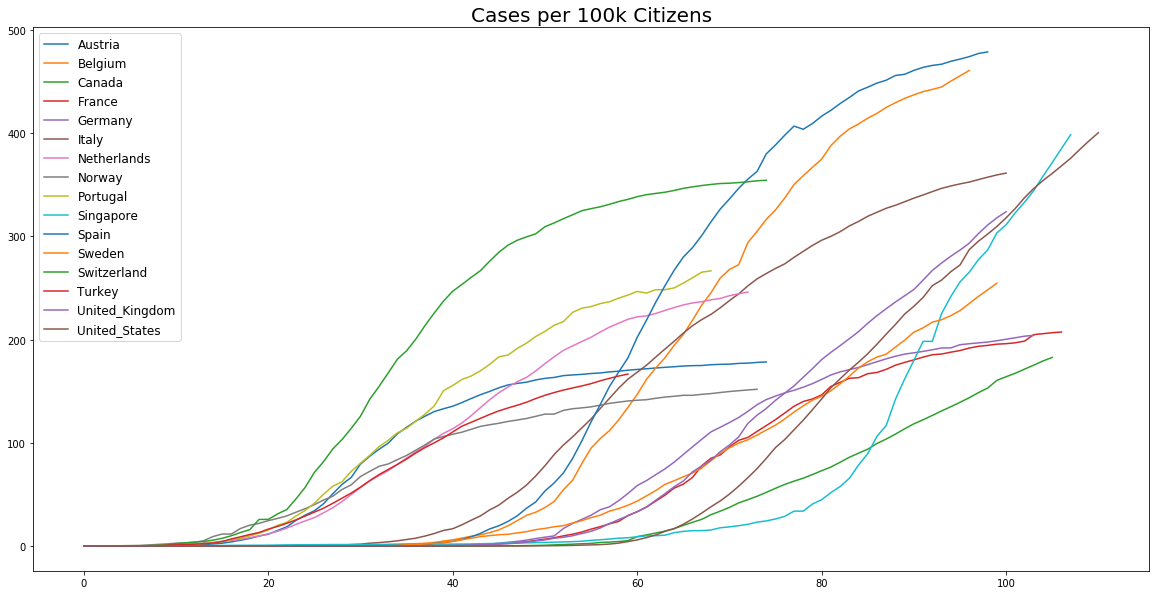

In [27]:
# Plot country growth curves to visualize shape
plt.figure(figsize=(20,10))
for c in growth_curve.country.unique():
    plt.plot(growth_curve.loc[growth_curve.country == c,
                             ['days_since_zero', 'cases_per100k']]
                             .set_index('days_since_zero'),
                             label=c)

plt.title('Cases per 100k Citizens', size=20)
plt.legend(fontsize=12, loc=2)
plt.show()

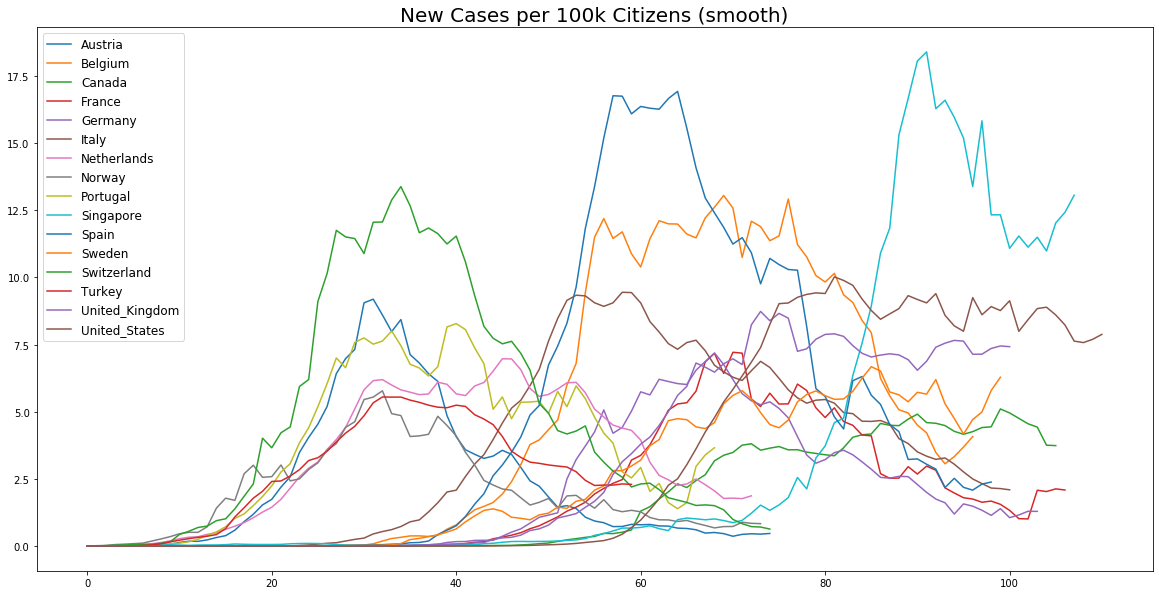

In [28]:
# Plot country growth curves to visualize shape
plt.figure(figsize=(20,10))
for c in growth_curve.country.unique():
    plt.plot(growth_curve.loc[growth_curve.country == c,
                             ['days_since_zero', 'new_cases_per100k_smooth']]
                             .set_index('days_since_zero'),
                             label=c)

plt.title('New Cases per 100k Citizens (smooth)', size=20)
plt.legend(fontsize=12, loc=2)
plt.show()

#### Prepare additional dataframes for enrichment
I.e. combine the different datasets into one for training and prediction.

In [29]:
### Create structured testing dataframe
testing_curve = testing_raw[['date', 'country', 'tests', 'new_tests']]

# Translate date column to datetime for joining
testing_curve.loc[:, 'date'] = pd.to_datetime(testing_raw['date'])

# Merge to Growth Curve All
growth_curve_all = growth_curve.merge(testing_curve, how='left', on=['date', 'country'])
assert len(growth_curve_all) == len(growth_curve)


# Impute zeroes for new tests
growth_curve_all.loc[:, 'new_tests'] = growth_curve_all.new_tests.fillna(0)

# Forward fill recently missing date for tests
print('Original missing tests:', growth_curve_all.tests.isna().sum())
# Within each country, forward-fill after first non-missing total tests
growth_curve_all.loc[:, 'tests'] = growth_curve_all.groupby('country')['tests'].transform(lambda x: x.ffill())
print('After forward-filling:', growth_curve_all.tests.isna().sum())
# Then impute 0 for any remaining missing tests, as that will be because testing was not yet performed
growth_curve_all.tests.fillna(0, inplace = True)
print('After imputing zeros:', growth_curve_all.tests.isna().sum())

# Derive new standardized columns
growth_curve_all['tests_per100k'] = growth_curve_all.tests / growth_curve_all.population_2018
growth_curve_all['new_tests_per100k'] = growth_curve_all.new_tests / growth_curve_all.population_2018

growth_curve_all.tail(7)

Original missing tests: 788
After forward-filling: 497
After imputing zeros: 0


country       date  new_cases  new_deaths  days_since_zero  \
1451  United_States 2020-05-04      24972        1297              104   
1452  United_States 2020-05-05      22593        1252              105   
1453  United_States 2020-05-06      23841        2144              106   
1454  United_States 2020-05-07      24128        2353              107   
1455  United_States 2020-05-08      28369        2239              108   
1456  United_States 2020-05-09      26957        1510              109   
1457  United_States 2020-05-10      25612        1614              110   

        cases  deaths  population_2018   day_zero  cases_per100k  \
1451  1158041   67682      327167434.0 2020-01-21     353.959740   
1452  1180634   68934      327167434.0 2020-01-21     360.865379   
1453  1204475   71078      327167434.0 2020-01-21     368.152473   
1454  1228603   73431      327167434.0 2020-01-21     375.527290   
1455  1256972   75670      327167434.0 2020-01-21     384.198386   
1456  1283929   77180      327167434.0 2020-01-21     392.437898   
1457  1309541   78794      327167434.0 2020-01-21     400.266305   

      new_cases_per100k  new_deaths_per100k  new_cases_smooth  \
1451           7.632789            0.396433           29091.6   
1452           6.905638            0.382679           28145.0   
1453           7.287094            0.655322           26929.8   
1454           7.374817            0.719204           24964.4   
1455           8.671095            0.684359           24780.6   
1456           8.239512            0.461537           25177.6   
1457           7.828408            0.493325           25781.4   

      new_cases_per100k_smooth      tests  new_tests  tests_per100k  \
1451                  8.891961  7285374.0   232008.0       0.022268   
1452                  8.602629  7544328.0   258954.0       0.023060   
1453                  8.231198  7786793.0   242465.0       0.023801   
1454                  7.630466  8105513.0   318720.0       0.024775   
1455                  7.574287  8408788.0   303275.0       0.025702   
1456                  7.695631  8709630.0   300842.0       0.026621   
1457                  7.880185  8709630.0        0.0       0.026621   

      new_tests_per100k  
1451           0.000709  
1452           0.000792  
1453           0.000741  
1454           0.000974  
1455           0.000927  
1456           0.000920  
1457           0.000000

In [30]:
# Create necessary mobility dataframe from just Apple
apple_long = apple_raw.drop(['geo_type', 'alternative_name'], axis = 1)

# Filter to only target countries
apple_long = apple_long.loc[apple_long.country.isin(growth_curve_all.country.unique())]

# Transpose date columns to rows
apple_long = apple_long.melt(id_vars = ['country', 'transportation_type'], var_name = 'date')
apple_long.sort_values(['country', 'date', 'transportation_type'])
apple_long.loc[:, 'date'] = pd.to_datetime(apple_long['date'])
# display(apple_long.shape)
display(apple_long.head(3))

# Translate so each row is country and date
apple_long = apple_long.pivot_table(values = 'value', index = ['country', 'date'], columns = 'transportation_type')
# Split back out original columns
apple_long = apple_long.reset_index()
# display(apple_long.shape)
# display(apple_long.head(3))

# Remove transit since missing lots of data
apple_long.drop(['transit'], axis = 1, inplace = True)

# Rename columns
apple_long.columns = ['country', 'date', 'mobility_drive', 'mobility_walk']

# Drop duplicates
apple_long.drop_duplicates(subset = ['country', 'date'], inplace = True)

# Merge to Growth Curve All
growth_curve_all = growth_curve_all.merge(apple_long, how = 'left', on = ['date', 'country'])
display(growth_curve_all.shape)

print('Total missing values:', growth_curve_all.isna().sum().sum())
print('Columns missing values:', list(growth_curve_all.isna().sum().index[growth_curve_all.isna().sum() > 0]))

# Fill forward missing values
growth_curve_all.fillna(method = 'ffill', inplace = True)

country transportation_type       date  value
0  Austria             driving 2020-01-13  100.0
1  Austria             walking 2020-01-13  100.0
2  Belgium             driving 2020-01-13  100.0

(1458, 20)

Total missing values: 62
Columns missing values: ['mobility_drive', 'mobility_walk']


In [31]:
# Display final dataframe
print(growth_curve_all.shape)
growth_curve_all.tail(7)

(1458, 20)


country       date  new_cases  new_deaths  days_since_zero  \
1451  United_States 2020-05-04      24972        1297              104   
1452  United_States 2020-05-05      22593        1252              105   
1453  United_States 2020-05-06      23841        2144              106   
1454  United_States 2020-05-07      24128        2353              107   
1455  United_States 2020-05-08      28369        2239              108   
1456  United_States 2020-05-09      26957        1510              109   
1457  United_States 2020-05-10      25612        1614              110   

        cases  deaths  population_2018   day_zero  cases_per100k  \
1451  1158041   67682      327167434.0 2020-01-21     353.959740   
1452  1180634   68934      327167434.0 2020-01-21     360.865379   
1453  1204475   71078      327167434.0 2020-01-21     368.152473   
1454  1228603   73431      327167434.0 2020-01-21     375.527290   
1455  1256972   75670      327167434.0 2020-01-21     384.198386   
1456  1283929   77180      327167434.0 2020-01-21     392.437898   
1457  1309541   78794      327167434.0 2020-01-21     400.266305   

      new_cases_per100k  new_deaths_per100k  new_cases_smooth  \
1451           7.632789            0.396433           29091.6   
1452           6.905638            0.382679           28145.0   
1453           7.287094            0.655322           26929.8   
1454           7.374817            0.719204           24964.4   
1455           8.671095            0.684359           24780.6   
1456           8.239512            0.461537           25177.6   
1457           7.828408            0.493325           25781.4   

      new_cases_per100k_smooth      tests  new_tests  tests_per100k  \
1451                  8.891961  7285374.0   232008.0       0.022268   
1452                  8.602629  7544328.0   258954.0       0.023060   
1453                  8.231198  7786793.0   242465.0       0.023801   
1454                  7.630466  8105513.0   318720.0       0.024775   
1455                  7.574287  8408788.0   303275.0       0.025702   
1456                  7.695631  8709630.0   300842.0       0.026621   
1457                  7.880185  8709630.0        0.0       0.026621   

      new_tests_per100k  mobility_drive  mobility_walk  
1451           0.000709           78.01          63.27  
1452           0.000792           80.55          64.79  
1453           0.000741           81.47          64.32  
1454           0.000974           85.85          68.90  
1455           0.000927           95.56          73.57  
1456           0.000920           95.56          73.57  
1457           0.000000           95.56          73.57

#### Prepare Growth Curve dataframe for supervised learning

In [32]:
# Filter to identified best predictors
predictors = ['days_since_zero', 'new_tests_per100k', 'tests_per100k',
              'new_deaths_per100k', 'cases_per100k', 'mobility_walk',
              'mobility_drive', 'new_cases_per100k_smooth']
features = len(predictors)
print(f"Keeping {features} features")

Keeping 8 features


#### Structure as sequences

In [33]:
# Define parameters for predictions length
days_train = 14
days_pred = 7

In [34]:
# Available variables
for i, var in enumerate(predictors):
    print(i, var)

0 days_since_zero
1 new_tests_per100k
2 tests_per100k
3 new_deaths_per100k
4 cases_per100k
5 mobility_walk
6 mobility_drive
7 new_cases_per100k_smooth


In [35]:
# Initalize empty arrays
train_x = np.zeros((0, days_train, features))
train_y = np.zeros((0, days_pred))

# Define response
response = predictors[7]
response_scale = max(response)
print(response)

# Scale data for improved accuracy
growth_curve_scaled = scale(growth_curve_all[predictors])

# For each country, create a supervised version of the data
for country in growth_curve_all.country.unique():
    print(country)
    # Filter to a target country
    gc_country = growth_curve_scaled[growth_curve_all.country == country]
    
    # Create x/y split
    gc_x, gc_y = structure_supervised(gc_country, response, days_train, days_pred)
    
    # Add to overall x/y_train
    train_x = np.concatenate((train_x, gc_x), axis = 0)
    train_y = np.concatenate((train_y, gc_y), axis = 0)

print(train_x.shape, train_y.shape)

new_cases_per100k_smooth
Austria
Belgium
Canada
France
Germany
Italy
Netherlands
Norway
Portugal
Singapore
Spain
Sweden
Switzerland
Turkey
United_Kingdom
United_States
(1138, 14, 8) (1138, 7)


#### Define plotting helper functions

In [36]:
# Define function to plot all countries and their predictions
def plot_countries(model, response, ncols=4):
    
    # Define flexible plot shape
    country_count = len(growth_curve_all.country.unique())
    ncols = ncols
    nrows = int(np.floor(country_count/ncols))
    cut = country_count % nrows
    print(f"Plotting {country_count} countries on {ncols}x{nrows} grid with {cut} left out")

    fig, ax = plt.subplots(nrows, ncols, figsize=(20,5*nrows))
    
    # For each country, generate supervised structure and predictions
    row_idx = -1
    for i, c in enumerate(growth_curve_all.country.unique()):
        if i % ncols == 0:
            row_idx+=1
        if i+1 > (ncols*nrows):
            break

        gc_c = growth_curve_scaled[growth_curve_all.country == c]

        c_x, c_y = structure_supervised(gc_c, response, days_train, days_pred)

        # Calculate country-specific 2018 population to re-scale data
        c_pop = growth_curve_all[growth_curve_all.country == c]['population_2018'].iloc[0]
        max_count = max(growth_curve_all['new_cases_per100k_smooth'])
        
        c_obs = []
        for j in range(len(c_x)):
            c_obs.append(c_x[j, -1, -1])
        c_obs = np.array(c_obs) * max_count #* (c_pop/100000)

        c_pred = model.predict(c_x)
        c_pred = c_pred * max_count #* (c_pop/100000)

        ax[row_idx, i%ncols].plot(np.arange(len(c_obs)), np.array(c_obs), label = 'Observed')

        for j in range(len(c_pred)):
            ax[row_idx, i%ncols].plot(np.arange(j+1, j+1+c_pred.shape[-1]), c_pred[j, :], c = 'orange')

        ax[row_idx, i%ncols].set_title(c)
    plt.suptitle("Case Growth Predictions for Target Nations On Days Since First Case", fontsize=20, color='#237AB4')
    ax[0,0].set_ylabel("New cases per 100k citizens per day", fontsize=15, color='#237AB4')
    fig.subplots_adjust(top=0.93, hspace=0.25)

In [37]:
# Define function to plot USA specific data
def plot_usa_last(model, shift = 0):
    pred = model.predict(usa_x)
    # Calculate numbers for re-scaling
    usa_pop = growth_curve_all[growth_curve_all.country == 'United_States']['population_2018'].iloc[0]
    max_count = max(growth_curve_all['new_cases_per100k_smooth'])
    pred = pred * max_count #* (usa_pop/100000)
    pred.shape

    cas_obs = []
    for i in range(len(usa_x)):
        cas_obs.append(usa_x[i, -1, -1])
    cas_obs = np.array(cas_obs) * max_count #* (usa_pop/100000)

    plt.figure(figsize = (20,10))
    plt.plot(np.arange(shift, len(cas_obs)), cas_obs[shift:], label = 'Observed')

    for i in range(shift, len(pred)):
        if i == len(pred)-1:
            plt.plot(np.arange(i, i+pred.shape[-1]), pred[i, :], 
                     c = 'orange', ls = 'dashed', alpha = 1, label = str(pred.shape[-1])+'-day predictions')
        else:
            plt.plot(np.arange(i, i+pred.shape[-1]), pred[i, :], 
                     c = 'orange', ls = 'dashed', alpha = 1)

    plt.legend()
    plt.title(f"USA Predictions", fontsize=20, color='#237AB4')
    plt.xlabel("Days Since First Case", fontsize=15, color='#237AB4')
    plt.ylabel("New cases per 100k citizens per day", fontsize=15, color='#237AB4')
    plt.show()

In [38]:
# Plot model training history
def plot_training(history):
    plt.figure(figsize = (20,5))
    plt.plot(history.history['loss'], label = 'Training')
    plt.plot(history.history['val_loss'], label = 'Validation')
    plt.title('Training')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

### Define model structures for generalizable model fitting

#### Define prediction weights based on days in future
Since we are predicting `m` days into the future, our networks' last layer is always a Dense (i.e. fully-connected) layer with `m` nodes. By default these `m` nodes are weighted equally when calculating MSE across the `m` nodes and the observations in each batch.

We experimented extensively with weighting the `m` nodes differently to see whether that helped make the model more accurate for near-term or far-term prediction, but found the best results when we did not alter the weighting scheme. That said, if overall MSE is not top priority, the weighting scheme below can be adjusted to incentivise the model to prioritise accuracy in specific parts of the prediction sequence -- for instance to sacrifice far-future prediction accuracy for greatest accuracy 3 days out.

In [39]:
#cw = dict(zip(np.arange(days_pred), np.linspace(3, 1, days_pred)))
#cw = dict(zip(np.arange(days_pred), np.logspace(0.5, 0, days_pred)))
cw = dict(zip(np.arange(days_pred), np.ones(days_pred)))
display(cw)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}

In [40]:
# Create sample X/Y for United States
gc_usa = growth_curve_scaled[growth_curve_all.country == 'United_States']
print(response)
usa_x, usa_y = structure_supervised(gc_usa, response, days_train, days_pred)

new_cases_per100k_smooth


#### Define Stacked LSTM for Population Level Growth

In [41]:
# Define Stacked LSTM model
stacked_lstm = Sequential(name = 'LSTM_baseline')
stacked_lstm.add(LSTM(256, input_shape=(days_train, features), 
             return_sequences=True, dropout = 0.0, recurrent_dropout = 0.4))
stacked_lstm.add(LSTM(128, 
             return_sequences = False, dropout = 0.0, recurrent_dropout = 0.3))
stacked_lstm.add(Dense(days_pred))

stacked_lstm.compile(optimizer=Adam(learning_rate = 0.001/2), loss='mse', metric = ['rmse'])

stacked_lstm.summary()

Model: "LSTM_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 256)           271360    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 469,383
Trainable params: 469,383
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Fit Simple RNN to target country COVID-19 cases
history_stacked_lstm = stacked_lstm.fit(train_x, train_y, epochs=50, verbose=1, shuffle = True, 
                      batch_size = 64, class_weight = cw, validation_split = 0.1)

Train on 1024 samples, validate on 114 samples
Epoch 1/50
1024/1024 [==============================] - 4s 4ms/sample - loss: 0.0423 - val_loss: 0.0158
Epoch 2/50
1024/1024 [==============================] - 1s 576us/sample - loss: 0.0194 - val_loss: 0.0052
Epoch 3/50
1024/1024 [==============================] - 1s 568us/sample - loss: 0.0148 - val_loss: 0.0049
Epoch 4/50
1024/1024 [==============================] - 1s 555us/sample - loss: 0.0118 - val_loss: 0.0037
Epoch 5/50
1024/1024 [==============================] - 1s 566us/sample - loss: 0.0108 - val_loss: 0.0031
Epoch 6/50
1024/1024 [==============================] - 1s 557us/sample - loss: 0.0097 - val_loss: 0.0033
Epoch 7/50
1024/1024 [==============================] - 1s 563us/sample - loss: 0.0088 - val_loss: 0.0046
Epoch 8/50
1024/1024 [==============================] - 1s 566us/sample - loss: 0.0079 - val_loss: 0.0032
Epoch 9/50
1024/1024 [==============================] - 1s 569us/sample - loss: 0.0076 - val_loss: 0.0060
E

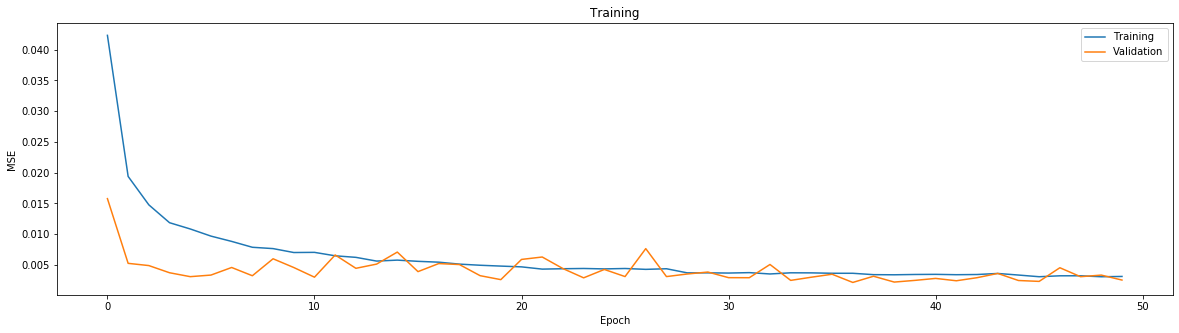

In [43]:
# Plot training history
plot_training(history_stacked_lstm)

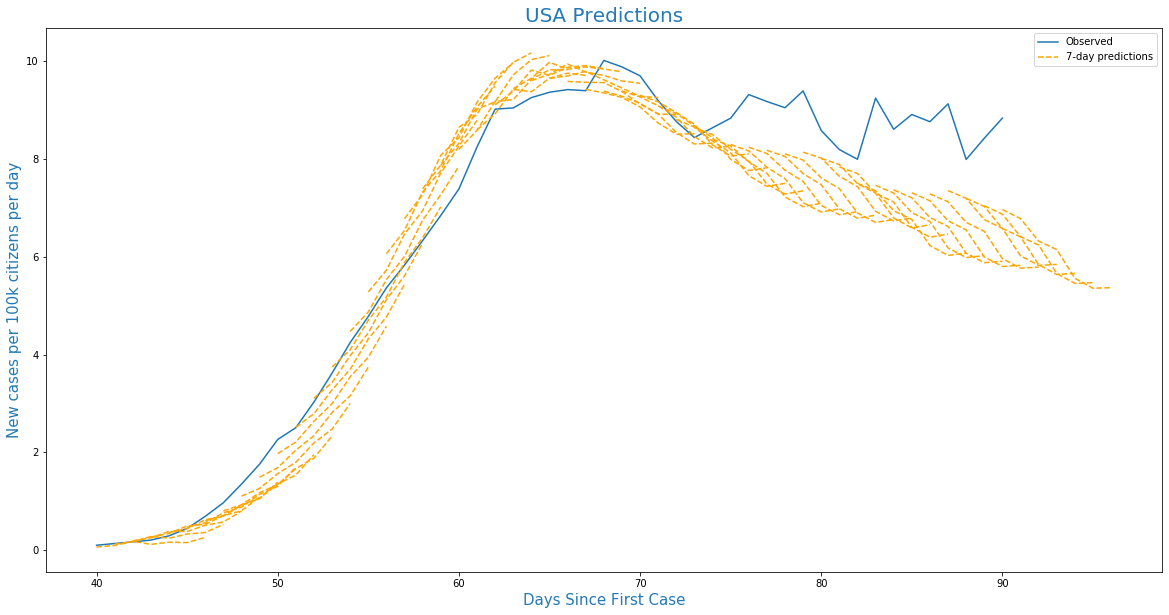

In [44]:
# Plot 7-day model predictions for USA
plot_usa_last(stacked_lstm, 40)

Plotting 16 countries on 3x5 grid with 1 left out


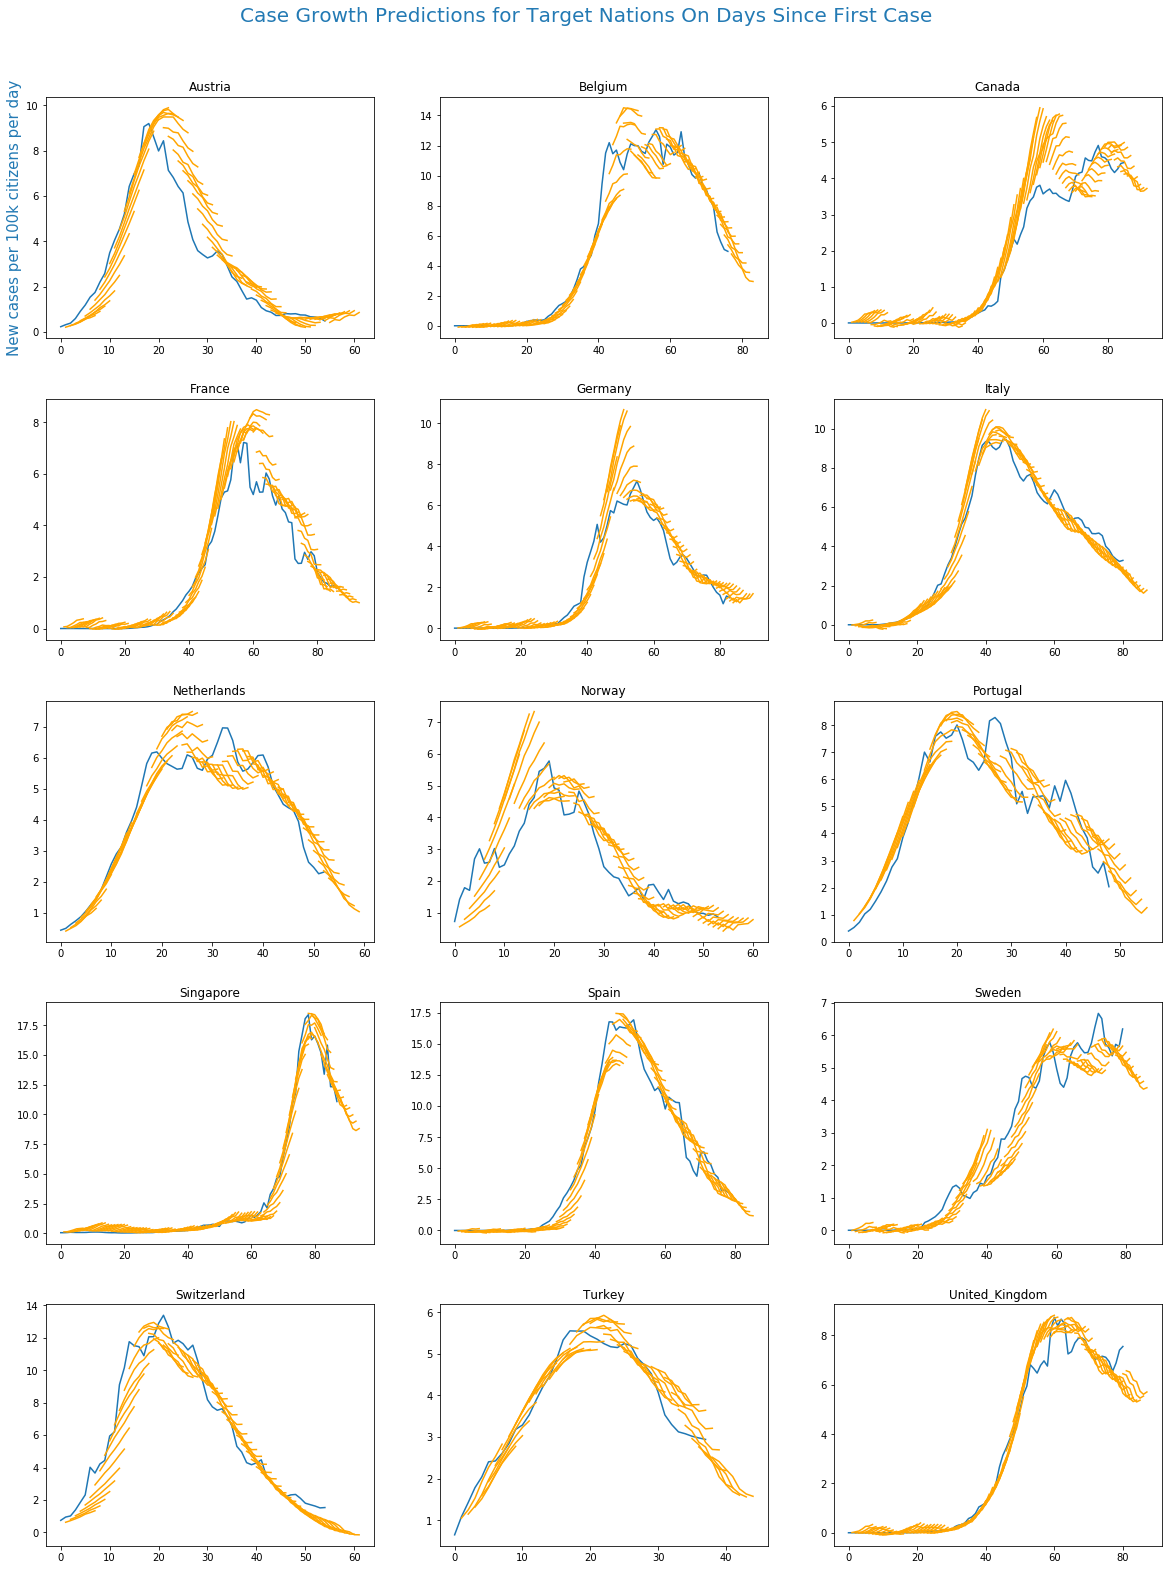

In [45]:
# Plot 7-day model predictions for target countries
plot_countries(stacked_lstm, response, ncols=3)

#### Define 1-D CNN for Population Level Growth

In [46]:
# Define simple 1D CNN model
cnn = Sequential(name = 'CNN_baseline')

cnn.add(Conv1D(filters = 64, kernel_size = 3, activation = 'relu', 
               input_shape=(days_train, features)))
cnn.add(MaxPool1D(pool_size = 2))
cnn.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu'))
cnn.add(MaxPool1D(pool_size = 2))
cnn.add(Flatten())
cnn.add(Dense(256, activation = 'relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(days_pred))

cnn.compile(optimizer=Adam(learning_rate = 0.001/2), loss='mse', metric = ['rmse'])

cnn.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 64)            1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 128)            24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [47]:
# Fit 1D CNN model
history_cnn = cnn.fit(train_x, train_y, epochs=100, verbose=1, 
                      batch_size = 64, class_weight = cw, validation_split = 0.1)

Train on 1024 samples, validate on 114 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0665 - val_loss: 0.0382
Epoch 2/100
1024/1024 [==============================] - 0s 81us/sample - loss: 0.0397 - val_loss: 0.0233
Epoch 3/100
1024/1024 [==============================] - 0s 82us/sample - loss: 0.0265 - val_loss: 0.0129
Epoch 4/100
1024/1024 [==============================] - 0s 82us/sample - loss: 0.0198 - val_loss: 0.0076
Epoch 5/100
1024/1024 [==============================] - 0s 81us/sample - loss: 0.0177 - val_loss: 0.0133
Epoch 6/100
1024/1024 [==============================] - 0s 82us/sample - loss: 0.0164 - val_loss: 0.0206
Epoch 7/100
1024/1024 [==============================] - 0s 81us/sample - loss: 0.0141 - val_loss: 0.0102
Epoch 8/100
1024/1024 [==============================] - 0s 80us/sample - loss: 0.0120 - val_loss: 0.0126
Epoch 9/100
1024/1024 [==============================] - 0s 81us/sample - loss: 0.0113 - val_loss: 0.0165


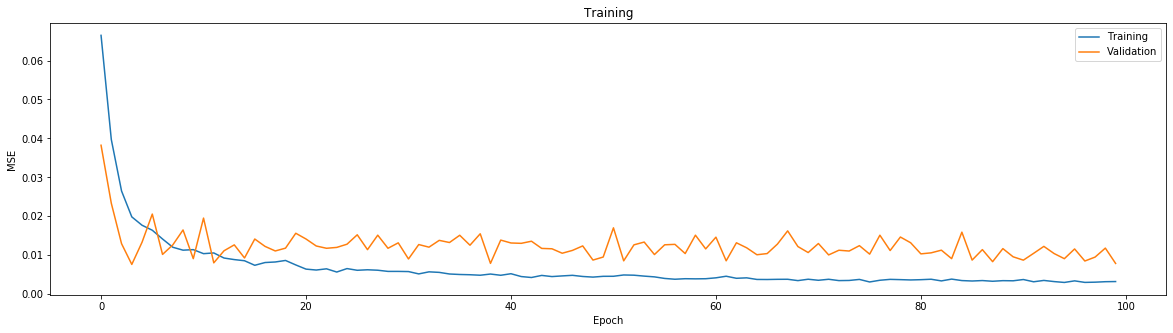

In [48]:
# Plot training history
plot_training(history_cnn)

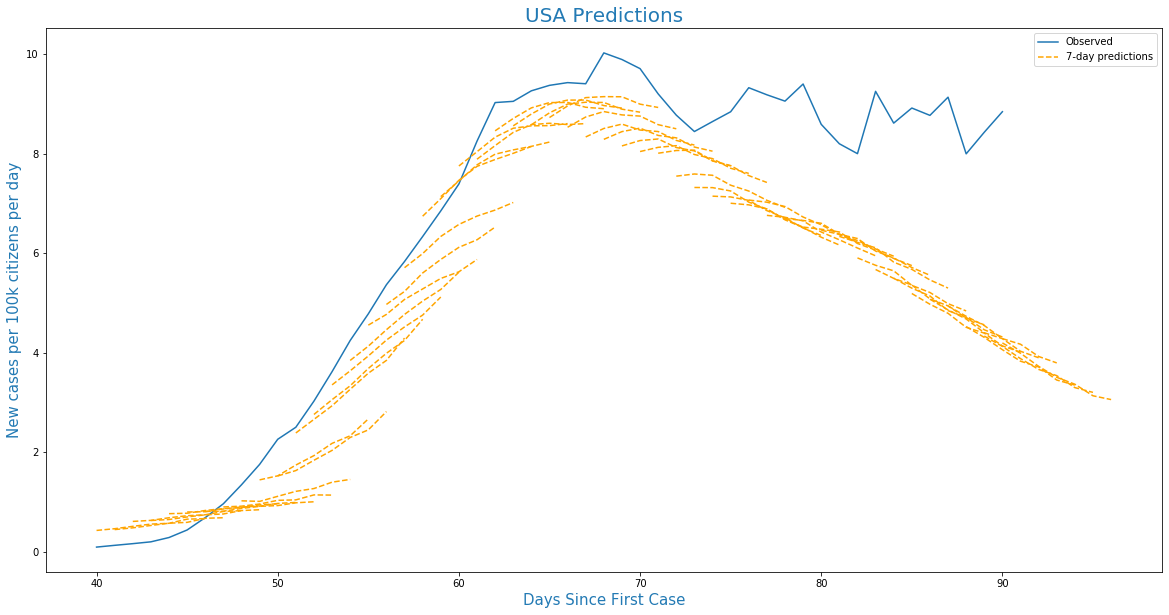

In [49]:
# Plot 7-day model predictions for USA
plot_usa_last(cnn, 40)

Plotting 16 countries on 3x5 grid with 1 left out


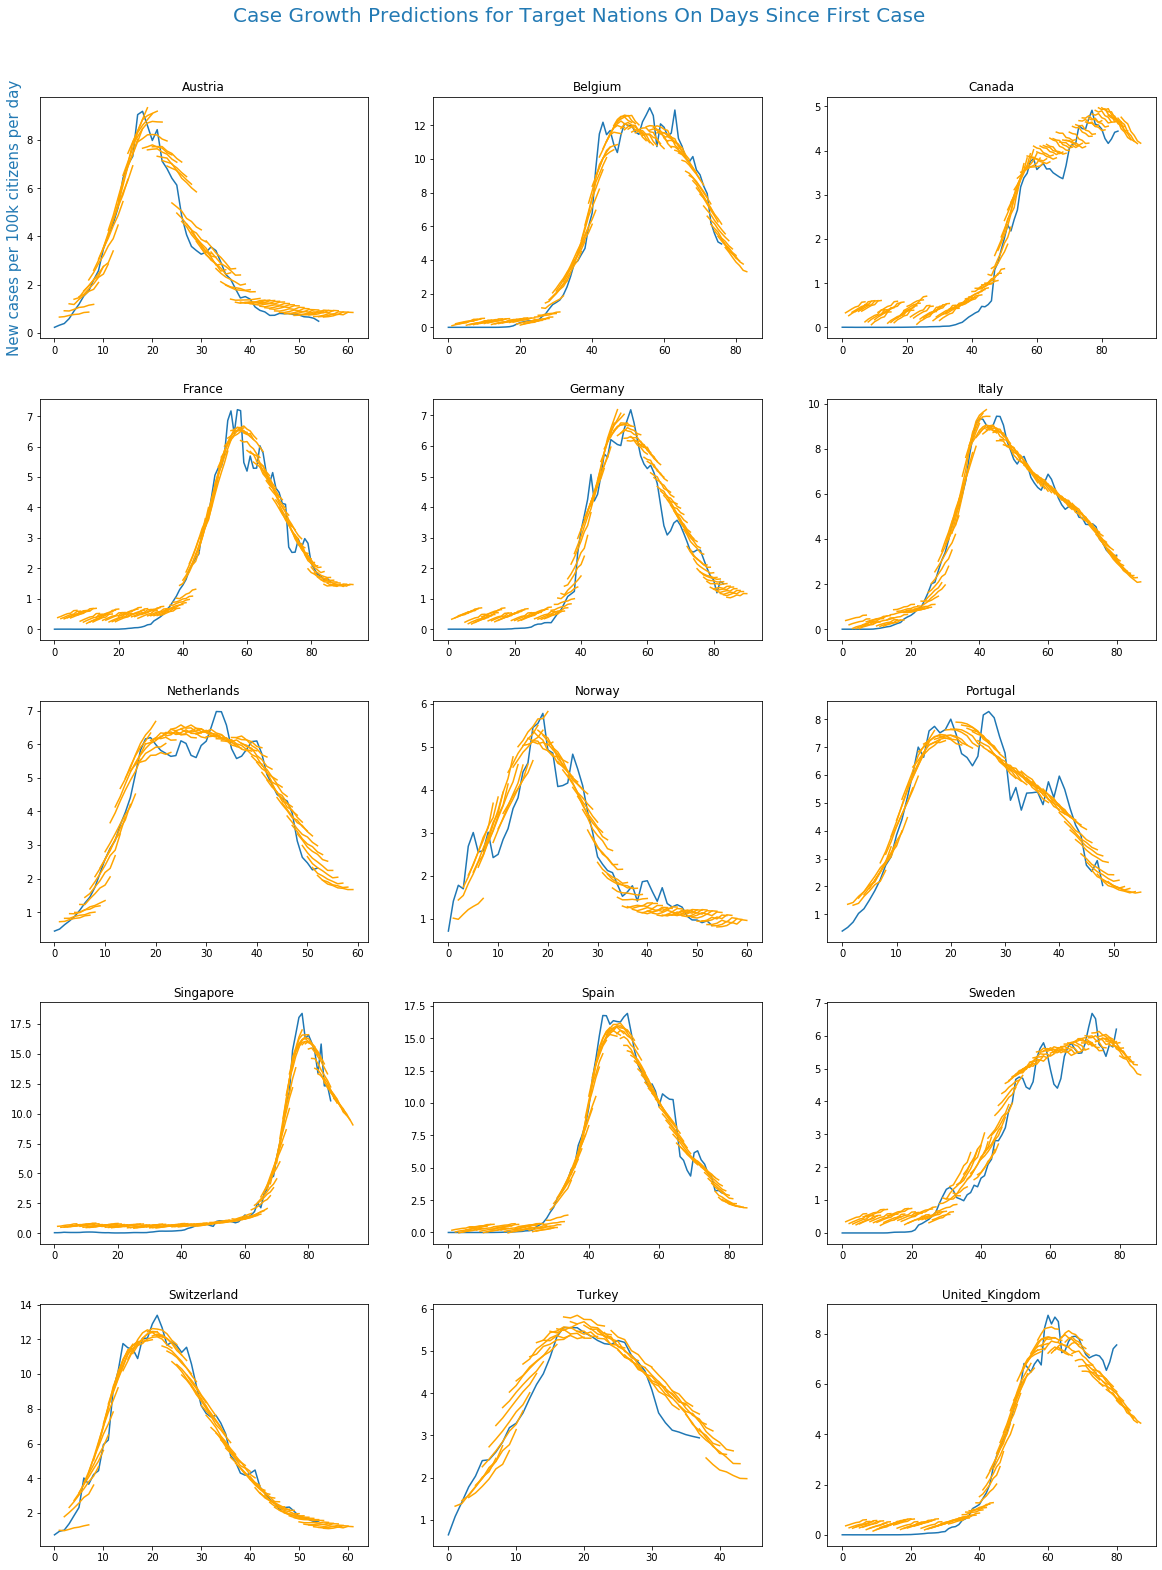

In [50]:
# Plot 7-day model predictions for target countries
plot_countries(cnn, response, ncols=3)

#### Define Combination Network for Population Level Growth

In [51]:
# Define callbacks
cb = [
    ReduceLROnPlateau(monitor = 'val_loss', patience = 10, verbose = 1, factor = 0.5),
    EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
]

In [52]:
# Define model
mul = Sequential(name = 'Multi_Model')

mul.add(Conv1D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu', 
               input_shape=(days_train, features)))
mul.add(Conv1D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu'))
mul.add(LSTM(256, return_sequences = True, recurrent_dropout = 0.5))
mul.add(LSTM(128, recurrent_dropout = 0.4))

mul.add(Dense(64, activation = 'relu'))
mul.add(Dropout(0.3))
mul.add(Dense(32, activation = 'relu'))

mul.add(Dense(days_pred, activation = 'linear'))

mul.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metric = ['rmse'])

mul.summary()

Model: "Multi_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 12, 64)            1600      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 128)           24704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                

In [53]:
# Fit model to X/Y data
history_mul = mul.fit(train_x, train_y, epochs=100, verbose=1, callbacks = cb,
                      batch_size = 8, class_weight = cw, validation_split = 0.15)

Train on 967 samples, validate on 171 samples
Epoch 1/100
967/967 [==============================] - 8s 8ms/sample - loss: 0.0231 - val_loss: 0.0078
Epoch 2/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0108 - val_loss: 0.0073
Epoch 3/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0104 - val_loss: 0.0184
Epoch 4/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0078 - val_loss: 0.0114
Epoch 5/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 6/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0055 - val_loss: 0.0056
Epoch 7/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0052 - val_loss: 0.0067
Epoch 8/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0045 - val_loss: 0.0071
Epoch 9/100
967/967 [==============================] - 4s 4ms/sample - loss: 0.0041 - val_loss: 0.0071
Epoch 10/100
967/967 [=====

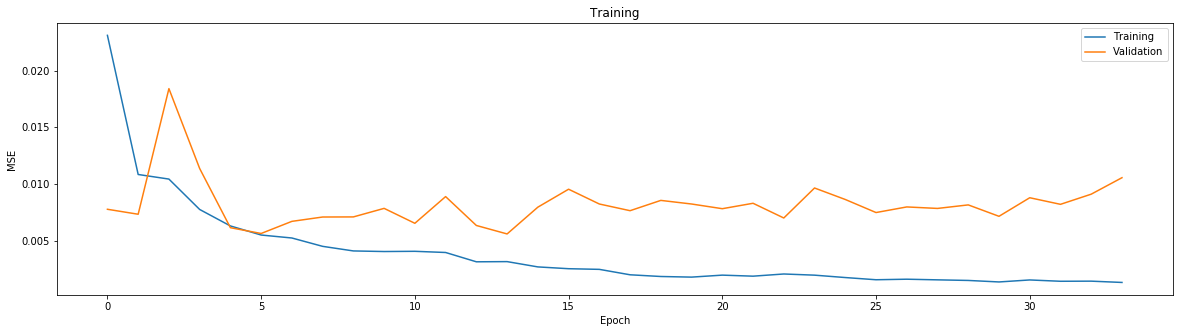

In [54]:
# Plot training history
plot_training(history_mul)

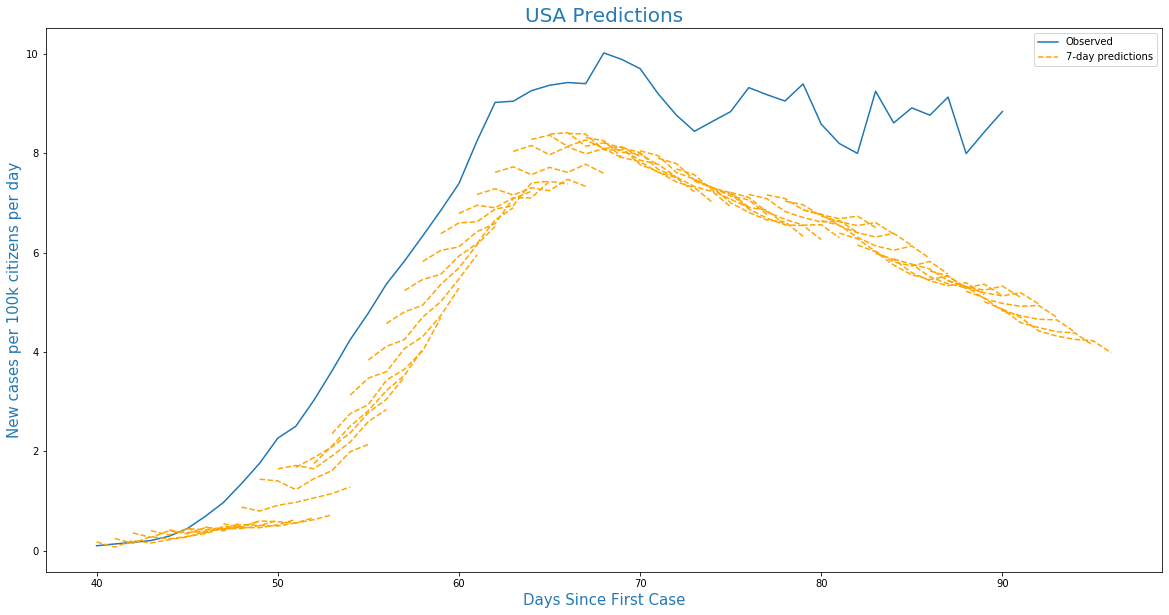

In [55]:
# Plot 7-day model predictions for USA
plot_usa_last(mul, 40)

Plotting 16 countries on 3x5 grid with 1 left out


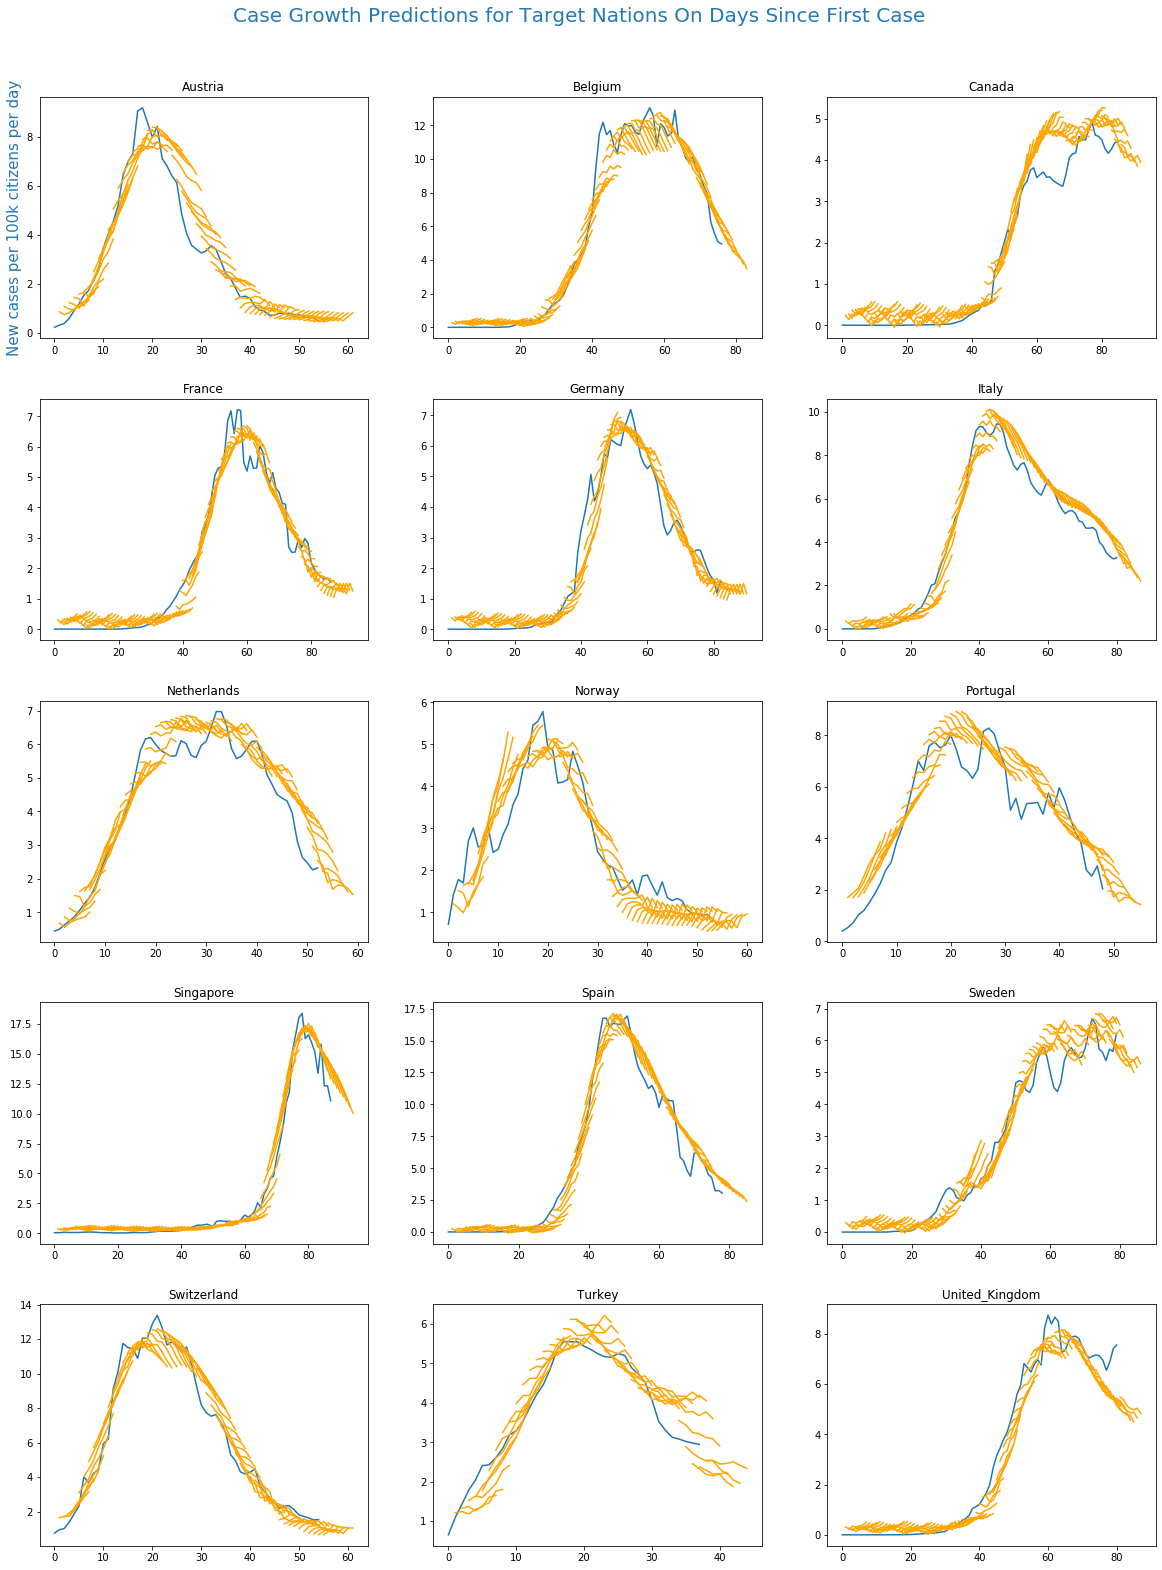

In [56]:
# Plot 7-day model predictions for target countries
plot_countries(mul, response, ncols=3)

## Generalizable COVID-19 Model Conclusion

We achieve the best fit curves and loss using a combination model of CNN and LSTM, with dropout to the recurrent activations of the LSTM layers and the Dense layers towards the end. We train on 14-day windows of data, predicting 7 days ahead. The network learns and can reasonably reproduce a number of differently shaped growth curves, including those with multiple local maxima. 

The model learns to map 14-day histories to 7-day predictions into the future based on a country's case, testing, and mobility data, but with no explicit mapping to specific countries. It is a general model meant to make predictions for 7 days based on the preceding 2 weeks, and thus tries to learn how these relationships generally unfold. The plotted predictions therefore do not rely on those of the preceding sequence, as they are independent, hence these lines look somewhat jagged; every round of prediction is made without other context than the preceding 14 days of inputs. This can be improved in future work, but in this case our goal was to make a general country-agnostic and history-agnostic predictor. It is therefore interesting how closely it generally follows the curves, and the extent to which it seems able to anticipate spikes.

It also appears that the model is successfully able to alert to undiagnosed case load increases. In Norway at day 10, Canada at day 60, Sweden at day 60 and the Netherlands at day 20, the model suggests a higher than reported number of new cases per 100k citizens that is subsequently validated by dramatic spikes within 5-10 days after that. Judging by the shape of the data, these almost look like the government caught up on belated or missing measurements. 

One counter example may be Germany, where the model appears to be predicting continual rapid growth when the curve is really peaking. We think this is actual a correct prediction contrary to that small but sudden drop in Germany's rising curve, where our model predicted continued growth in spite of the drop. Following that, the model adjusts and almost perfectly predicts Germany's peak.

In countries like Italy, Switzerland, France and Spain, the model does very well aligning with those nation's peaks and keeping ahead of the decline in caseload. The United States remains a problematic outlier. Because the country plateaued in its efforts to contain and combat the virus during April, there has been a persistent and stable new case growth for multiple weeks. This trend goes against that experienced by nearly every other impacted nation and makes a generalizable model extremely difficult to apply to the American experience. 

This appears to also be occurring in the United Kingdom, which within the past 5 days is seeing a separation between growth expected by other nations and the case growth observed. In this scenario, our recommendation would be to use this model to identify outlier nations who continue to experience difficulty as a way of flagging those whose response is not yet sufficient or who were successfully on trend but may have elected to re-open too soon. The fact that the model continues to predict a declining caseload for the UK means the UK has more cases than countries with comparable 14-day histories of case, test, and mobility data.

------

--------

# Predicting a Country's Case Growth

We next turn to the challenge of accurately predicting a target country's case or death growth using a variety of methods. We restructure our alternate time series before running a number of experiments to determine the optimum approach and training data

#### Define data structuring helper functions

In [57]:
# Define function to generate multivariate time series dataframe
def generate_multivariate_df(dataframe, rollup_column: str, metric_column: str, country_column='country', fillna=False):
    # Generate list of unique countries to iterate through
    unique_countries_in_df = dataframe[country_column].unique()
    
    # Create starting series with index as unique values from dataframe
    base_series = pd.Series(index=np.sort(dataframe[rollup_column].unique()))
    
    # Iterate through countries and add time series to base_series
    for country in unique_countries_in_df:
        country_series = dataframe[dataframe[country_column] == country].groupby(rollup_column)[metric_column].mean().rename(country)
        base_series = pd.concat([base_series, country_series], axis=1, sort=False)
    base_series = base_series.drop(0, axis=1)
    if fillna == True:
        base_series = base_series.fillna(0)
    
    return base_series

In [58]:
# Define function to filter dataframe to target countries
def filter_to_target_countries(dataframe):
    
    return dataframe[dataframe.columns[dataframe.columns.isin(target_countries)]]

### Structure testing data

In [59]:
# Create OurWorldInData testing by date dataframe
testing = generate_multivariate_df(testing_raw, 'date', 'tests', fillna=False)

testing = standardize_country_names(testing)

testing = filter_to_target_countries(testing)

In [60]:
## Some countries only report testing numbers on a weekly basis.
## For those, we forward fill their weekly reported number for each subsequent day until a new number is reported.
## These means we have a step curve, but it helps standardize time series for smoother learning.

# Forward fill recently missing date for tests
print('Original missing tests:')
missing_original = testing.isna().sum()

# Within each country, forward-fill after first non-missing total tests
testing = testing.transform(lambda x: x.ffill())
print('After forward-filling:')
missing_ff = testing.isna().sum()

# Then impute 0 for any remaining missing tests, as that will be because testing was not yet performed
testing.fillna(0, inplace = True)
print('After imputing zeros:')
missing_zeros = testing.isna().sum()

missing_nums = pd.concat([
    missing_original.rename('Original'),
    missing_ff.rename('Forward Fill'),
    missing_zeros.rename('Impute Zeros and End')
], axis=1)
display(missing_nums)

Original missing tests:
After forward-filling:
After imputing zeros:


Original  Forward Fill  Impute Zeros and End
Austria               57            55                     0
Belgium               62            60                     0
Canada                79            77                     0
France               107            54                     0
Germany              122            67                     0
Italy                 55            54                     0
Netherlands          119            74                     0
Norway                83            75                     0
Portugal              65            60                     0
Singapore            126            97                     0
Spain                127           103                     0
Sweden               121            60                     0
Switzerland           28            23                     0
Turkey                79            77                     0
United_Kingdom        97            96                     0
United_States         67            66                     0

In [61]:
# Display preview of table
testing.tail(3)

Austria   Belgium     Canada    France    Germany      Italy  \
2020-05-08  304069.0  461303.0  1032012.0  831174.0  2755770.0  2445063.0   
2020-05-09  311690.0  461303.0  1067595.0  831174.0  2755770.0  2514234.0   
2020-05-10  316508.0  461303.0  1071379.0  831174.0  2755770.0  2514234.0   

            Netherlands    Norway  Portugal  Singapore      Spain    Sweden  \
2020-05-08     254456.0  195921.0  485925.0   175604.0  1625211.0  148500.0   
2020-05-09     254456.0  195921.0  485925.0   175604.0  1625211.0  148500.0   
2020-05-10     254456.0  195921.0  485925.0   175604.0  1625211.0  148500.0   

            Switzerland     Turkey  United_Kingdom  United_States  
2020-05-08     309206.0  1298806.0       1631561.0      8408788.0  
2020-05-09     309595.0  1334411.0       1728443.0      8709630.0  
2020-05-10     309595.0  1334411.0       1728443.0      8709630.0

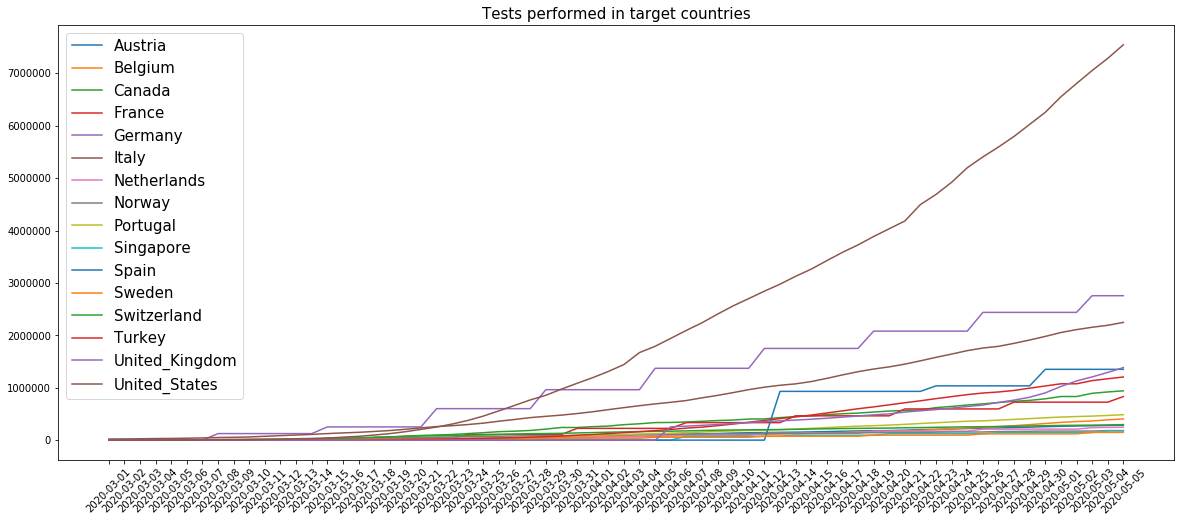

In [62]:
# Plot US testing numbers
plt.figure(figsize=(20,8))
for i in range(len(testing.columns)):
    plt.plot(testing.iloc[60:-5, i], label=testing.columns[i])
plt.legend(fontsize=15)
plt.title("Tests performed in target countries", fontsize=15)
plt.xticks(rotation=45)
plt.show()

### Structure Apple mobility data

In [63]:
# Create Apple Mobility by date dataframe
apple_overall = round(np.transpose(apple_raw.groupby('country').agg('mean')), 3)

apple_overall = standardize_country_names(apple_overall)

apple_overall = filter_to_target_countries(apple_overall)

apple_overall.tail()

country     Austria  Belgium  Canada  France  Germany   Italy  Netherlands  \
2020-05-04   64.350   51.920  53.397  27.950   65.910  32.887       52.050   
2020-05-05   63.555   53.990  57.403  29.433   67.893  33.463       55.383   
2020-05-06   67.580   58.030  59.160  31.250   70.387  33.633       57.353   
2020-05-07   71.145   59.153  57.887  31.980   72.647  34.437       59.143   
2020-05-08   73.565   60.973  61.907  27.453   75.377  35.737       63.570   

country     Norway  Portugal  Singapore   Spain  Sweden  Switzerland  Turkey  \
2020-05-04  80.397    33.060     26.890  28.693  80.630       66.893  50.785   
2020-05-05  80.463    35.355     27.710  29.203  83.023       62.747  51.225   
2020-05-06  83.473    35.595     27.037  29.270  85.540       68.617  51.760   
2020-05-07  82.640    36.390     29.757  28.357  87.870       72.363  52.185   
2020-05-08  86.350    38.315     30.830  28.873  94.350       75.027  52.025   

country     United_Kingdom  United_States  
2020-05-04          35.853         57.093  
2020-05-05          37.353         58.380  
2020-05-06          39.023         58.420  
2020-05-07          39.627         61.623  
2020-05-08          38.833         66.400

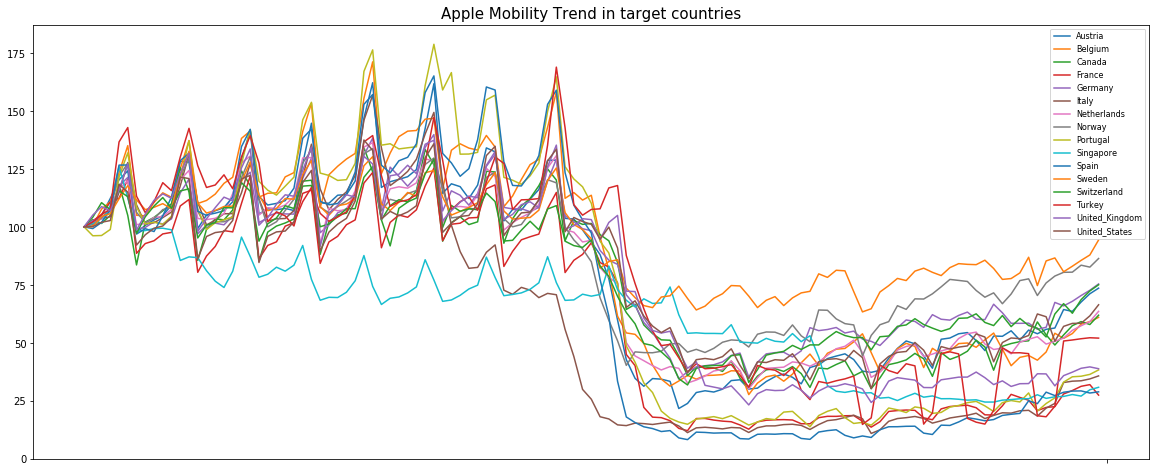

In [64]:
# Plot mobility numbers
plt.figure(figsize=(20,8))
for i in range(len(apple_overall.columns)):
    plt.plot(apple_overall.iloc[:, i], label=apple_overall.columns[i])
plt.legend(fontsize=8)
plt.title("Apple Mobility Trend in target countries", fontsize=15)
plt.xticks("")
plt.show()

### Structure Google mobility data

In [65]:
# Create Google Mobility by date dataframe
google_overall = generate_multivariate_df(google_raw, 'date', 'overall_change_from_baseline', fillna=False)

google_overall = standardize_country_names(google_overall)

google_overall = filter_to_target_countries(google_overall)

google_overall.tail()

Austria   Belgium     Canada  Switzerland    Germany     Spain  \
date                                                                         
2020-04-28 -22.9234 -40.33325 -26.785786   -27.758667 -15.539235 -51.82500   
2020-04-29 -31.7034 -37.83350 -23.565500   -25.465407 -15.774529 -50.62825   
2020-04-30 -19.3100 -33.08300 -23.678643   -29.416111 -13.362765 -48.40170   
2020-05-01 -47.3532 -52.16650 -24.178571   -39.454333 -45.901941 -66.53000   
2020-05-02 -17.9365 -35.66675 -21.480929   -31.025000 -17.029412 -42.79165   

               France  United_Kingdom      Italy  Netherlands     Norway  \
date                                                                       
2020-04-28 -45.654714      -42.187704 -47.333381   -20.858923  -3.652750   
2020-04-29 -45.464429      -40.649020 -45.976238   -15.487308  -0.486250   
2020-04-30 -42.333357      -40.145086 -42.722238   -17.397462   6.722333   
2020-05-01 -63.214357      -38.290645 -65.117571   -21.051231 -22.222250   
2020-05-02 -45.523714      -40.674533 -47.846095   -14.948923  10.597167   

             Portugal     Sweden  Singapore  Turkey  United_States  
date                                                                
2020-04-28 -38.363524  -8.261318    -41.000 -27.500     -21.872843  
2020-04-29 -39.231762  -4.870455    -42.333 -27.500     -21.705272  
2020-04-30 -34.717476  -3.200773    -42.333 -21.000     -21.579472  
2020-05-01 -55.710286 -31.125818    -43.333 -58.833     -18.734739  
2020-05-02 -43.756333  -3.243136    -41.000 -63.167     -11.273210

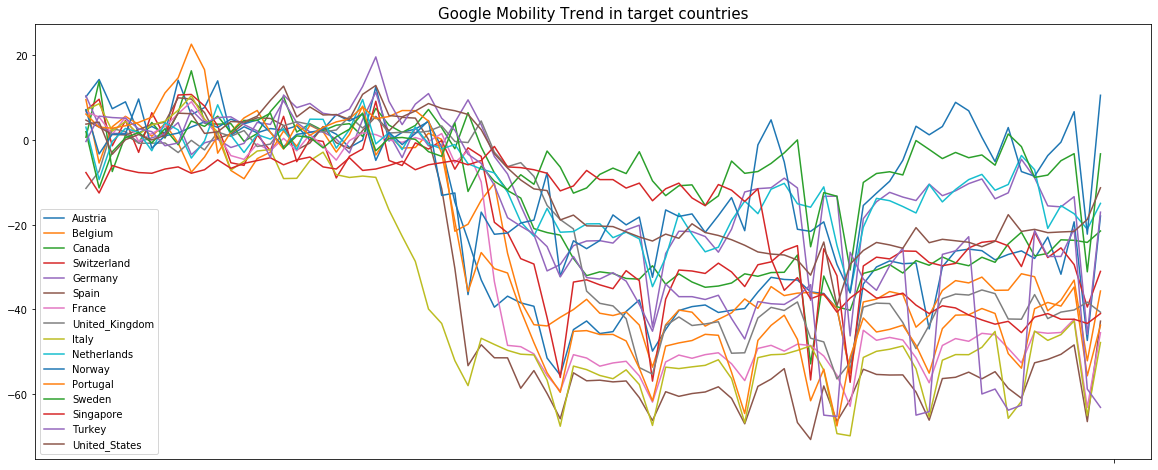

In [66]:
# Plot mobility numbers
plt.figure(figsize=(20,8))
for i in range(len(google_overall.columns)):
    plt.plot(google_overall.iloc[:, i], label=google_overall.columns[i])
plt.legend(fontsize=10)
plt.title("Google Mobility Trend in target countries", fontsize=15)
plt.xticks("")
plt.show()

### Structure case data for supervised learning

In [67]:
# Define starting response column
response = 'new_cases_smooth'

#### Create date-indexed case dataframe

In [68]:
cases_date = generate_multivariate_df(ecdc_country, 'date', response, fillna=True)

cases_date = standardize_country_names(cases_date)

cases_date = filter_to_target_countries(cases_date)

cases_date.tail(3)

Austria  Belgium  Canada  France  Germany   Italy  Netherlands  \
2020-05-08     40.6    380.6  1641.6  1360.0    960.8  1306.0        307.6   
2020-05-09     39.4    421.0  1392.0  1426.8   1075.2  1293.6        304.4   
2020-05-10     41.6    465.8  1386.0  1398.2   1071.6  1266.0        322.4   

            Norway  Portugal  Singapore   Spain  Sweden  Switzerland  Turkey  \
2020-05-08    47.2     305.0      678.2  1078.2   508.2         61.8  1869.2   
2020-05-09    45.0     348.8      700.4  1113.4   589.6         60.4  1904.8   
2020-05-10    44.4     376.4      736.4     0.0   640.0         54.0  1891.2   

            United_Kingdom  United_States  
2020-05-08          4891.0        24780.6  
2020-05-09          4953.0        25177.6  
2020-05-10          4935.2        25781.4

#### Create Integrated Dataframe

In [69]:
# Define function to join response dataframe with additional variables
def enrich_dataframe(dataframe):
    dataframe = dataframe.join(testing, how='outer', lsuffix='_response', rsuffix='_tests')
    dataframe = dataframe.join(apple_overall, how='outer')
    dataframe = dataframe.join(google_overall, how='outer', lsuffix='_apple_mobility', rsuffix='_google_mobility')
    return dataframe

In [70]:
# Enrich cases by date
covid_by_date = enrich_dataframe(cases_date)
covid_by_date.tail(3)

Austria_response  Belgium_response  Canada_response  \
2020-05-08              40.6             380.6           1641.6   
2020-05-09              39.4             421.0           1392.0   
2020-05-10              41.6             465.8           1386.0   

            France_response  Germany_response  Italy_response  \
2020-05-08           1360.0             960.8          1306.0   
2020-05-09           1426.8            1075.2          1293.6   
2020-05-10           1398.2            1071.6          1266.0   

            Netherlands_response  Norway_response  Portugal_response  \
2020-05-08                 307.6             47.2              305.0   
2020-05-09                 304.4             45.0              348.8   
2020-05-10                 322.4             44.4              376.4   

            Singapore_response  ...  France_google_mobility  \
2020-05-08               678.2  ...                     NaN   
2020-05-09               700.4  ...                     NaN   
2020-05-10               736.4  ...                     NaN   

            United_Kingdom_google_mobility  Italy_google_mobility  \
2020-05-08                             NaN                    NaN   
2020-05-09                             NaN                    NaN   
2020-05-10                             NaN                    NaN   

            Netherlands_google_mobility  Norway_google_mobility  \
2020-05-08                          NaN                     NaN   
2020-05-09                          NaN                     NaN   
2020-05-10                          NaN                     NaN   

            Portugal_google_mobility  Sweden_google_mobility  \
2020-05-08                       NaN                     NaN   
2020-05-09                       NaN                     NaN   
2020-05-10                       NaN                     NaN   

            Singapore_google_mobility  Turkey_google_mobility  \
2020-05-08                        NaN                     NaN   
2020-05-09                        NaN                     NaN   
2020-05-10                        NaN                     NaN   

            United_States_google_mobility  
2020-05-08                            NaN  
2020-05-09                            NaN  
2020-05-10                            NaN  

[3 rows x 64 columns]

#### Explore time series range limits

In [71]:
# Confirm range of nulls on mobility
print("Apple:")
print(min(covid_by_date[covid_by_date['United_States_apple_mobility'].isna() == False].index.date),
" => ", max(covid_by_date[covid_by_date['United_States_apple_mobility'].isna() == False].index.date))
print("Google:")
print(min(covid_by_date[covid_by_date['United_States_google_mobility'].isna() == False].index.date),
" => ", max(covid_by_date[covid_by_date['United_States_google_mobility'].isna() == False].index.date))

Apple:
2020-01-13  =>  2020-05-08
Google:
2020-02-15  =>  2020-05-02


In [72]:
# Mobility numbers are updated at a less frequent pace than cases
# To manage a few days delay on mobility, we forward-fill the last mobility number

# Percent null values
null_pcts_pre = round(covid_by_date.isna().sum()/len(covid_by_date)*100, 1)

# Within each country, forward-fill after first non-missing total tests
covid_by_date = covid_by_date.transform(lambda x: x.ffill())
null_pcts_post = round(covid_by_date.isna().sum()/len(covid_by_date)*100, 1)

null_pcts = pd.concat([null_pcts_pre.rename('Pre'), null_pcts_post.rename('Post')], axis=1)
display(null_pcts[(null_pcts['Pre'] > 0) & (null_pcts.index.str.contains('Norway'))])

Pre  Post
Norway_tests             0.8   0.8
Norway_apple_mobility   11.4   9.8
Norway_google_mobility  40.9  34.8

In [73]:
# Define function to filter dataframe to specific range
def filter_range(dataframe, start, end):
    return dataframe[(dataframe.index >= start) & (dataframe.index <= end)]

In [74]:
# Filter to non-null range since unable to impute mobility
covid_ranged = filter_range(covid_by_date, '2020-02-15', '2020-05-02')
display(covid_ranged.head(3))
display(covid_ranged.tail(3))

Austria_response  Belgium_response  Canada_response  \
2020-02-15               0.0               0.0              0.2   
2020-02-16               0.0               0.0              0.2   
2020-02-17               0.0               0.0              0.2   

            France_response  Germany_response  Italy_response  \
2020-02-15              0.0               0.4             0.0   
2020-02-16              0.0               0.4             0.0   
2020-02-17              0.2               0.0             0.0   

            Netherlands_response  Norway_response  Portugal_response  \
2020-02-15                   0.0              0.0                0.0   
2020-02-16                   0.0              0.0                0.0   
2020-02-17                   0.0              0.0                0.0   

            Singapore_response  ...  France_google_mobility  \
2020-02-15                 4.8  ...                6.702429   
2020-02-16                 5.4  ...                5.452429   
2020-02-17                 5.6  ...                1.357143   

            United_Kingdom_google_mobility  Italy_google_mobility  \
2020-02-15                      -11.410125               7.047524   
2020-02-16                       -7.373483               8.611190   
2020-02-17                        2.725007               2.111190   

            Netherlands_google_mobility  Norway_google_mobility  \
2020-02-15                     3.051308                7.194500   
2020-02-16                    -9.346154               -3.277833   
2020-02-17                    -0.307692                1.402833   

            Portugal_google_mobility  Sweden_google_mobility  \
2020-02-15                  6.161143                1.997000   
2020-02-16                  3.061952              -11.300045   
2020-02-17                  2.815810               -2.756000   

            Singapore_google_mobility  Turkey_google_mobility  \
2020-02-15                     -7.667                  -0.333   
2020-02-16                    -12.500                   5.667   
2020-02-17                     -6.000                   5.333   

            United_States_google_mobility  
2020-02-15                       3.779464  
2020-02-16                       4.247112  
2020-02-17                      -3.342209  

[3 rows x 64 columns]

Austria_response  Belgium_response  Canada_response  \
2020-04-30              59.2             713.2           1542.0   
2020-05-01              58.0             638.8           1579.0   
2020-05-02              53.8             579.6           1635.4   

            France_response  Germany_response  Italy_response  \
2020-04-30           1173.0            1336.2          2119.4   
2020-05-01           1093.4             988.8          2022.4   
2020-05-02           1122.0            1302.0          1950.6   

            Netherlands_response  Norway_response  Portugal_response  \
2020-04-30                 453.4             51.8              284.2   
2020-05-01                 425.2             48.6              260.8   
2020-05-02                 389.2             50.8              301.0   

            Singapore_response  ...  France_google_mobility  \
2020-04-30               892.6  ...              -42.333357   
2020-05-01               695.2  ...              -63.214357   
2020-05-02               695.4  ...              -45.523714   

            United_Kingdom_google_mobility  Italy_google_mobility  \
2020-04-30                      -40.145086             -42.722238   
2020-05-01                      -38.290645             -65.117571   
2020-05-02                      -40.674533             -47.846095   

            Netherlands_google_mobility  Norway_google_mobility  \
2020-04-30                   -17.397462                6.722333   
2020-05-01                   -21.051231              -22.222250   
2020-05-02                   -14.948923               10.597167   

            Portugal_google_mobility  Sweden_google_mobility  \
2020-04-30                -34.717476               -3.200773   
2020-05-01                -55.710286              -31.125818   
2020-05-02                -43.756333               -3.243136   

            Singapore_google_mobility  Turkey_google_mobility  \
2020-04-30                    -42.333                 -21.000   
2020-05-01                    -43.333                 -58.833   
2020-05-02                    -41.000                 -63.167   

            United_States_google_mobility  
2020-04-30                     -21.579472  
2020-05-01                     -18.734739  
2020-05-02                     -11.273210  

[3 rows x 64 columns]

In [75]:
# Apply MinMax scaling
covid_scaled = scale(covid_ranged)
display(covid_scaled.head(3))
display(covid_scaled.tail(3))

Austria_response  Belgium_response  Canada_response  \
2020-02-15               0.0               0.0          0.00011   
2020-02-16               0.0               0.0          0.00011   
2020-02-17               0.0               0.0          0.00011   

            France_response  Germany_response  Italy_response  \
2020-02-15         0.000000          0.000067             0.0   
2020-02-16         0.000000          0.000067             0.0   
2020-02-17         0.000041          0.000000             0.0   

            Netherlands_response  Norway_response  Portugal_response  \
2020-02-15                   0.0              0.0                0.0   
2020-02-16                   0.0              0.0                0.0   
2020-02-17                   0.0              0.0                0.0   

            Singapore_response  ...  France_google_mobility  \
2020-02-15            0.003475  ...                0.967386   
2020-02-16            0.004054  ...                0.950091   
2020-02-17            0.004247  ...                0.893427   

            United_Kingdom_google_mobility  Italy_google_mobility  \
2020-02-15                        0.725984               0.957145   
2020-02-16                        0.791039               0.976599   
2020-02-17                        0.953788               0.895729   

            Netherlands_google_mobility  Norway_google_mobility  \
2020-02-15                     0.856218                0.927778   
2020-02-16                     0.584130                0.705500   
2020-02-17                     0.782498                0.804848   

            Portugal_google_mobility  Sweden_google_mobility  \
2020-02-15                  0.817011                0.883007   
2020-02-16                  0.782663                0.528526   
2020-02-17                  0.779935                0.756298   

            Singapore_google_mobility  Turkey_google_mobility  \
2020-02-15                   0.859841                0.764706   
2020-02-16                   0.750000                0.835294   
2020-02-17                   0.897727                0.831365   

            United_States_google_mobility  
2020-02-15                       0.824496  
2020-02-16                       0.833477  
2020-02-17                       0.687727  

[3 rows x 64 columns]

Austria_response  Belgium_response  Canada_response  \
2020-04-30          0.072799          0.478465         0.847253   
2020-05-01          0.071323          0.428552         0.867582   
2020-05-02          0.066158          0.388837         0.898571   

            France_response  Germany_response  Italy_response  \
2020-04-30         0.242716          0.224187        0.371238   
2020-05-01         0.226246          0.165900        0.354248   
2020-05-02         0.232164          0.218449        0.341671   

            Netherlands_response  Norway_response  Portugal_response  \
2020-04-30              0.377393         0.168620           0.333803   
2020-05-01              0.353920         0.158203           0.306319   
2020-05-02              0.323955         0.165365           0.353535   

            Singapore_response  ...  France_google_mobility  \
2020-04-30            0.860425  ...                0.288915   
2020-05-01            0.669884  ...                0.000000   
2020-05-02            0.670077  ...                0.244772   

            United_Kingdom_google_mobility  Italy_google_mobility  \
2020-04-30                        0.262886               0.337934   
2020-05-01                        0.292773               0.059302   
2020-05-02                        0.254354               0.274185   

            Netherlands_google_mobility  Norway_google_mobility  \
2020-04-30                     0.407427                0.917756   
2020-05-01                     0.327238                0.303400   
2020-05-02                     0.461165                1.000000   

            Portugal_google_mobility  Sweden_google_mobility  \
2020-04-30                  0.363958                0.744441   
2020-05-01                  0.131297                0.000000   
2020-05-02                  0.263781                0.743312   

            Singapore_google_mobility  Turkey_google_mobility  \
2020-04-30                   0.071977                0.521565   
2020-05-01                   0.049250                0.076471   
2020-05-02                   0.102273                0.025482   

            United_States_google_mobility  
2020-04-30                       0.337489  
2020-05-01                       0.392121  
2020-05-02                       0.535416  

[3 rows x 64 columns]

### Allow ad-hoc filtering for easier experimentation and comparison

In [76]:
# Create function to enable finer tuned testing
def testing_filtration(dataframe, test_columns, test_countries=target_countries):
    
    # Filter to subset of countries
    country_search = '|'.join(test_countries)
#     print("Countries included", country_search)
    dataframe_filtered = dataframe.iloc[:, dataframe.columns.str.contains(country_search)]
    
    # Filter to subset of columns
    column_search = '|'.join(test_columns)
    print("Running with columns containing", column_search)
    dataframe_filtered = dataframe_filtered.iloc[:, dataframe_filtered.columns.str.contains(column_search)]
    
    return dataframe_filtered

In [77]:
test_columns = ['response', 'tests', 'apple', 'google'] 
covid_filtered = testing_filtration(covid_scaled, test_columns)
covid_filtered.tail(3)

Running with columns containing response|tests|apple|google


Austria_response  Belgium_response  Canada_response  \
2020-04-30          0.072799          0.478465         0.847253   
2020-05-01          0.071323          0.428552         0.867582   
2020-05-02          0.066158          0.388837         0.898571   

            France_response  Germany_response  Italy_response  \
2020-04-30         0.242716          0.224187        0.371238   
2020-05-01         0.226246          0.165900        0.354248   
2020-05-02         0.232164          0.218449        0.341671   

            Netherlands_response  Norway_response  Portugal_response  \
2020-04-30              0.377393         0.168620           0.333803   
2020-05-01              0.353920         0.158203           0.306319   
2020-05-02              0.323955         0.165365           0.353535   

            Singapore_response  ...  France_google_mobility  \
2020-04-30            0.860425  ...                0.288915   
2020-05-01            0.669884  ...                0.000000   
2020-05-02            0.670077  ...                0.244772   

            United_Kingdom_google_mobility  Italy_google_mobility  \
2020-04-30                        0.262886               0.337934   
2020-05-01                        0.292773               0.059302   
2020-05-02                        0.254354               0.274185   

            Netherlands_google_mobility  Norway_google_mobility  \
2020-04-30                     0.407427                0.917756   
2020-05-01                     0.327238                0.303400   
2020-05-02                     0.461165                1.000000   

            Portugal_google_mobility  Sweden_google_mobility  \
2020-04-30                  0.363958                0.744441   
2020-05-01                  0.131297                0.000000   
2020-05-02                  0.263781                0.743312   

            Singapore_google_mobility  Turkey_google_mobility  \
2020-04-30                   0.071977                0.521565   
2020-05-01                   0.049250                0.076471   
2020-05-02                   0.102273                0.025482   

            United_States_google_mobility  
2020-04-30                       0.337489  
2020-05-01                       0.392121  
2020-05-02                       0.535416  

[3 rows x 64 columns]

In [78]:
# #### Define X and Y train

days_train = 14
days_pred = 1
x_train, y_train = structure_supervised(covid_filtered, 'United_States_response', days_train, days_pred, holdout=True)

In [79]:
# Calculate number of features
features = x_train.shape[-1]
print(features)

63


------

## Design baseline model and run first experiment

We baseline our case growth predictions using a SimpleRNN model with 100 nodes. Because the other architectures are variations or improvements of a SimpleRNN, this will allow us to easily assess any performance improvements we might gain from a separate model.

In [80]:
# Define RNN model
def model_rnn(days_train, days_pred, features, summary=True):
    
    rnn = Sequential()
    rnn.add(SimpleRNN(100, input_shape=(days_train, features), return_sequences=False))
    rnn.add(Dense(days_pred, activation="linear"))
    
    rnn.compile(optimizer=Adam(learning_rate = 0.0005), loss='mae')

    if summary == True:
        rnn.summary()
    
    return rnn

In [81]:
# Define function to train an inputted model
def fit_model(model, x_train=x_train, y_train=y_train, val_split=0.0, epochs=10, verbose=1, batch_size=1):
    history = model.fit(x_train, y_train, validation_split=val_split,
                        epochs=epochs, verbose=verbose, batch_size=batch_size)
    return history

In [82]:
rnn = model_rnn(days_train, days_pred, features)

# Fit Simple RNN to US COVID-19 cases
history_rnn = fit_model(rnn, val_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               16400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 16,501
Trainable params: 16,501
Non-trainable params: 0
_________________________________________________________________
Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 1s 28ms/sample - loss: 0.2398 - val_loss: 0.1380
Epoch 2/10
51/51 [==============================] - 0s 9ms/sample - loss: 0.1977 - val_loss: 0.0798
Epoch 3/10
51/51 [==============================] - 0s 10ms/sample - loss: 0.1221 - val_loss: 0.1719
Epoch 4/10
51/51 [==============================] - 1s 10ms/sample - loss: 0.1428 - val_loss: 0.0740
Epoch 5/10
51/51 [==============================] - 1s 10ms/sample 

In [83]:
# Define function to predict
def predict_model(model, x_test):
    prediction = model.predict(x_test)
#     print("Prediction shape", prediction.shape)
    return prediction

In [84]:
# Use baseline model to predict from x_train
rnn_pred = predict_model(rnn, x_train)

In [85]:
# Define function to plot single-day prediction
def plot_prediction(prediction, y_train, scale_max, ax=None):
    
    # Rescale data
    prediction_rescaled = prediction * scale_max
    y_train_rescaled = y_train * scale_max

    # Plot figure
    if ax is not None:
        plot_loc=ax
    else:
        plot_loc=plt
        plt.figure(figsize=(20,10))

    plot_loc.plot(y_train_rescaled, label="Actual")
    plot_loc.plot(prediction_rescaled, ls='--', label="Prediction")
    
    if ax is None:
        plt.legend(fontsize=15, loc=2)
        plt.title(f"Plotting {response} over time", size=20)
        plt.xlabel("Days since first case", size=15)

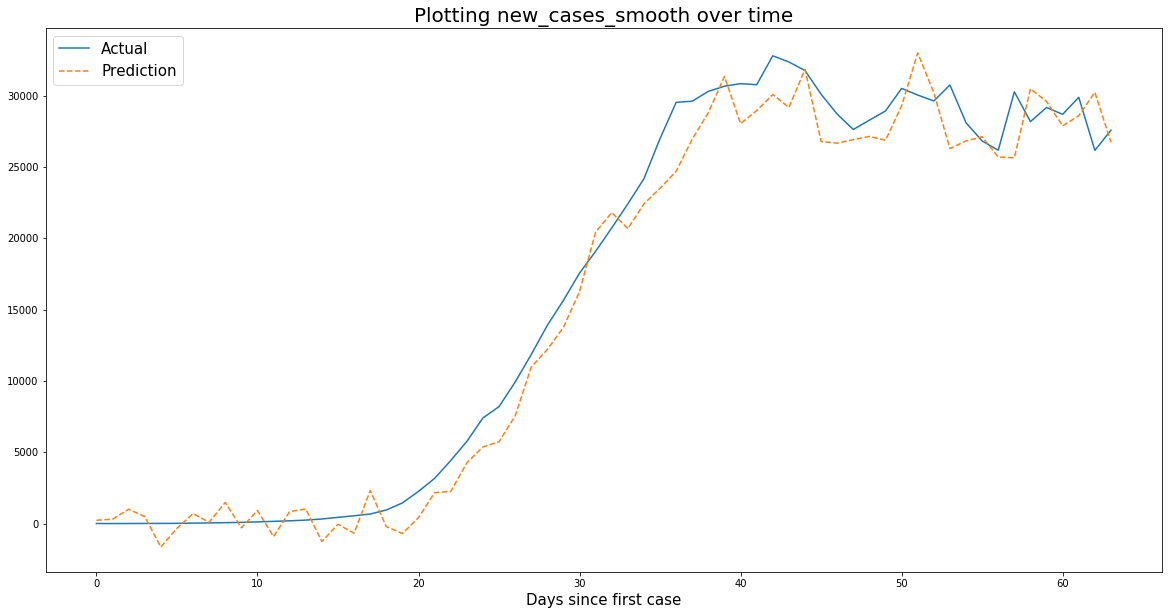

In [86]:
# Plot single-day prediction
plot_prediction(rnn_pred, y_train, max(covid_ranged['United_States_response']))

In [87]:
# Define function to allow windowed prediction plotting
# when predicting multiple days into the future
def plot_multiday_predictions(y_train, predictions, scale_max, ax=None):

    # Rescale data
    predictions_rescaled = predictions * scale_max
    y_train_rescaled = y_train * scale_max
    
    # Plot actual data
    cas_obs = []
    for i in range(len(y_train_rescaled)):
        cas_obs.append(y_train_rescaled[i, 0])
    
    if ax is not None:
        plot_loc=ax
    else:
        plot_loc=plt
        plt.figure(figsize=(20,10))
        
    plot_loc.plot(np.arange(0, len(cas_obs)), cas_obs, label = 'Observed')
    for i in range(len(predictions_rescaled)):
        plot_loc.plot(np.arange(i, i+predictions_rescaled.shape[-1]), predictions_rescaled[i], c = 'orange')
        
    if ax is None:
        plt.legend(['Observed', 'Predicted'], fontsize=15, loc=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               16400     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 16,905
Trainable params: 16,905
Non-trainable params: 0
_________________________________________________________________
Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 1s 29ms/sample - loss: 0.2786 - val_loss: 0.2422
Epoch 2/10
51/51 [==============================] - 0s 10ms/sample - loss: 0.1242 - val_loss: 0.2180
Epoch 3/10
51/51 [==============================] - 1s 10ms/sample - loss: 0.1064 - val_loss: 0.1312
Epoch 4/10
51/51 [==============================] - 1s 11ms/sample - loss: 0.1137 - val_loss: 0.1161
Epoch 5/10
51/51 [==============================] - 1s 11ms/samp

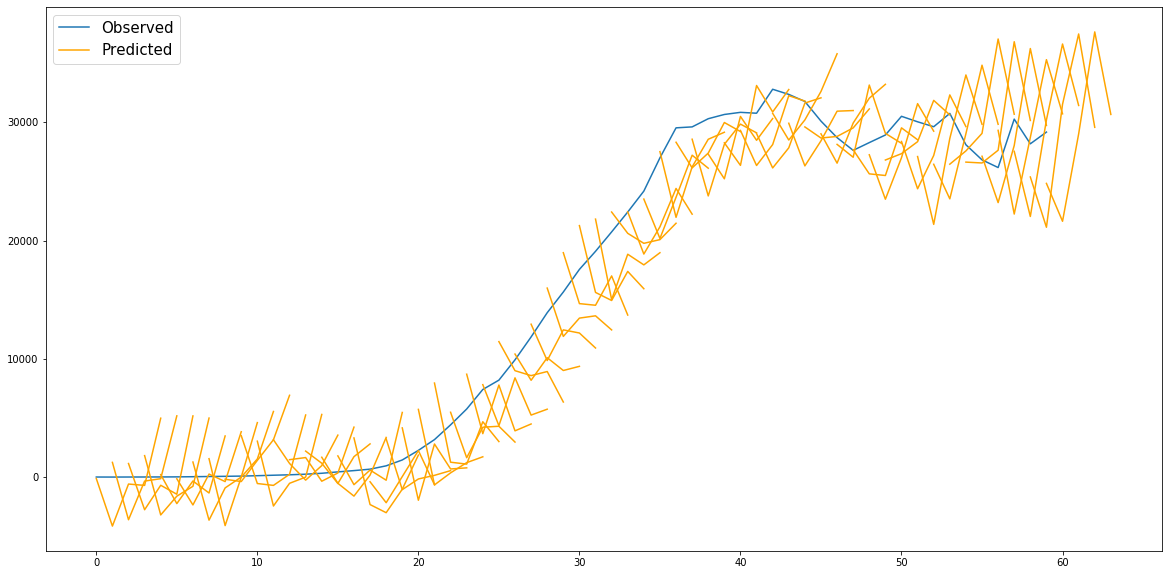

In [88]:
# Run sample multi-day prediction
days_train = 14
days_pred = 5
x_train, y_train = structure_supervised(covid_filtered, 'United_States_response', days_train, days_pred, holdout=True)
features = x_train.shape[-1]
rnn = model_rnn(days_train, days_pred, features)
history_rnn = fit_model(rnn, val_split=0.2)
rnn_pred = predict_model(rnn, x_train)
plot_multiday_predictions(y_train, rnn_pred, max(covid_ranged.United_States_response))

## Define various time series architectures
Since the dataset is fairly small, we can afford to run a lot of experiments. Among RNNs, LSTM is generally most powerful, but is also the slowest to fit. While we try single-layer LSTM networks, we therefore also try single-layer GRU, as these sacrifice some expressiveness for faster training speed, to see whether we truly do sacrifice much power. We also try stacking the LSTM network to see if the additional capacity of the model significantly increases its performance. Finally, we try a variant of stacked LSTM that instead uses a second LSTM layer that sees the data in reverse order; such networks have been found to perform very well on some sequence prediction problems.

In [89]:
# Define LSTM model
def model_lstm(days_train, days_pred, features, summary=True):

    lstm = Sequential()
    lstm.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(days_train, features)))
    lstm.add(Dense(days_pred, activation="linear"))
    
    lstm.compile(optimizer=Adam(learning_rate = 0.0005), loss='mae')

    if summary == True:
        lstm.summary()
    
    return lstm

In [90]:
# Define Stacked LSTM model
def model_stacked_lstm(days_train, days_pred, features, summary=True):
    
    stacked_lstm = Sequential()
    stacked_lstm.add(LSTM(100, activation = 'relu', batch_input_shape=(1, days_train, features),
                 return_sequences=True, stateful=False))
    stacked_lstm.add(LSTM(50, activation = 'relu', return_sequences = False, stateful=False))
    stacked_lstm.add(Dense(days_pred))

    stacked_lstm.compile(optimizer=Adam(learning_rate = 0.0005), loss='mae')

    if summary == True:
        stacked_lstm.summary()
    
    return stacked_lstm

In [91]:
# Define Bidirectional LSTM model
def model_lstm_bd(days_train, days_pred, features, summary=True):

    lstm_bd = Sequential()
    lstm_bd.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(days_train, features)))
    lstm_bd.add(Dense(days_pred, activation="linear"))
    
    lstm_bd.compile(optimizer=Adam(learning_rate = 0.0005), loss='mae')

    if summary == True:
        lstm_bd.summary()
    
    return lstm_bd

In [92]:
# Define GRU model
def model_gru(days_train, days_pred, features, summary=True):

    gru = Sequential()
    gru.add(GRU(100, input_shape=(days_train, features), return_sequences=False))
    gru.add(Dense(days_pred, activation="linear"))
    
    gru.compile(optimizer=Adam(learning_rate = 0.0005), loss='mae')

    if summary == True:
        gru.summary()
    
    return gru

In [93]:
# Define Bidirectional GRU model
def model_gru_bd(days_train, days_pred, features, summary=True):

    gru_bd = Sequential()
    gru_bd.add(Bidirectional(GRU(100, return_sequences=False), input_shape=(days_train, features)))
    gru_bd.add(Dense(days_pred, activation="linear"))
    
    gru_bd.compile(optimizer=Adam(learning_rate = 0.0005), loss='mae')

    if summary == True:
        gru_bd.summary()
    
    return gru_bd

## Define function to run variety of experiments

In [94]:
# Define a function to run a complete experiment
def run_experiment(model_func, dataframe, agg_column, country_response, test_columns,
                   dates=['2020-02-15', '2020-05-02'], days_train=14, days_pred=1,
                   val_split=0.0, x_test=x_train, ax=None):
    
    df = generate_multivariate_df(dataframe, 'date', agg_column, fillna=True)
    df = standardize_country_names(df)
    df = filter_to_target_countries(df)
    df = enrich_dataframe(df)
    # Prepare re-scale logic
    df = filter_range(df, dates[0], dates[1])
    if '100k' in agg_column:
        c = country_response.replace("_response", "")
        c_pop = ecdc_country[ecdc_country.country == c]['population_2018'].iloc[0]
        response_scale = max(df[country_response]) * (c_pop/100000)
    else:
        response_scale = max(df[country_response])
    df = scale(df)
    df = testing_filtration(df, test_columns)
    x_train, y_train = structure_supervised(df, country_response, days_train, days_pred, holdout=True)
    features = x_train.shape[-1]
    model = model_func(days_train, days_pred, features, summary=False)
    history = fit_model(model, x_train, y_train, val_split=val_split, verbose=0)
    predictions = predict_model(model, x_train)
    if days_pred > 1:
        plot_multiday_predictions(y_train, predictions, response_scale, ax=ax)
    else:
        plot_prediction(predictions, y_train, response_scale, ax=ax)

-------

# Run experiments

## Which RNN architectures best predict different response variables using all time series?

#### Cumulative Cases

Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google


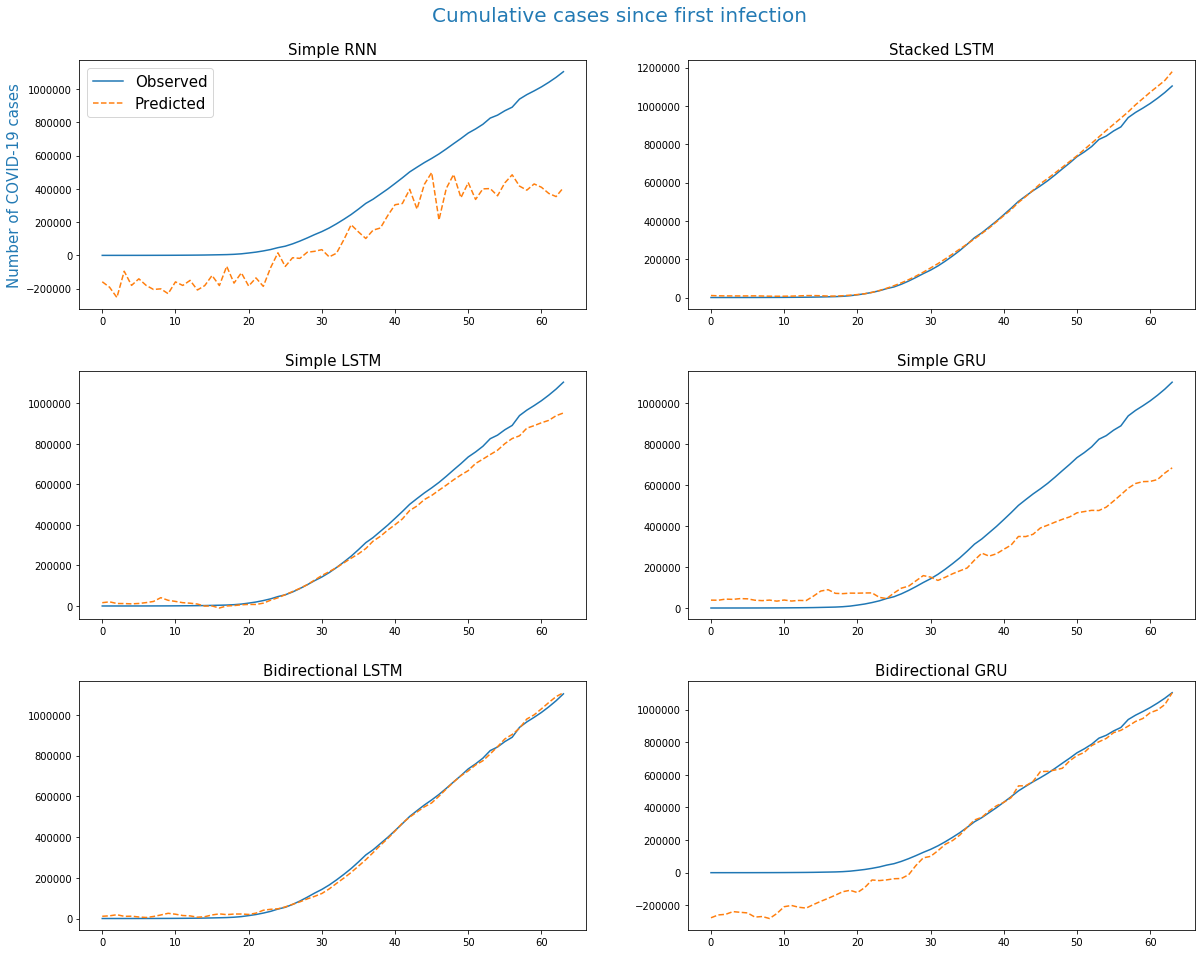

In [95]:
model_funcs = [model_rnn, model_stacked_lstm, model_lstm,
               model_gru, model_lstm_bd, model_gru_bd]
model_names = ["Simple RNN", "Stacked LSTM", "Simple LSTM",
              "Simple GRU", "Bidirectional LSTM", "Bidirectional GRU"]
fig, ax = plt.subplots(3, 2, figsize=(20,15))
pos = 0
for i in range(3):
    for j in range(2):
        run_experiment(model_funcs[pos], ecdc_country, 'cases', 'United_States_response',
                       test_columns,
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(f"{model_names[pos]}", size=15)
        pos+=1
plt.suptitle("Cumulative cases since first infection", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=15, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

#### New Cases and Deaths Per Day

Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google


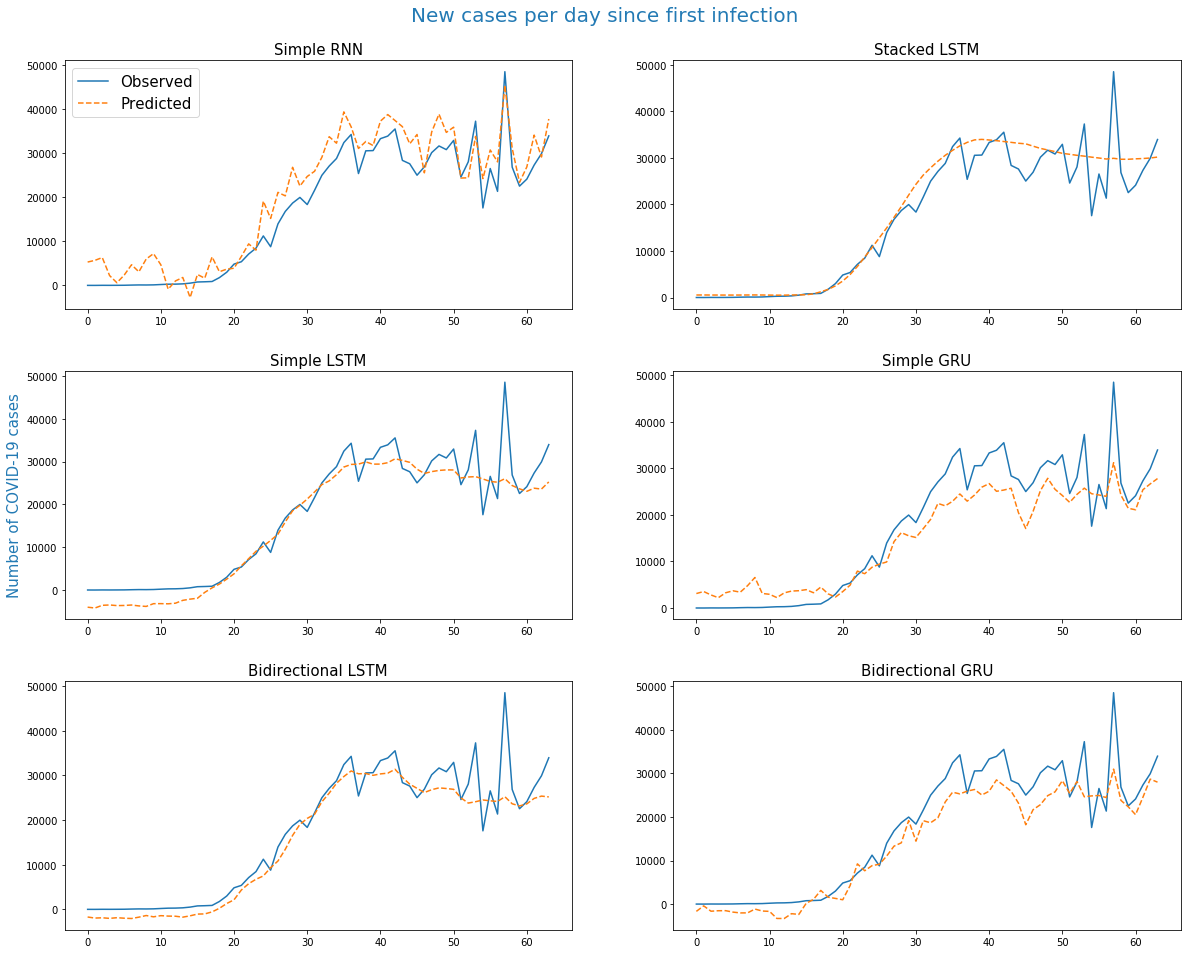

In [96]:
model_funcs = [model_rnn, model_stacked_lstm, model_lstm,
               model_gru, model_lstm_bd, model_gru_bd]
model_names = ["Simple RNN", "Stacked LSTM", "Simple LSTM",
              "Simple GRU", "Bidirectional LSTM", "Bidirectional GRU"]
fig, ax = plt.subplots(3, 2, figsize=(20,15))
pos = 0
for i in range(3):
    for j in range(2):
        run_experiment(model_funcs[pos], ecdc_country, 'new_cases', 'United_States_response',
                       test_columns,
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.0, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(f"{model_names[pos]}", size=15)
        pos+=1
plt.suptitle("New cases per day since first infection", fontsize=20, color='#237AB4')
ax[1,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=15, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google


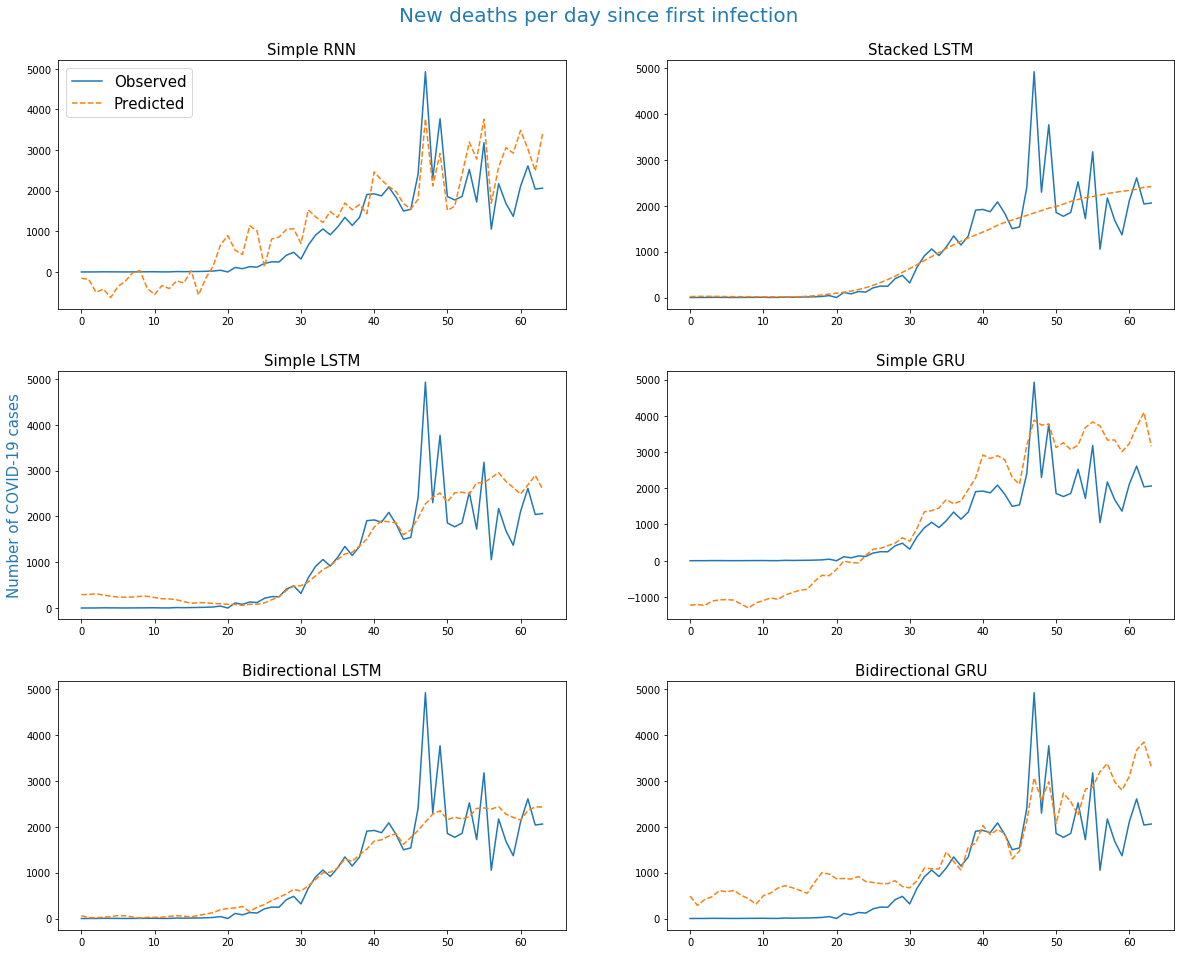

In [97]:
model_funcs = [model_rnn, model_stacked_lstm, model_lstm,
               model_gru, model_lstm_bd, model_gru_bd]
model_names = ["Simple RNN", "Stacked LSTM", "Simple LSTM",
              "Simple GRU", "Bidirectional LSTM", "Bidirectional GRU"]
fig, ax = plt.subplots(3, 2, figsize=(20,15))
pos = 0
for i in range(3):
    for j in range(2):
        run_experiment(model_funcs[pos], ecdc_country, 'new_deaths', 'United_States_response',
                       test_columns,
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(f"{model_names[pos]}", size=15)
        pos+=1
plt.suptitle("New deaths per day since first infection", fontsize=20, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=15, loc=2)
ax[1,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

#### Conclusion

When predicting a straight line like cumulative cases, simpler architectures do worse because they are highly variable and add unnecessary jumps during predictions. A Stacked LSTM learns the curve best while GRUs, being the least expressive, is unable to learn the shape of the data. We appear to be losing too much predictive power in exchange for the GRU's performance boost. For more variable curves like cases per day, the simpler models appear to follow the data better for single-day predictions. GRUs provide the nearest fit to the data but they still appear to be too jump to be totally accurate. Stacked or Bidirectional LSTMs appear to best blend finding the overall trend while permitting some response to dramatic up/down spikes. As a result, we will continue to use a Stacked LSTM model for future experiments.

------

# Predict a country's case growth using alternate time series

We next turn to the challenge of exclusively using alternate time series to identify the growth rate of coronavirus in a target country. We train varying models on testing records and mobility data from Apple and Google and use that to predict coronavirus case growth. Given the Stacked LSTM appeared to fit best for both single- and multi-day predictions, we continue that forward.

## Does adding alternate time series improve prediction accuracy?

#### Single day Predictions

Running with columns containing response
Running with columns containing response|tests
Running with columns containing response|tests|apple
Running with columns containing response|tests|apple|google


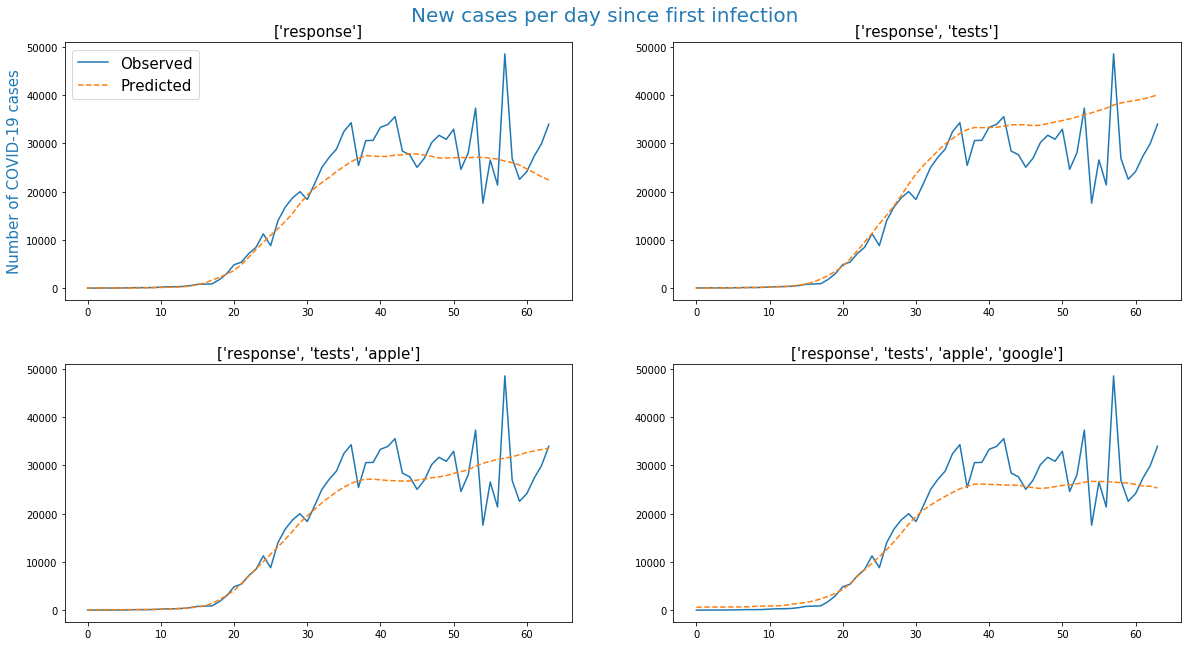

In [98]:
test_columns = ['response', 'tests', 'apple', 'google']
fig, ax = plt.subplots(2,2, figsize=(20,10))
pos = 1
for i in range(2):
    for j in range(2):
        run_experiment(model_stacked_lstm, ecdc_country, 'new_cases', 'United_States_response',
                       test_columns[:pos],
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(test_columns[:pos], size=15)
        pos+=1
plt.suptitle("New cases per day since first infection", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=15, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

#### Multiple days out predictions

Running with columns containing response
Running with columns containing response|tests
Running with columns containing response|tests|apple
Running with columns containing response|tests|apple|google


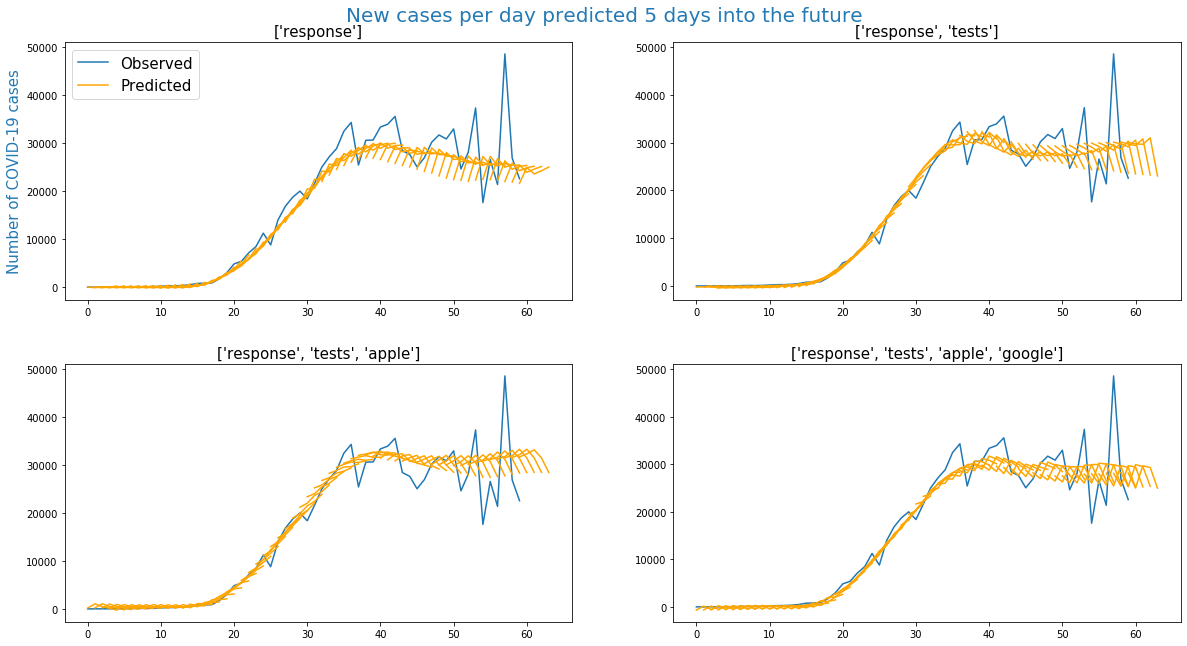

In [99]:
test_columns = ['response', 'tests', 'apple', 'google']
fig, ax = plt.subplots(2,2, figsize=(20,10))
pos = 1
for i in range(2):
    for j in range(2):
        run_experiment(model_stacked_lstm, ecdc_country, 'new_cases', 'United_States_response',
                       test_columns[:pos],
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=5,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(test_columns[:pos], size=15)
        pos+=1
plt.suptitle("New cases per day predicted 5 days into the future", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=15, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

#### Conclusion

Adding tests alone predicts a higher than reported new cases per day, perhaps reflecting the growing but still insufficient number of tests being performed in the United States. Adding mobility produces the line that appears the best fit to the reported data and while we see some change when using Apple vs Apple and Google, both appear more accurate than alternatives. This remains true for predictions 5 days out as well where including all alternate time series narrows the prediction range throughout the curve.

------

# Predict country's caseload with just that country's alternatives

Having tested whether adding our alternate time series will improve predictions for various responses, we now want to try predicting our response with just the alternate time series. As case counts in various countries may be suspect, testing or mobility data can be easier to collect and used to predict true caseload.

Running with columns containing France
Running with columns containing Italy
Running with columns containing Germany
Running with columns containing Austria
Running with columns containing United_Kingdom
Running with columns containing Spain
Running with columns containing Portugal
Running with columns containing Turkey
Running with columns containing Norway
Running with columns containing Sweden
Running with columns containing Belgium
Running with columns containing Netherlands
Running with columns containing Switzerland
Running with columns containing Singapore
Running with columns containing United_States
Running with columns containing Canada


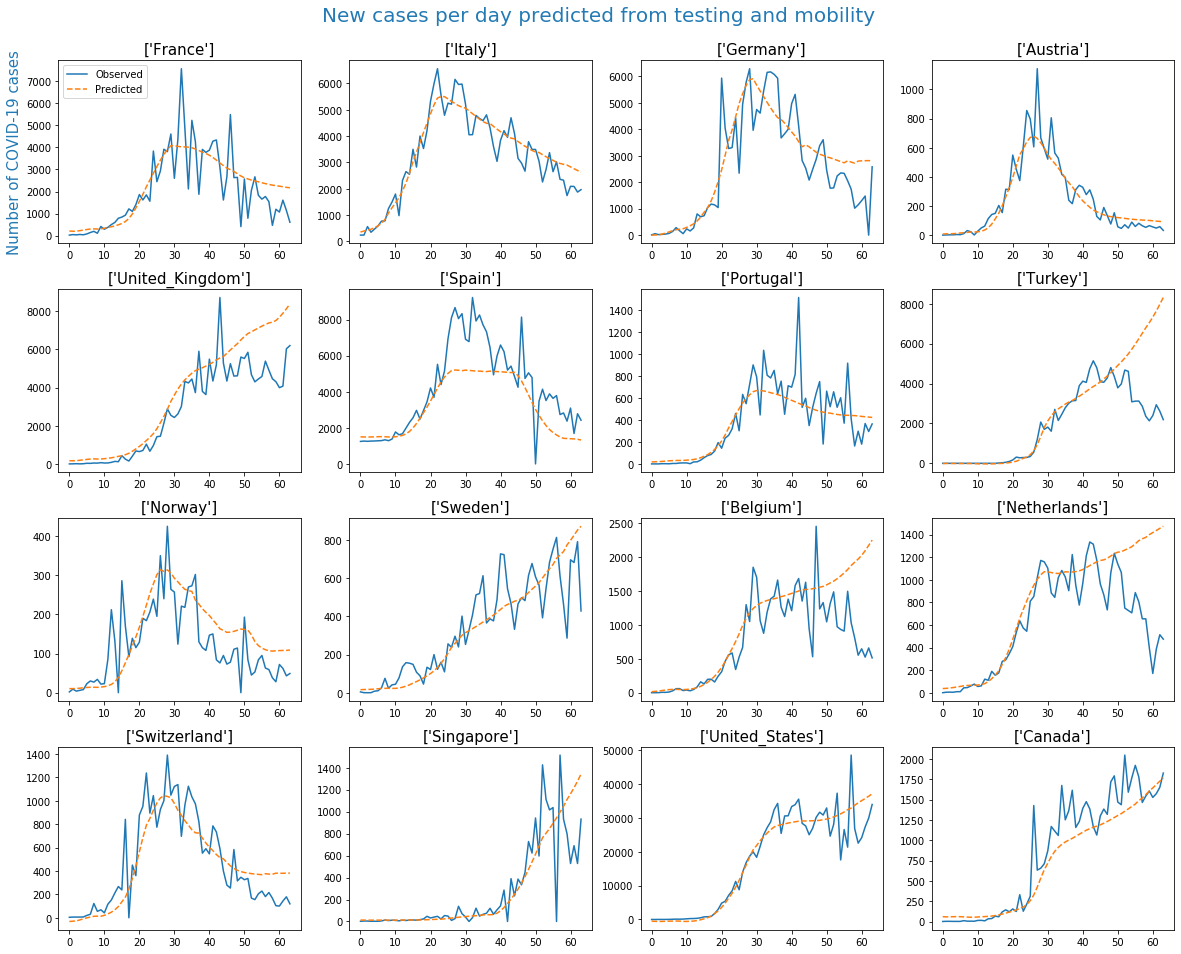

In [100]:
ncols = 4
nrows = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(20,15))
pos = 0
for i in range(nrows):
    for j in range(ncols):
        run_experiment(model_stacked_lstm, ecdc_country, 'new_cases', target_countries[pos] + '_response',
                       target_countries[pos:pos+1],
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(target_countries[pos:pos+1], size=15)
        pos+=1
plt.suptitle("New cases per day predicted from testing and mobility", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=10, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

Running with columns containing France
Running with columns containing Italy
Running with columns containing Germany
Running with columns containing Austria
Running with columns containing United_Kingdom
Running with columns containing Spain
Running with columns containing Portugal
Running with columns containing Turkey
Running with columns containing Norway
Running with columns containing Sweden
Running with columns containing Belgium
Running with columns containing Netherlands
Running with columns containing Switzerland
Running with columns containing Singapore
Running with columns containing United_States
Running with columns containing Canada


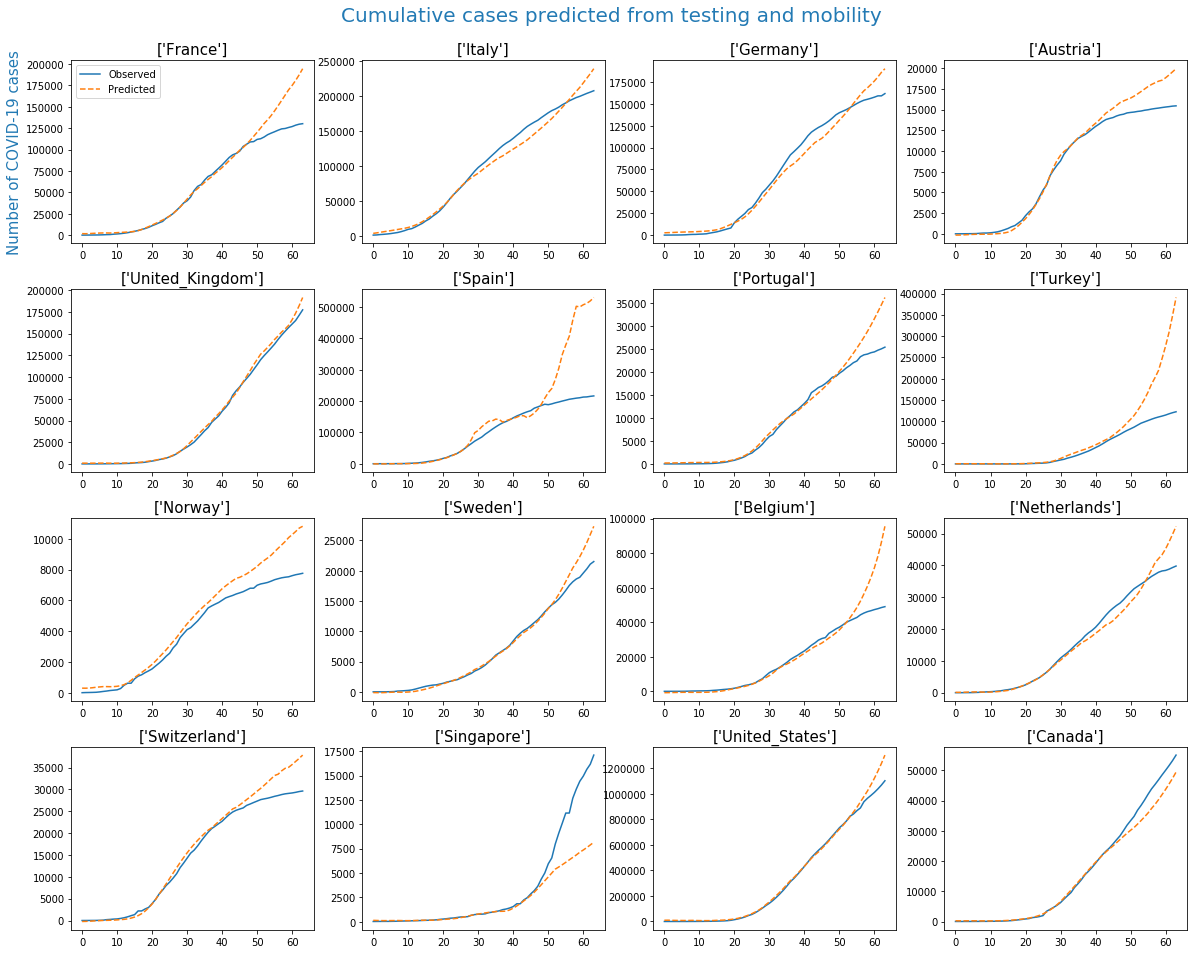

In [101]:
ncols = 4
nrows = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(20,15))
pos = 0
for i in range(nrows):
    for j in range(ncols):
        run_experiment(model_stacked_lstm, ecdc_country, 'cases_per100k', target_countries[pos] + '_response',
                       target_countries[pos:pos+1],
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(target_countries[pos:pos+1], size=15)
        pos+=1
plt.suptitle("Cumulative cases predicted from testing and mobility", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=10, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

Running with columns containing France
Running with columns containing Italy
Running with columns containing Germany
Running with columns containing Austria
Running with columns containing United_Kingdom
Running with columns containing Spain
Running with columns containing Portugal
Running with columns containing Turkey
Running with columns containing Norway
Running with columns containing Sweden
Running with columns containing Belgium
Running with columns containing Netherlands
Running with columns containing Switzerland
Running with columns containing Singapore
Running with columns containing United_States
Running with columns containing Canada


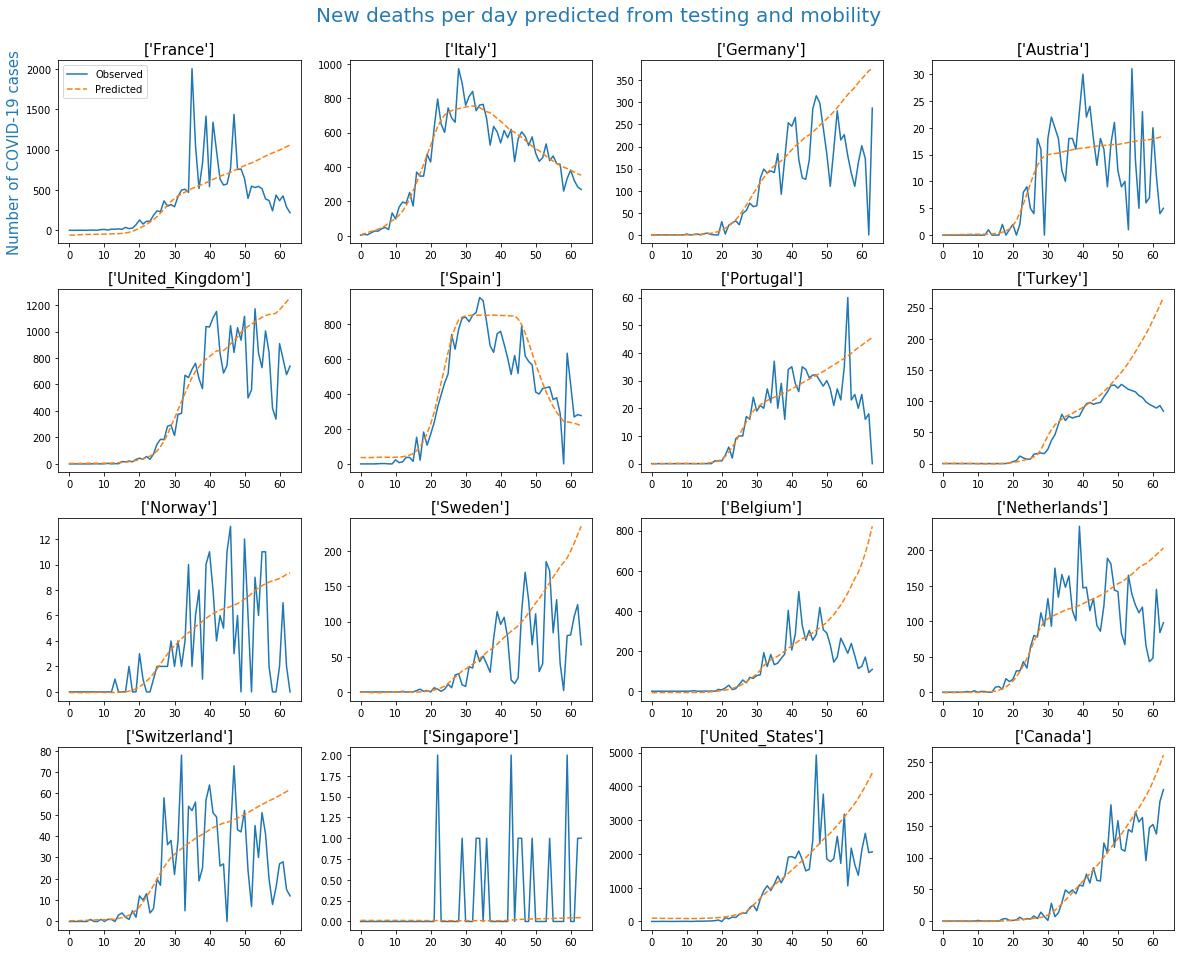

In [102]:
ncols = 4
nrows = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(20,15))
pos = 0
for i in range(nrows):
    for j in range(ncols):
        run_experiment(model_stacked_lstm, ecdc_country, 'new_deaths', target_countries[pos] + '_response',
                       target_countries[pos:pos+1],
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=1,
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(target_countries[pos:pos+1], size=15)
        pos+=1
plt.suptitle("New deaths per day predicted from testing and mobility", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=10, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

#### Conclusion

We see varied results. Using just testing and mobility rates, we are able to successfully predict new case rates for countries like Norway, Spain, Italy, and Austria. There are a set of countries where the data suggests that new cases should be continuing to increase dramatically beyond what is officially reported. This includes Turkey, the Netherlands, Sweden and Singapore. These countries have generally restricted travel less than their counterparts or already begun to re-open so the model could be using mobility to assess a coming increase that may or may not actually arrive if these countries are re-opening because they've successfully contained the virus.

-----

# How far out into the future can we predict?

Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google
Running with columns containing response|tests|apple|google


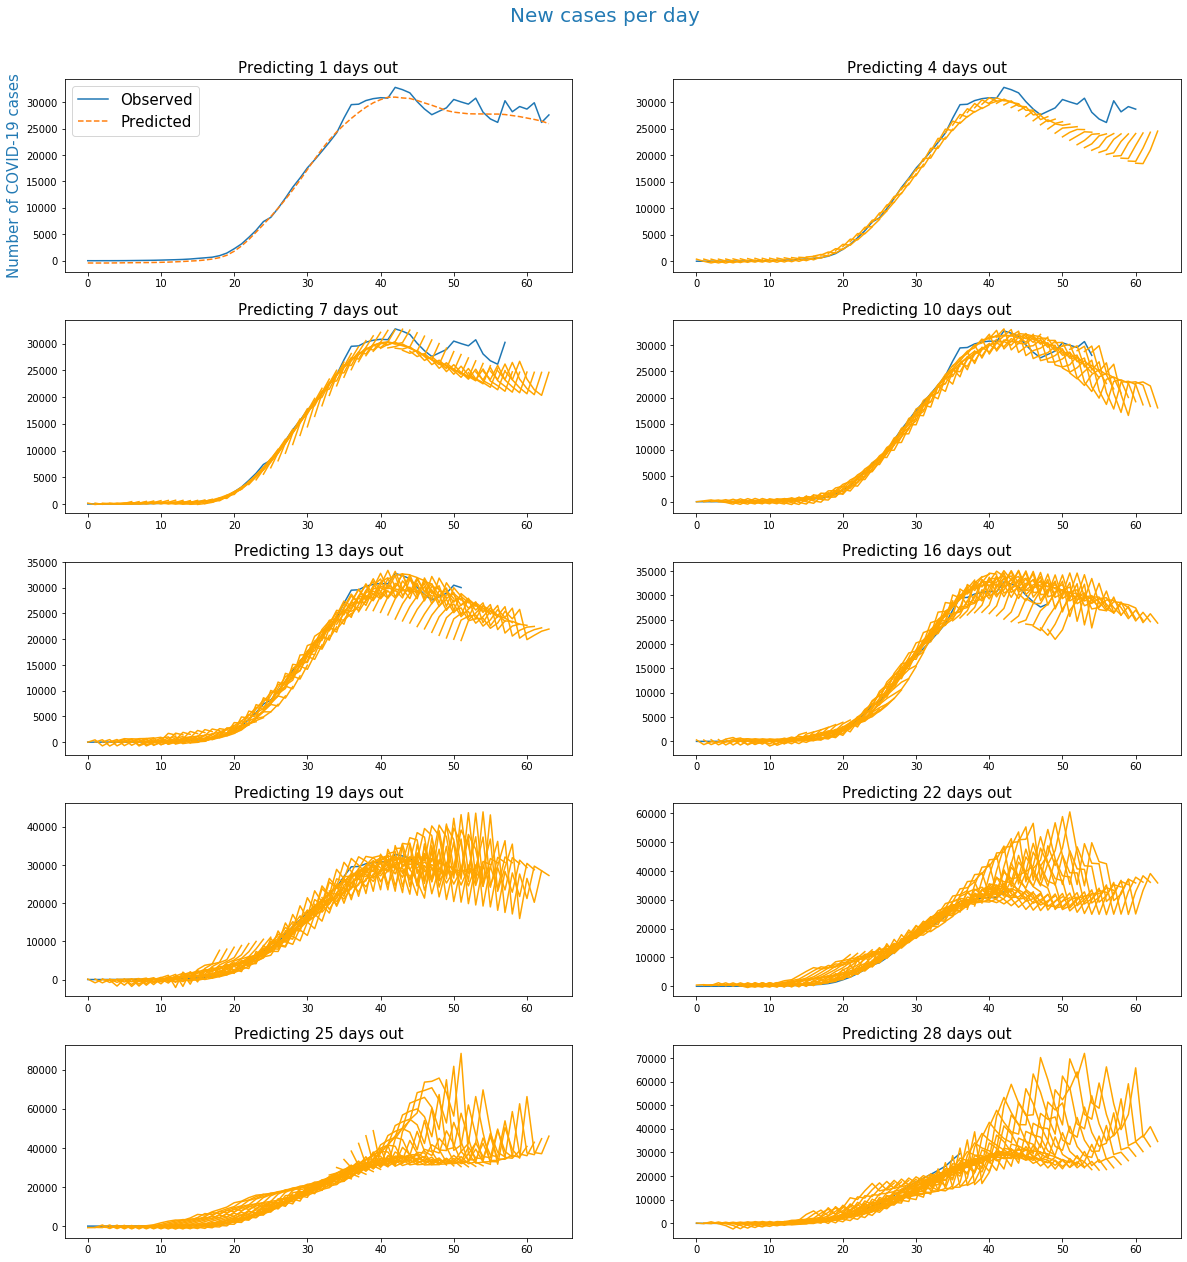

In [103]:
days_out = np.linspace(1,28,10).astype(int)

fig, ax = plt.subplots(5,2, figsize=(20,20))
pos = 0
for i in range(5):
    for j in range(2):
        run_experiment(model_stacked_lstm, ecdc_country, 'new_cases_smooth', 'United_States_response',
                       test_columns,
                       dates=['2020-02-15', '2020-05-02'],
                       days_train=14, days_pred=days_out[pos],
                       val_split=0.2, x_test=x_train, ax=ax[i,j])
        ax[i,j].set_title(f"Predicting {days_out[pos]} days out", size=15)
        pos+=1
plt.suptitle("New cases per day", fontsize=20, color='#237AB4')
ax[0,0].set_ylabel("Number of COVID-19 cases", fontsize=15, color='#237AB4')
ax[0,0].legend(['Observed', 'Predicted'], fontsize=15, loc=2)
fig.subplots_adjust(top=0.93, hspace=0.25)
plt.show()

#### Conclusion
For fairly close prediction windows, the model performs adequately. However, as the time horizon for which we are trying to predict gets longer and longer, the model makes increasingly erratic predictions. This is not altogether unreasonable as the model is fit on sequences of 14 days of history, so for instance predicting 28 days into the future is a tall task. Furthermore, quite a few countries have limited histories of presence in the virus, so the longer our prediction sequences get, the less data the model has to fit on. As such, longer prediction windows means both a harder problem and less data, so it is not unexpected to see it struggle with predictions horizons several times longer than the input sequence.

The model must also strike a balance between accurately predicting the overall trend (otherwise the loss function will penalise it heavily as extrapolating further out makes the squared error exponentially greater) and adequately capturing the local perturbations (the erratic new cases curve means a sudden spike will add considerable error if it is missed by the model). The longer the prediction horizon, the more acute this trade-off becomes.

Consequently, with the data available, our model is most reliable when predicting between 1 and 7 days out. Going much farther out than that, the prediction vector becomes increasingly erratic. For future work, this could likely be improved by smoothing the raw time series by more days to even out some of the more extreme fluctuations that throw the model off keel.

------

------

# Reservoir Computing for COVID-19 Prediction

We saw using traditional RNNs that we were limited to predictions within a week or so of the date. Early in a fast moving pandemic, this warning would be critical for public health officials but once underway, the discussion will turn to what case load will be a month or more. This is critical as countries build plans to re-open their economies and permit people to travel again. To help with longer term predictions, we apply the novel technique of Reservoir Computing, an echo-state recurrent neural network, to pandemic spread prediction. We test two distinct hypotheses.

First, we test the accuracy of short-term RC predictions for the infected population in the days following a prediction using held-out days from the current COVID-19 pandemic. Short-term RCs are quick and computationally cheaper to train than alternatives so can reduce re-training load for epidemiologists if accurate.

Second, we incorporate the concept of observers to test the accuracy of longer-term RC predictions on the order of weeks to months. Because of the structure of viral spread, some countries will benefit from advanced warning by observing accurately collected data from preceding nations. North America is in such a position now with its fight to contain COVID-19. The initial viral outbreak occurred in China at least two months before significant spread was reported in the state of Washington in the United States. As our Multi-Model showed, the United States is an outlier from the remainder of the world, meaning its experience can not be accurately predicted by comparing it to other countries. Instead, we predict case growth in Canada, a country with a similar level of warning but a public health response more in line with other nations. We select a handful of countries with varying sizes and durations of curves, all of which were experienced before Canada began to experience an increased case load.

In [104]:
# Save dataframe specific to the United States
usa = ecdc_country[ecdc_country['country'] == 'United_States']
usa.tail(5)

date  day  month  year  new_cases  new_deaths        country  \
15491 2020-05-06    6      5  2020      23841        2144  United_States   
15490 2020-05-07    7      5  2020      24128        2353  United_States   
15489 2020-05-08    8      5  2020      28369        2239  United_States   
15488 2020-05-09    9      5  2020      26957        1510  United_States   
15487 2020-05-10   10      5  2020      25612        1614  United_States   

      geoID country_code  population_2018  ...    cases  deaths  \
15491    US          USA      327167434.0  ...  1204475   71078   
15490    US          USA      327167434.0  ...  1228603   73431   
15489    US          USA      327167434.0  ...  1256972   75670   
15488    US          USA      327167434.0  ...  1283929   77180   
15487    US          USA      327167434.0  ...  1309541   78794   

       cases_per100k  deaths_per100k  new_cases_per100k  new_deaths_per100k  \
15491     368.152473       21.725267           7.287094            0.655322   
15490     375.527290       22.444471           7.374817            0.719204   
15489     384.198386       23.128830           8.671095            0.684359   
15488     392.437898       23.590367           8.239512            0.461537   
15487     400.266305       24.083693           7.828408            0.493325   

       new_cases_smooth  new_cases_per100k_smooth   day_zero days_since_zero  
15491           26929.8                  8.231198 2020-01-21             106  
15490           24964.4                  7.630466 2020-01-21             107  
15489           24780.6                  7.574287 2020-01-21             108  
15488           25177.6                  7.695631 2020-01-21             109  
15487           25781.4                  7.880185 2020-01-21             110  

[5 rows x 21 columns]

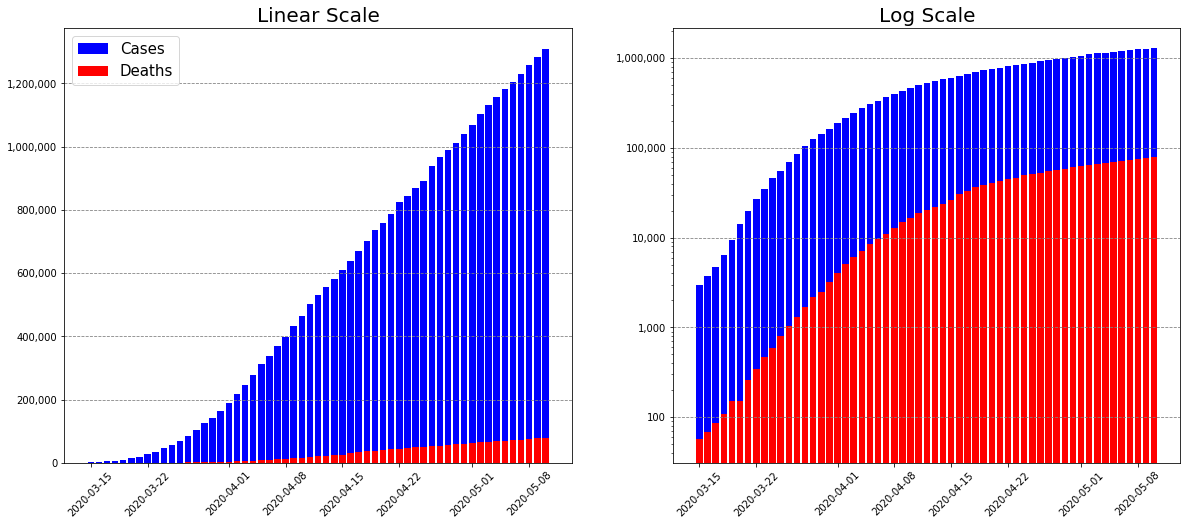

In [105]:
# Plot USA Cases in Linear and Log Scale
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].set_yscale('linear')
axs[1].set_yscale('log')
axs[0].set_title("Linear Scale", size=20)
axs[1].set_title("Log Scale", size=20)

for i in range(2):
    axs[i].bar(usa['date'][75:], usa['cases'][75:], color='blue', label="Cases")
    axs[i].bar(usa['date'][75:], usa['deaths'][75:], color='red', label="Deaths")

    axs[i].yaxis.grid(color='gray', linestyle='dashed')
    axs[i].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    axs[i].tick_params(axis='x', labelrotation=45)

axs[0].legend(fontsize=15)
plt.show()

## Short-Term RC Predictions of Infection Rate

In [106]:
# Select starting response column for design
response_column = 'new_cases_smooth'

In [107]:
# Filter to data necessary for RC
usa_rc = usa[usa[response_column] > 100][response_column].reset_index(drop=True)
usa_rc

0       119.0
1       158.4
2       194.8
3       246.0
4       324.0
       ...   
57    26929.8
58    24964.4
59    24780.6
60    25177.6
61    25781.4
Name: new_cases_smooth, Length: 62, dtype: float64

In [108]:
# Define prepare_data function
def prepareData(target, train_perc=0.9, plotshow=False):
    datalen =  len(target)        
    trainlen = int(train_perc*datalen)
    testlen  = datalen-trainlen

# Train/Test sets
    trainTarget = np.array(target[:trainlen])
    testTarget  = np.array(target[trainlen:trainlen+testlen]    )
    inputTrain = np.ones(trainlen)
    inputTest  = np.ones(testlen)
        
    if plotshow:
        plt.figure(figsize=(14,3))
        plt.plot(range(0,trainlen), trainTarget,'g',label='Train')
        plt.plot(range(trainlen,trainlen+testlen), testTarget,'-r',label='Test')
        plt.legend(loc=(0.1,1.1),fontsize=18,ncol=2)
        plt.tight_layout()
        plt.show()
        
    return trainTarget, testTarget, inputTrain, inputTest

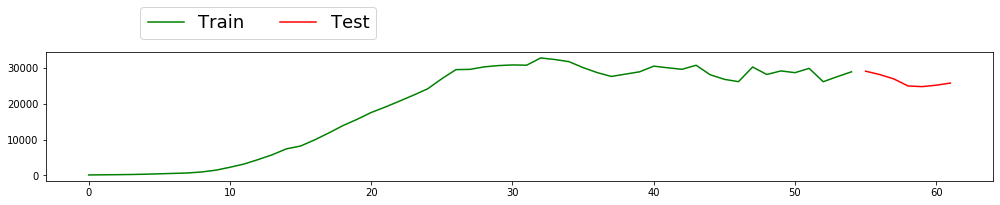

In [109]:
# Prepare US data
trainTarget, testTarget, inputTrain, inputTest = prepareData(usa_rc, train_perc=0.90, plotshow=True)

In [110]:
# Plot shapes
trainTarget.shape, testTarget.shape, inputTrain.shape, inputTest.shape

((55,), (7,), (55,), (7,))

In [111]:
# Define constant hyper-parameters
n_outputs = 1
n_reservoir = 1000
noise = 0.0001
random_state=42

In [112]:
### Make manual prediction

# Define ESN
esn_st = ESN(n_inputs = 1,
          spectral_radius = 1.5,
          sparsity = 0.5,
          n_outputs=n_outputs,
          n_reservoir=n_reservoir,
          noise=noise,
          random_state=random_state)

# Train ESN
pred_training = esn_st.fit(inputTrain, trainTarget)

In [113]:
# Define MSE function
def MSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

In [114]:
# Make quick prediction and return MSE
prediction = esn_st.predict(inputTest)
print("Quick Prediction MSE:", round(MSE(prediction, testTarget), 5))

Quick Prediction MSE: 2804.91109


In [115]:
def residuals(prediction,target):
    return (target.flatten() - prediction.flatten())

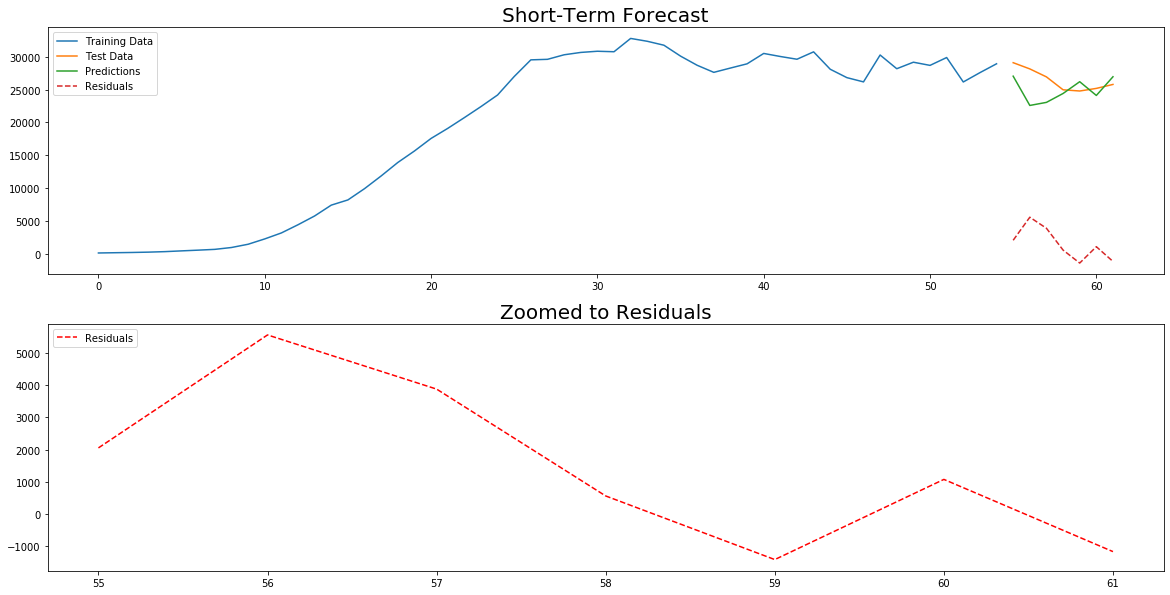

In [116]:
# Plot training, predictions and ground truth
fig, axs = plt.subplots(2,1, figsize=(20,10))
len_train = len(trainTarget)
len_test = len(testTarget)
axs[0].plot(range(0,len_train), trainTarget, label="Training Data")
axs[0].plot(range(len_train, len_train+len_test), testTarget, label="Test Data")
axs[0].plot(range(len_train, len_train+len_test), prediction, label="Predictions")
res = residuals(prediction, testTarget)
axs[0].plot(range(len_train, len_train+len_test), res, ls="--", label="Residuals")

axs[1].plot(range(len_train, len_train+len_test), res, ls="--", color="red", label="Residuals")

axs[0].set_title("Short-Term Forecast", size=20)
axs[1].set_title("Zoomed to Residuals", size=20)
axs[0].legend(loc=2, fontsize=10)
axs[1].legend(loc=2, fontsize=10)
plt.show()

#### Vary the Response

We next define a function to run a number of experiments to see how Short-Term RC predicts different important response variables.

In [117]:
# Define function to quickly run experiment
def run_rc_experiment(response, data, model, train_pct=0.9, min_value=False, plotshow=True):
    data_rc = data[data[response] != 0][response].reset_index(drop=True)
    if min_value is not False:
        data_rc = data[data[response] >= min_value][response].reset_index(drop=True)
    trainTarget, testTarget, inputTrain, inputTest = prepareData(data_rc, train_perc=train_pct, plotshow=plotshow)
    pred_training = model.fit(inputTrain, trainTarget)
    prediction = model.predict(inputTest)
    print("Quick Prediction MSE:", round(MSE(prediction, testTarget), 5))
    
    # Plot training, predictions and ground truth
    fig, axs = plt.subplots(2,1, figsize=(20,10))
    len_train = len(trainTarget)
    len_test = len(testTarget)
    axs[0].plot(range(0,len_train), trainTarget, label="Training Data")
    axs[0].plot(range(len_train, len_train+len_test), testTarget, label="Test Data")
    axs[0].plot(range(len_train, len_train+len_test), prediction, label="Predictions")
    res = residuals(prediction, testTarget)
    axs[0].plot(range(len_train, len_train+len_test), res, ls="--", label="Residuals")

    axs[1].plot(range(len_train, len_train+len_test), res, ls="--", color="red", label="Residuals")

    axs[0].set_title("Short-Term Forecast", size=20)
    axs[1].set_title("Zoomed to Residuals", size=20)
    axs[0].legend(loc=2, fontsize=10)
    axs[1].legend(loc=2, fontsize=10)
    plt.show()

Quick Prediction MSE: 845046.68581


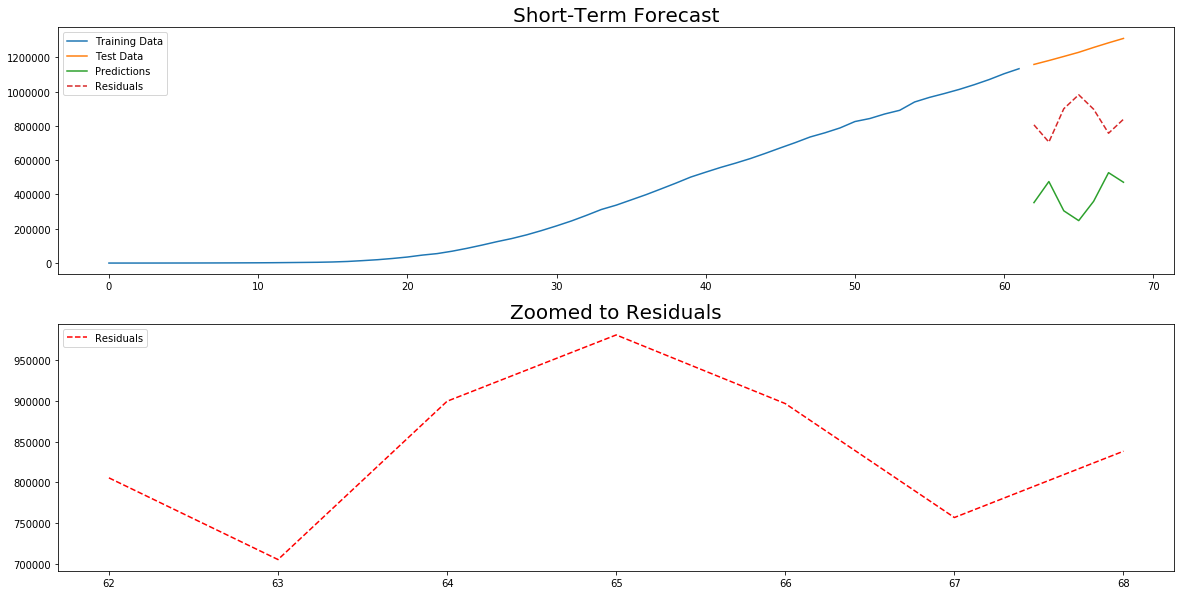

In [118]:
run_rc_experiment('cases', usa, esn_st, train_pct=0.90, min_value=100, plotshow=False)

Quick Prediction MSE: 10.72721


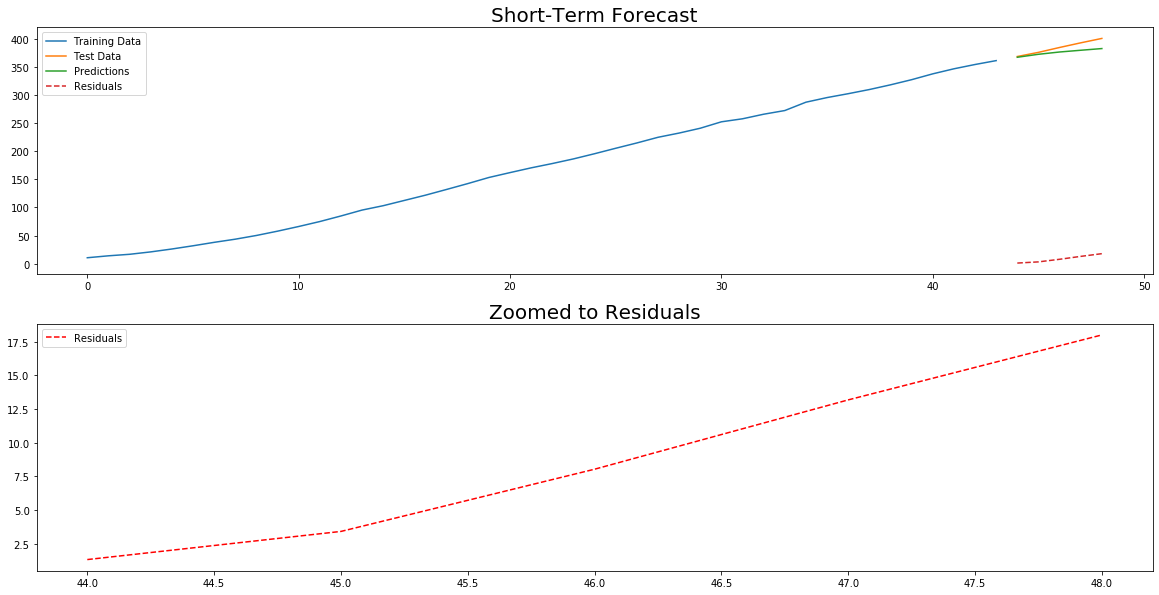

In [119]:
run_rc_experiment('cases_per100k', usa, esn_st, train_pct=0.90, min_value=10, plotshow=False)

Quick Prediction MSE: 39498.30367


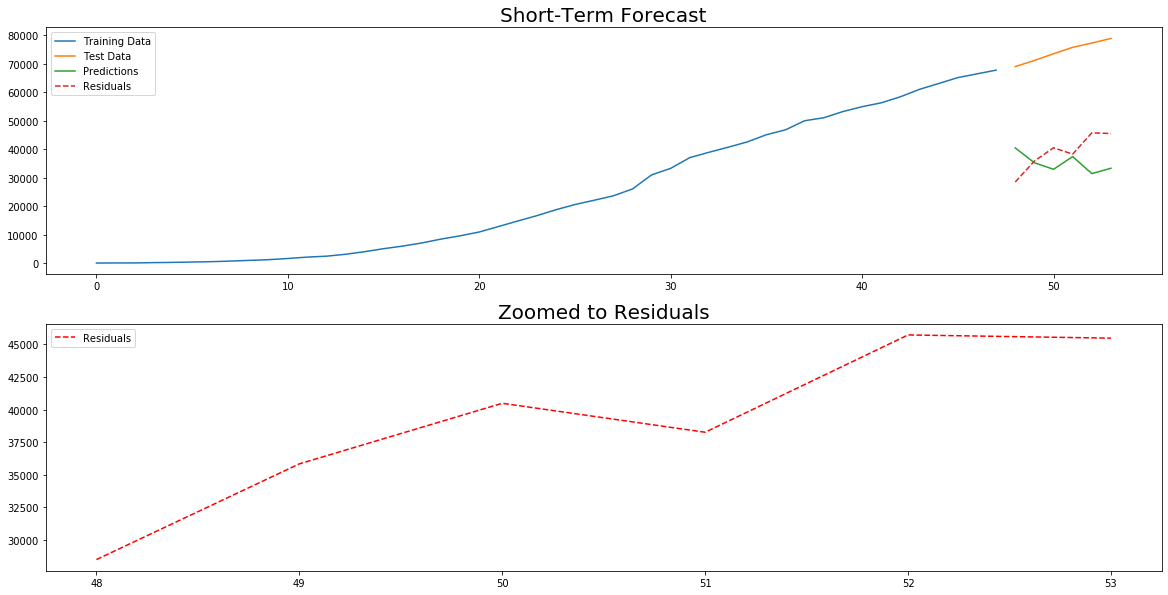

In [120]:
run_rc_experiment('deaths', usa, esn_st, train_pct=0.90, min_value=100, plotshow=False)

Quick Prediction MSE: 1.51474


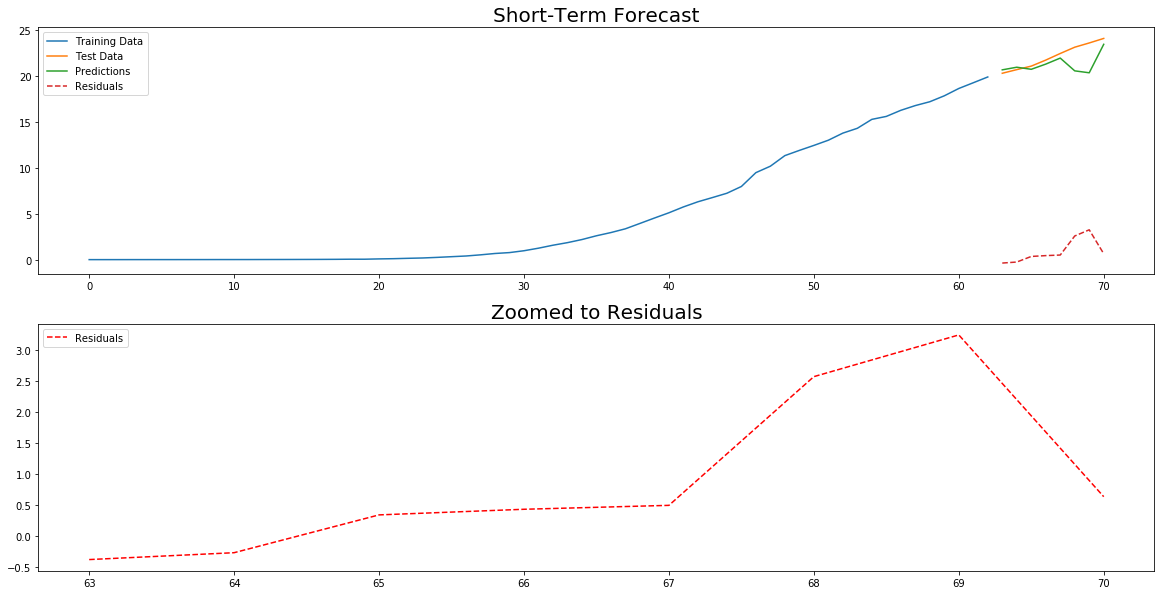

In [121]:
run_rc_experiment('deaths_per100k', usa, esn_st, train_pct=0.9, min_value=False, plotshow=False)

Quick Prediction MSE: 3473.01395


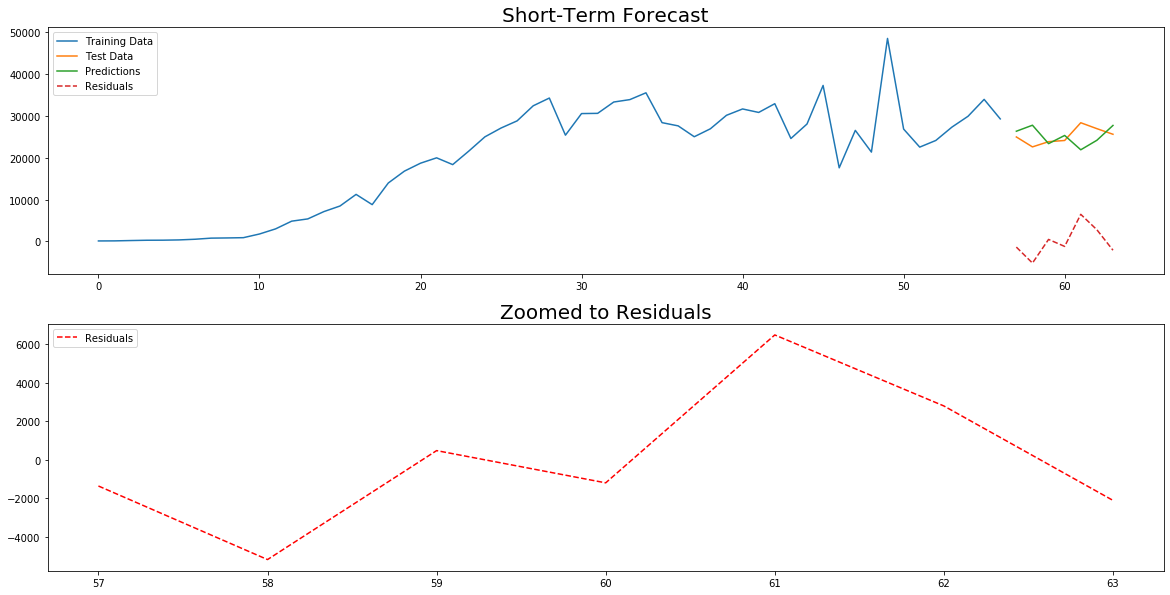

In [122]:
run_rc_experiment('new_cases', usa, esn_st, train_pct=0.90, min_value=100, plotshow=False)

Quick Prediction MSE: 94.76036


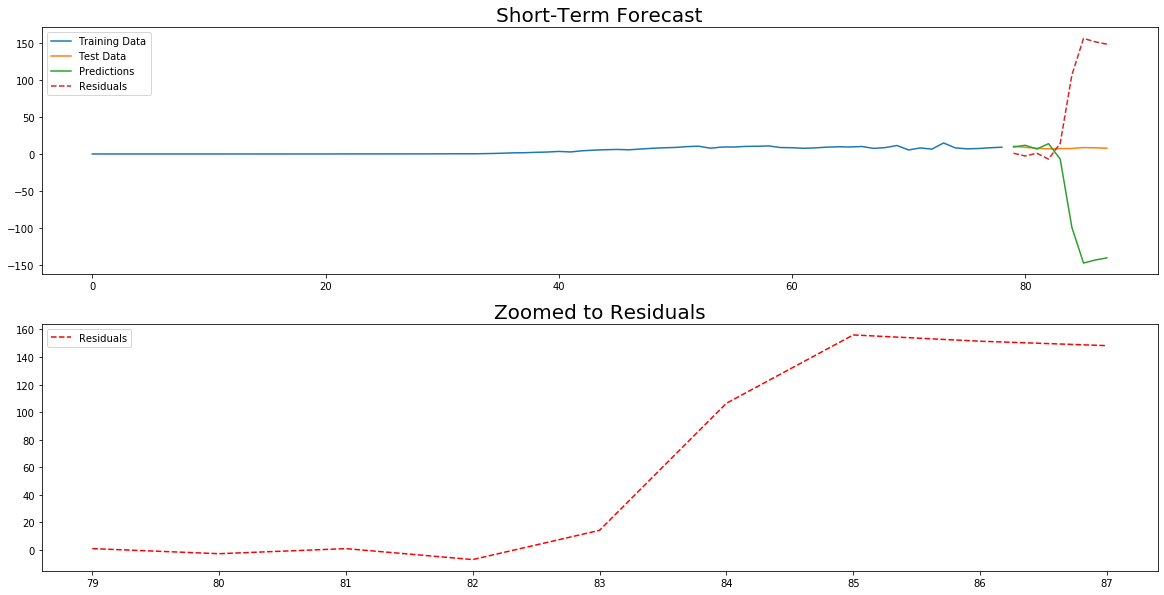

In [123]:
run_rc_experiment('new_cases_per100k', usa, esn_st, train_pct=0.90, min_value=False, plotshow=False)

Quick Prediction MSE: 3695.16775


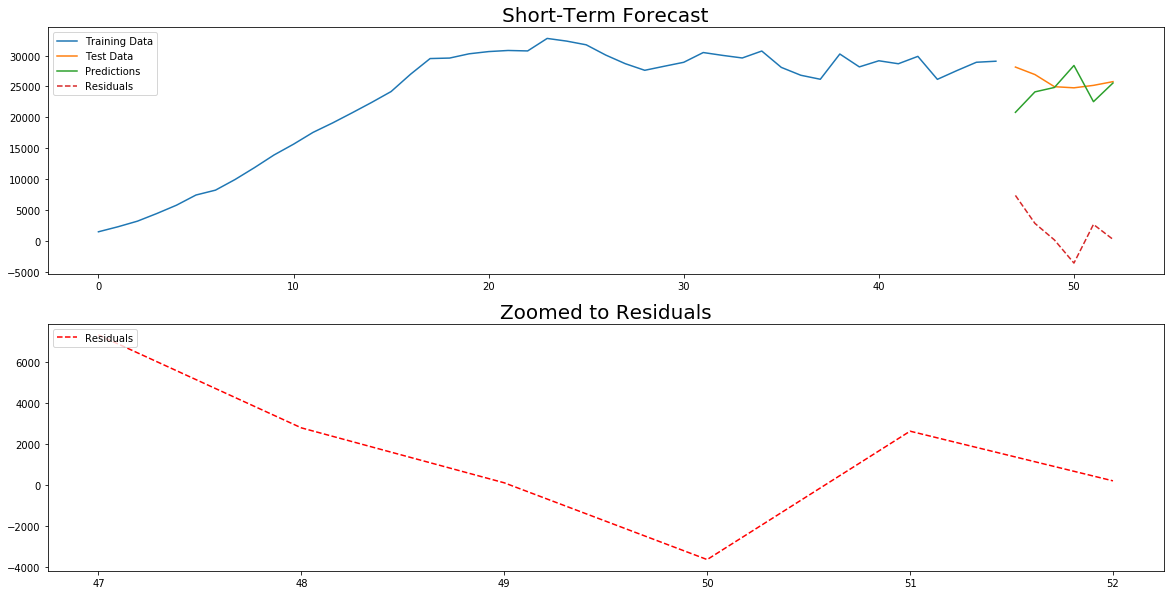

In [124]:
run_rc_experiment('new_cases_smooth', usa, esn_st, train_pct=0.90, min_value=1000, plotshow=False)

Quick Prediction MSE: 290.00796


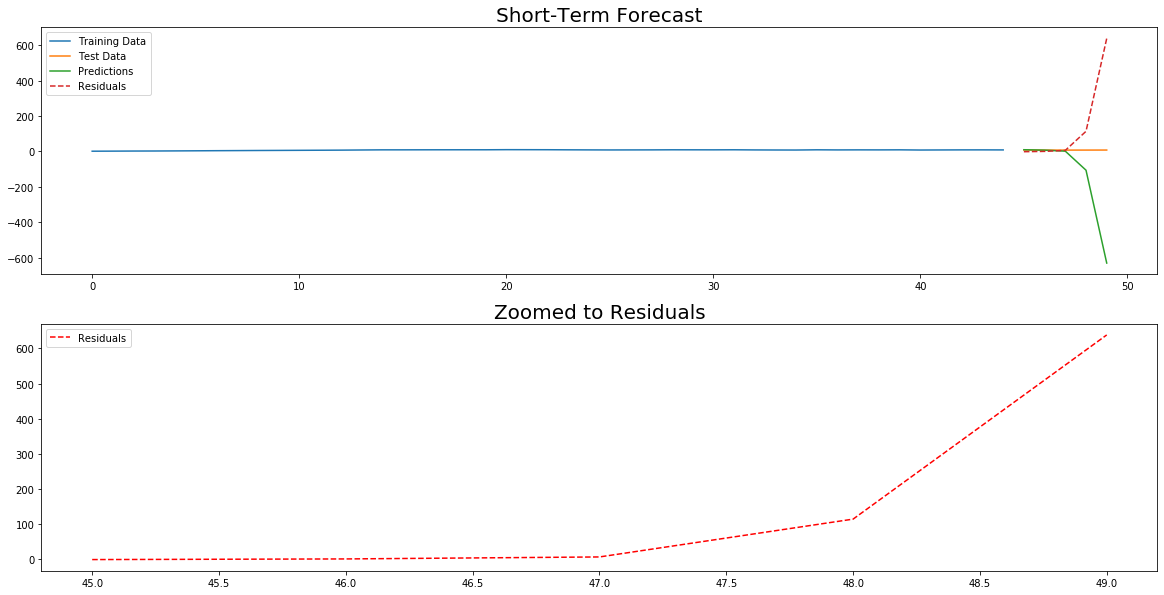

In [125]:
run_rc_experiment('new_cases_per100k_smooth', usa, esn_st, train_pct=0.90, min_value=1, plotshow=False)

#### Conclusion

Over the short term, several days out, RC performs well when predicting either variable responses like new cases or new deaths or standardized responses like cases_per100k. It does very poorly on absolute cases and standardized variable responses like new_cases_per100k. Accuracy is significantly improved by filtering time series to values reflecting the start of exponential growth (i.e., the first bend in the curve). By limiting to learning on time series only once the increase has begun in earnest, the RC does not over learn the long starting tail of low case counts and prematurely predict a decline (or return to mean of zero).

-----

## Long-Term RC Predictions

We next move to predictions farther than a few days out. For our observers, we identified a mix of Asian and European countries with varying outcomes. Singapore and South Korea maintained very low case loads throughout their curve though they hit their peak at different times in their infection cycle. Italy and France were among some of the hardest hit countries in the world, hitting their peaks at different times as well. Canada has seen a higher case count than our Asian nation examples but slower overall growth than our European nations.

In [126]:
# Define hyperparameters
min_value = 25
response_column = 'new_cases_smooth'

In [127]:
# Save dataframe specific to the Canada
canada = ecdc_country[ecdc_country['country'] == 'Canada']

canada.tail(14)

# Filter to data necessary for RC
canada_rc = canada[canada[response_column] != 0][response_column].reset_index(drop=True)

# Filter to values only above certain size
canada_rc = canada_rc[canada_rc > min_value]

# Save dataframe specific to the France
france = ecdc_country[ecdc_country['country'] == 'France']
france.tail(14)

# Filter to data necessary for RC
france_rc = france[france[response_column] != 0][response_column].reset_index(drop=True)

# Filter to values only above certain size
france_rc = france_rc[france_rc > min_value]

# Save dataframe specific to Singapore
italy = ecdc_country[ecdc_country['country'] == 'Italy']
italy.tail(14)

# Filter to data necessary for RC
italy_rc = italy[italy[response_column] != 0][response_column].reset_index(drop=True)

# Filter to values only above certain size
italy_rc = italy_rc[italy_rc > min_value]

# Save dataframe specific to Singapore
singapore = ecdc_country[ecdc_country['country'] == 'Singapore']
singapore.tail(14)

# Filter to data necessary for RC
singapore_rc = singapore[singapore[response_column] != 0][response_column].reset_index(drop=True)

# Filter to values only above certain size
singapore_rc = singapore_rc[singapore_rc > 10]

# Save dataframe specific to South Korea
korea = ecdc_country[ecdc_country['country'] == 'South_Korea']
korea.tail(14)

# Filter to data necessary for RC
korea_rc = korea[korea[response_column] != 0][response_column].reset_index(drop=True)

# Filter to values only above certain size
korea_rc = korea_rc[korea_rc > min_value]

# Save dataframe specific to South Korea
japan = ecdc_country[ecdc_country['country'] == 'Japan']
japan.tail(14)

# Filter to data necessary for RC
japan_rc = japan[japan[response_column] != 0][response_column].reset_index(drop=True)

# Filter to values only above certain size
japan_rc = japan_rc[japan_rc > min_value]

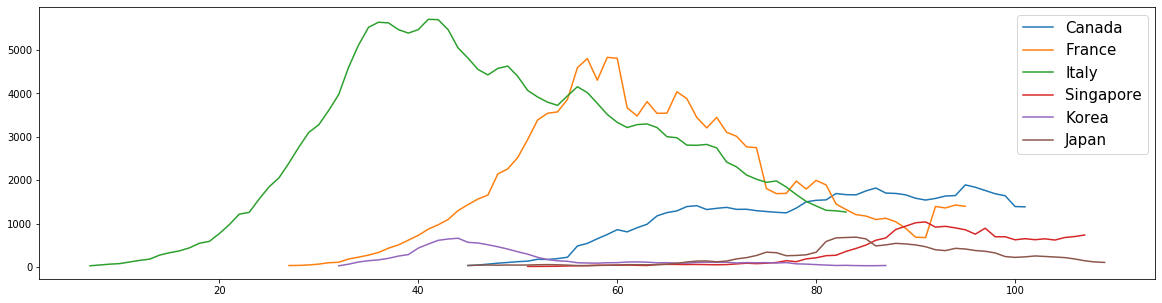

In [128]:
# Plot four chosen countries data
plt.figure(figsize=(20,5))
plt.plot(canada_rc, label="Canada")
plt.plot(france_rc, label="France")
plt.plot(italy_rc, label="Italy")
plt.plot(singapore_rc, label="Singapore")
plt.plot(korea_rc, label="Korea")
plt.plot(japan_rc, label="Japan")


plt.legend(fontsize=15)
plt.show()

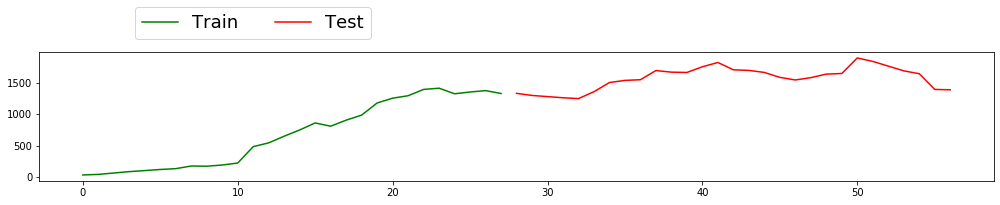

In [129]:
### Prepare the data

trainTarget, testTarget, inputTrain, inputTest = prepareData(canada_rc, train_perc=0.5, plotshow=True)

In [130]:
### Prepare observers
print("Before stack:", trainTarget.shape, testTarget.shape, inputTrain.shape, inputTest.shape)

# Calculate lengths
trainlen = len(inputTrain)
testlen = len(inputTest)
print(trainlen, testlen)

# Split Canada
canada_train = canada_rc[:trainlen]
canada_test = canada_rc[trainlen:]

# Split Singapore
sg_train = singapore_rc[:trainlen]
sg_test = singapore_rc[trainlen:]

# Split Italy
italy_train = italy_rc[:trainlen]
italy_test = italy_rc[trainlen:]

# Split France
france_train = france_rc[:trainlen]
france_test = france_rc[trainlen:]

# Split Korea
korea_train = korea_rc[:trainlen]
korea_test = korea_rc[trainlen:]

# Split Japan
japan_train = japan_rc[:trainlen]
japan_test = japan_rc[trainlen:]

# Print shapes
print("Train", inputTrain.shape, canada_train.shape, japan_train.shape, korea_train.shape, sg_train.shape, italy_train.shape, france_train.shape)
print("Test", inputTest.shape, canada_test.shape, japan_test.shape, korea_test.shape, sg_test.shape, italy_test.shape, france_test.shape)

# Predict minimum of test set
testlen_min = min(inputTest.shape, canada_test.shape, japan_test.shape, korea_test.shape, sg_test.shape, france_test.shape, italy_test.shape)[0]
inputTest = inputTest[:testlen_min]
testTarget = testTarget[:testlen_min]
canada_test = canada_test[:testlen_min]
italy_test = italy_test[:testlen_min]
france_test = france_test[:testlen_min]
sg_test = sg_test[:testlen_min]
korea_test = korea_test[:testlen_min]
japan_test = japan_test[:testlen_min]

print("Test After Update", inputTest.shape, canada_test.shape, japan_test.shape, korea_test.shape, sg_test.shape, italy_test.shape, france_test.shape)

# Stack input and observers
inputTrain = np.stack((inputTrain, japan_train, korea_train, sg_train, italy_train, france_train), axis=1)
inputTest = np.stack((inputTest, japan_test, korea_test, sg_test, italy_test, france_test), axis=1)
print("After stack:", trainTarget.shape, testTarget.shape, inputTrain.shape, inputTest.shape)

Before stack: (28,) (29,) (28,) (29,)
28 29
Train (28,) (28,) (28,) (28,) (28,) (28,) (28,)
Test (29,) (29,) (37,) (28,) (29,) (49,) (41,)
Test After Update (28,) (28,) (28,) (28,) (28,) (28,) (28,)
After stack: (28,) (28,) (28, 6) (28, 6)


In [131]:
### Make search grid for hyper-parameters spectral-radius and sparsity

# Define manual hyper-parameter tests
spectral_radius = np.linspace(1, 9, 10)
sparsity = np.linspace(0.1, 0.9, 10)

test_mse = {}

# Grid search across two hyper-parameters
for sr in spectral_radius:
    for sp in sparsity:
        # Define ESN
        esn_lt = ESN(n_inputs = 6,
                  spectral_radius = sr,
                  sparsity = sp,
                  n_outputs=n_outputs,
                  n_reservoir=n_reservoir,
                  noise=noise,
                  random_state=random_state)

        # Train ESN
        pred_training = esn_lt.fit(inputTrain, trainTarget)

        # Make quick prediction and return MSE
        prediction = esn_lt.predict(inputTest)
        mse = MSE(prediction, testTarget)
        params = [sr, sp]
        test_mse[mse] = params
        #print(f"SR: {sr}, SP: {sp} == MSE: {round(mse, 5)}")

In [132]:
min_mse = min(test_mse.keys())
print("Lowest testing MSE:", min_mse)

Lowest testing MSE: 258.0286841160495


In [133]:
# Define optimal hyper-parameters
sr_best = test_mse[min_mse][0]
sp_best = test_mse[min_mse][1]
print("SR: ", str(sr_best), ", SP: ", str(sp_best))

SR:  5.444444444444445 , SP:  0.6333333333333333


In [134]:
# Make a quick prediction
esn_lt = ESN(n_inputs = 6,
                  spectral_radius = sr_best,
                  sparsity = sp_best,
                  n_outputs=n_outputs,
                  n_reservoir=n_reservoir,
                  noise=noise,
                  random_state=random_state)

# Train ESN
pred_training = esn_lt.fit(inputTrain, trainTarget)

# Make quick prediction and return MSE
prediction = esn_lt.predict(inputTest)
mse = MSE(prediction, testTarget)
print("Quick Prediction MSE:", mse)

Quick Prediction MSE: 258.0286841160495


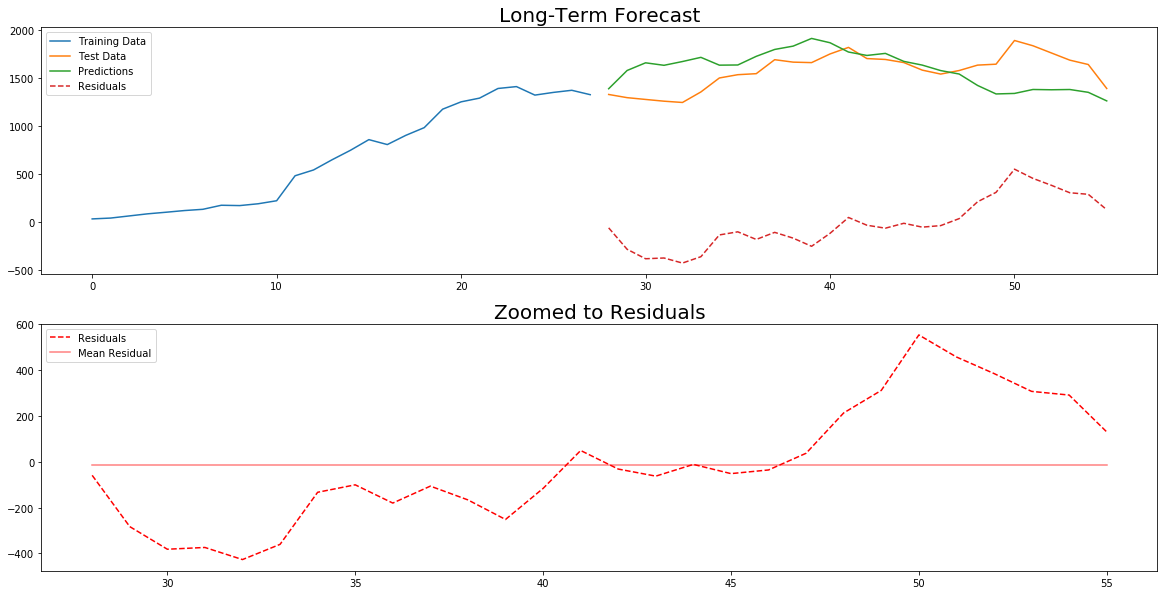

In [135]:
# Plot training, predictions and ground truth
fig, axs = plt.subplots(2,1, figsize=(20,10))
len_train = len(trainTarget)
len_test = len(testTarget)
axs[0].plot(range(0,len_train), trainTarget, label="Training Data")
axs[0].plot(range(len_train, len_train+len_test), testTarget, label="Test Data")
axs[0].plot(range(len_train, len_train+len_test), prediction, label="Predictions")
res = residuals(prediction, testTarget)
axs[0].plot(range(len_train, len_train+len_test), res, ls="--", label="Residuals")

axs[1].plot(range(len_train, len_train+len_test), res, ls="--", color="red", label="Residuals")
axs[1].plot(range(len_train, len_train+len_test), np.repeat(np.mean(res), len_test), ls="-", color="red", alpha=0.5, label="Mean Residual")

axs[0].set_title("Long-Term Forecast", size=20)
axs[1].set_title("Zoomed to Residuals", size=20)
axs[0].legend(loc=2, fontsize=10)
axs[1].legend(loc=2, fontsize=10)
plt.show()

#### Conclusion

Using observers with a variety of experiences, we were able to predict Canada's expected rate of new cases (smoothed) fairly well 28 days ahead of time. We set a minimum number of new cases at 25 to eliminate the long tail that might artificially send predictions towards zero too early. The forecast has a mean residual of almost exactly zero but can provide predictions as incorrect as +/- 400 new cases per day. Furthermore, even though the mean residual in our test set is $\sim 0$, the value of the residual seems to be a function of time, starting highly negative and growing with time.

That said, this is impressive performance. The fact is the model predicts as far into the future as it sees during training, and does an impressive job at it.

-----

-----

# Predicting what lies ahead
Having evaluated all these models on the various problem structures, we turn towards what the future has in store for the United States.

In [136]:
# Re-build data structures necessary for predictions
x_train, y_train = structure_supervised(covid_filtered, 'United_States_response', 14, 7, holdout=True)
rc_usa = usa[usa['new_cases_smooth'] > 100]['new_cases_smooth'].reset_index(drop=True)
case_scale = max(usa['new_cases_smooth'])
print(case_scale)

32785.0


### Designed Neural Network

In [137]:
# Calculate numbers for re-scaling
mul_predictions = mul.predict(usa_x)[-1]
usa_pop = growth_curve_all[growth_curve_all.country == 'United_States']['population_2018'].iloc[0]
max_count = max(growth_curve_all['new_cases_per100k_smooth'])
mul_predictions = mul_predictions * max_count * (usa_pop/100000)
mul_predictions

array([15912.745, 15369.569, 14476.506, 14135.635, 13915.881, 13831.641,
       13033.562], dtype=float32)

### Stacked LSTM

In [138]:
# Re-define Stacked LSTM
stacked_lstm = model_stacked_lstm(14, 7, features)

# Fit model to US COVID-19 cases
history_stacked_lstm = fit_model(stacked_lstm, val_split=0.2)

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_148 (LSTM)              (1, 14, 100)              65600     
_________________________________________________________________
lstm_149 (LSTM)              (1, 50)                   30200     
_________________________________________________________________
dense_94 (Dense)             (1, 7)                    357       
Total params: 96,157
Trainable params: 96,157
Non-trainable params: 0
_________________________________________________________________
Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 4s 74ms/sample - loss: 0.2839 - val_loss: 0.9542
Epoch 2/10
51/51 [==============================] - 1s 28ms/sample - loss: 0.1463 - val_loss: 0.1352
Epoch 3/10
51/51 [==============================] - 1s 28ms/sample - loss: 0.0366 - val_loss: 0.0811
Epoch 4/10
51/51 [==============

In [139]:
stacked_lstm_predictions = stacked_lstm.predict(x_train)[-1]*case_scale
stacked_lstm_predictions

array([30657.447, 31499.81 , 26028.436, 28344.29 , 29460.48 , 27571.352,
       31419.28 ], dtype=float32)

### Short-Term RC

In [140]:
### Make manual prediction

# Prepare US data
trainTarget, testTarget, inputTrain, inputTest = prepareData(usa_rc, train_perc=1.0, plotshow=False)
    
# Train ESN
pred_usa = esn_st.fit(inputTrain, trainTarget)

# Make prediction
esn_st_prediction = esn_st.predict(inputTrain)[-7:]
esn_st_prediction

array([[24527.68386672],
       [22434.61723253],
       [23499.43262978],
       [29172.72802673],
       [24060.40060189],
       [25160.30784369],
       [26760.9091952 ]])

### Plot predictions

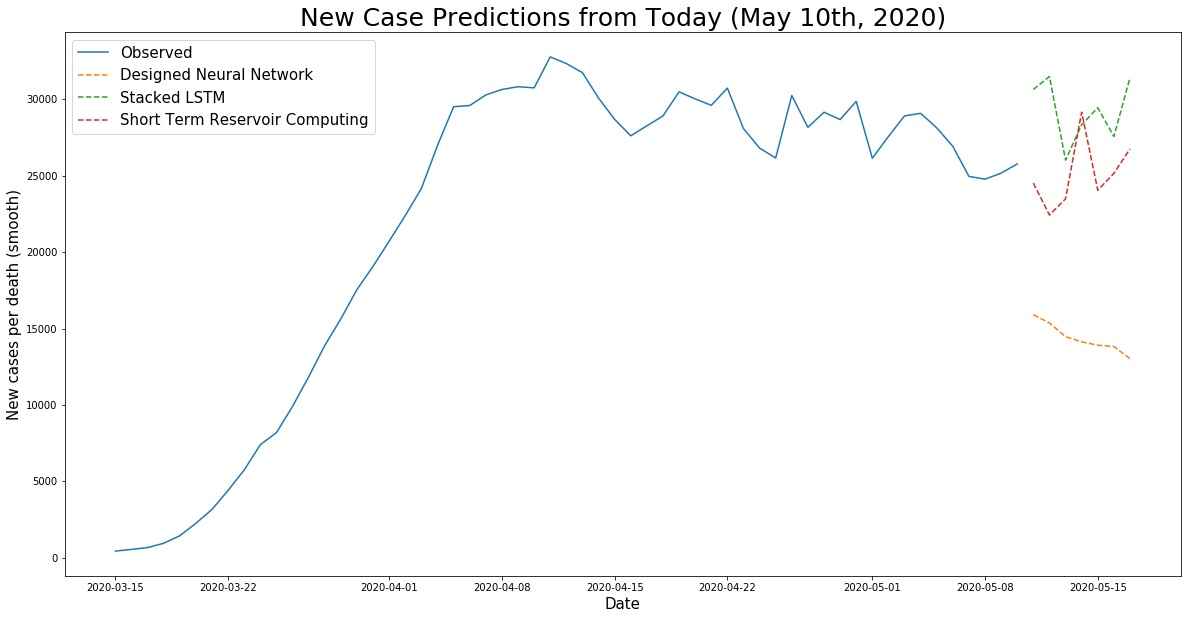

In [142]:
plt.figure(figsize=(20,10))
plt.plot(usa['date'][75:], usa['new_cases_smooth'][75:], label = 'Observed')
plt.plot(usa['date'][-7:] + pd.DateOffset(days=7), mul_predictions, ls='--', label="Designed Neural Network")
plt.plot(usa['date'][-7:] + pd.DateOffset(days=7), stacked_lstm_predictions, ls='--', label="Stacked LSTM")
plt.plot(usa['date'][-7:] + pd.DateOffset(days=7), esn_st_prediction, ls='--', label="Short Term Reservoir Computing")
plt.title("New Case Predictions from Today (May 10th, 2020)", size=25)
plt.ylabel("New cases per death (smooth)", size=15)
plt.xlabel("Date", size=15)
plt.legend(loc=2, fontsize=15)
plt.show()

# Concluding Remarks

As we can see from our final predictions, each model interacts with the developing COVID-19 data in slightly distinctive ways. The Stacked LSTM model maintains the longest "memory" and so is likeliest to expect a return to traditional growth expectations seen in the first part of the time series. The Short-Term RC model is most frequently applied to chaotic systems so it tends to expect a continued up-and-down from new case growth. Our self-designed neural network was trained on the growth curves of all countries so it has learned from other countries that the general trend is to decrease after hitting a peak. The divergence between these three model predictions suggests that the United States remains on a plateau in its fight to contain COVID-19. We are no longer seeing the high earlier growth but neither are we seeing the decline that other nations are. As new data comes in, our models can be updated to get a better sense of which direction the case load will go. If they begin to agree, we can be more confident that case load is migrating in that direction. Until then, the fight against COVID-19 requires continued public health expertise and improved policymaking. With better public policy, our models will begin to reflect the decline we all want to see.